In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import cumtrapz

import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.feature_library import PolynomialLibrary

from pysindy.optimizers import SR3
from pysindy.optimizers import ConstrainedSR3
#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
def plot_ensemble_results(
    model, mean_ensemble, std_ensemble, mean_library_ensemble, std_library_ensemble
):
    # Plot results
    xticknames = model.get_feature_names()
    xticknames = ["$" + name + "$" for name in xticknames]  # LaTeX formatting
    plt.figure(figsize=(18, 8))

    # First subplot for ensemble mean and standard deviation
    plt.subplot(1, 2, 1)
    plt.title("Ensemble Coefficients", fontsize=24)
    plt.xlabel("Candidate terms", fontsize=22)
    plt.ylabel("Coefficient values", fontsize=22)
    colors = ["b", "r", "k"]
    for i in range(mean_ensemble.shape[0]):
        plt.errorbar(
            range(mean_ensemble.shape[1]),
            mean_ensemble[i, :],
            yerr=std_ensemble[i, :],
            fmt="o",
            color=colors[i % len(colors)],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    ax.set_yscale("log")  # Set y-scale to log
    ax.set_xticks(range(len(xticknames)))
    #ax.set_xticklabels(xticknames, fontsize=20, rotation=90)
    ax.set_xticklabels(xticknames, verticalalignment="top")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    plt.legend(fontsize=16, loc="upper left")

    # Second subplot for the library ensemble mean and standard deviation
    plt.subplot(1, 2, 2)
    plt.title("Library Ensemble Coefficients", fontsize=24)
    plt.xlabel("Candidate terms", fontsize=22)
    for i in range(mean_library_ensemble.shape[0]):
        plt.errorbar(
            range(mean_library_ensemble.shape[1]),
            mean_library_ensemble[i, :],
            yerr=std_library_ensemble[i, :],
            fmt="o",
            color=colors[i % len(colors)],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    ax.set_yscale("log")  # Set y-scale to log
    ax.set_xticks(range(len(xticknames)))
    #ax.set_xticklabels(xticknames, fontsize=20, rotation=90)
    ax.set_xticklabels(xticknames, verticalalignment="top")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    plt.legend(fontsize=16, loc="upper left")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [3]:
def integrate_data(data, dt=1):
    """
    Manually integrate the data using a simple Euler integration method.

    Parameters:
    data (array): The input data to be integrated.
    dt (float): The time step for integration.

    Returns:
    integrated_data: The integrated data.
    """
    
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt
    return integrated_data

In [4]:
# Set the directory path and filenames
folder_path = 'C:/1. Power grid frequency data/'
file_names = ['ES_PM01.csv', 'IS02.csv', 'IRL01.csv']

# Load the CSV files into dataframes
dataframes = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, sep=';', 
                     usecols=[0,1,2], names=['Time','f50','QI'],
                     header=0)
    df.iloc[:,1]=df.iloc[:,1]/1000+50
    dataframes.append(df)


# Only select quality QI=0
flt_dataframes = []
for df in dataframes:
    flt_dfs = df[df['QI'] == 0].dropna()
    flt_dataframes.append(flt_dfs)
    
region_dict = {0: 'Balearic', 1: 'Iceland', 2: 'Ireland'}

# Group the dataframes by region
region_groups = [df.groupby(lambda x: region_dict[i]) for i, df in enumerate(flt_dataframes)]
colors=('#66a61e', '#e6ab02','#a6761d')

In [5]:
flt_dataframes

[                        Time        f50  QI
 0        2019-09-29 00:00:00  49.910152   0
 1        2019-09-29 00:00:01  49.909710   0
 2        2019-09-29 00:00:02  49.906570   0
 3        2019-09-29 00:00:03  49.900815   0
 4        2019-09-29 00:00:04  49.896620   0
 ...                      ...        ...  ..
 8121595  2019-12-31 23:59:55  49.926787   0
 8121596  2019-12-31 23:59:56  49.928471   0
 8121597  2019-12-31 23:59:57  49.929596   0
 8121598  2019-12-31 23:59:58  49.930813   0
 8121599  2019-12-31 23:59:59  49.931968   0
 
 [8120287 rows x 3 columns],
                         Time        f50  QI
 0        2021-11-05 08:28:40  50.047199   0
 1        2021-11-05 08:28:41  50.045448   0
 2        2021-11-05 08:28:42  50.041388   0
 3        2021-11-05 08:28:43  50.037016   0
 4        2021-11-05 08:28:44  50.031883   0
 ...                      ...        ...  ..
 7486275  2022-01-30 23:59:55  49.980193   0
 7486276  2022-01-30 23:59:56  49.982376   0
 7486277  2022-01-30 23:

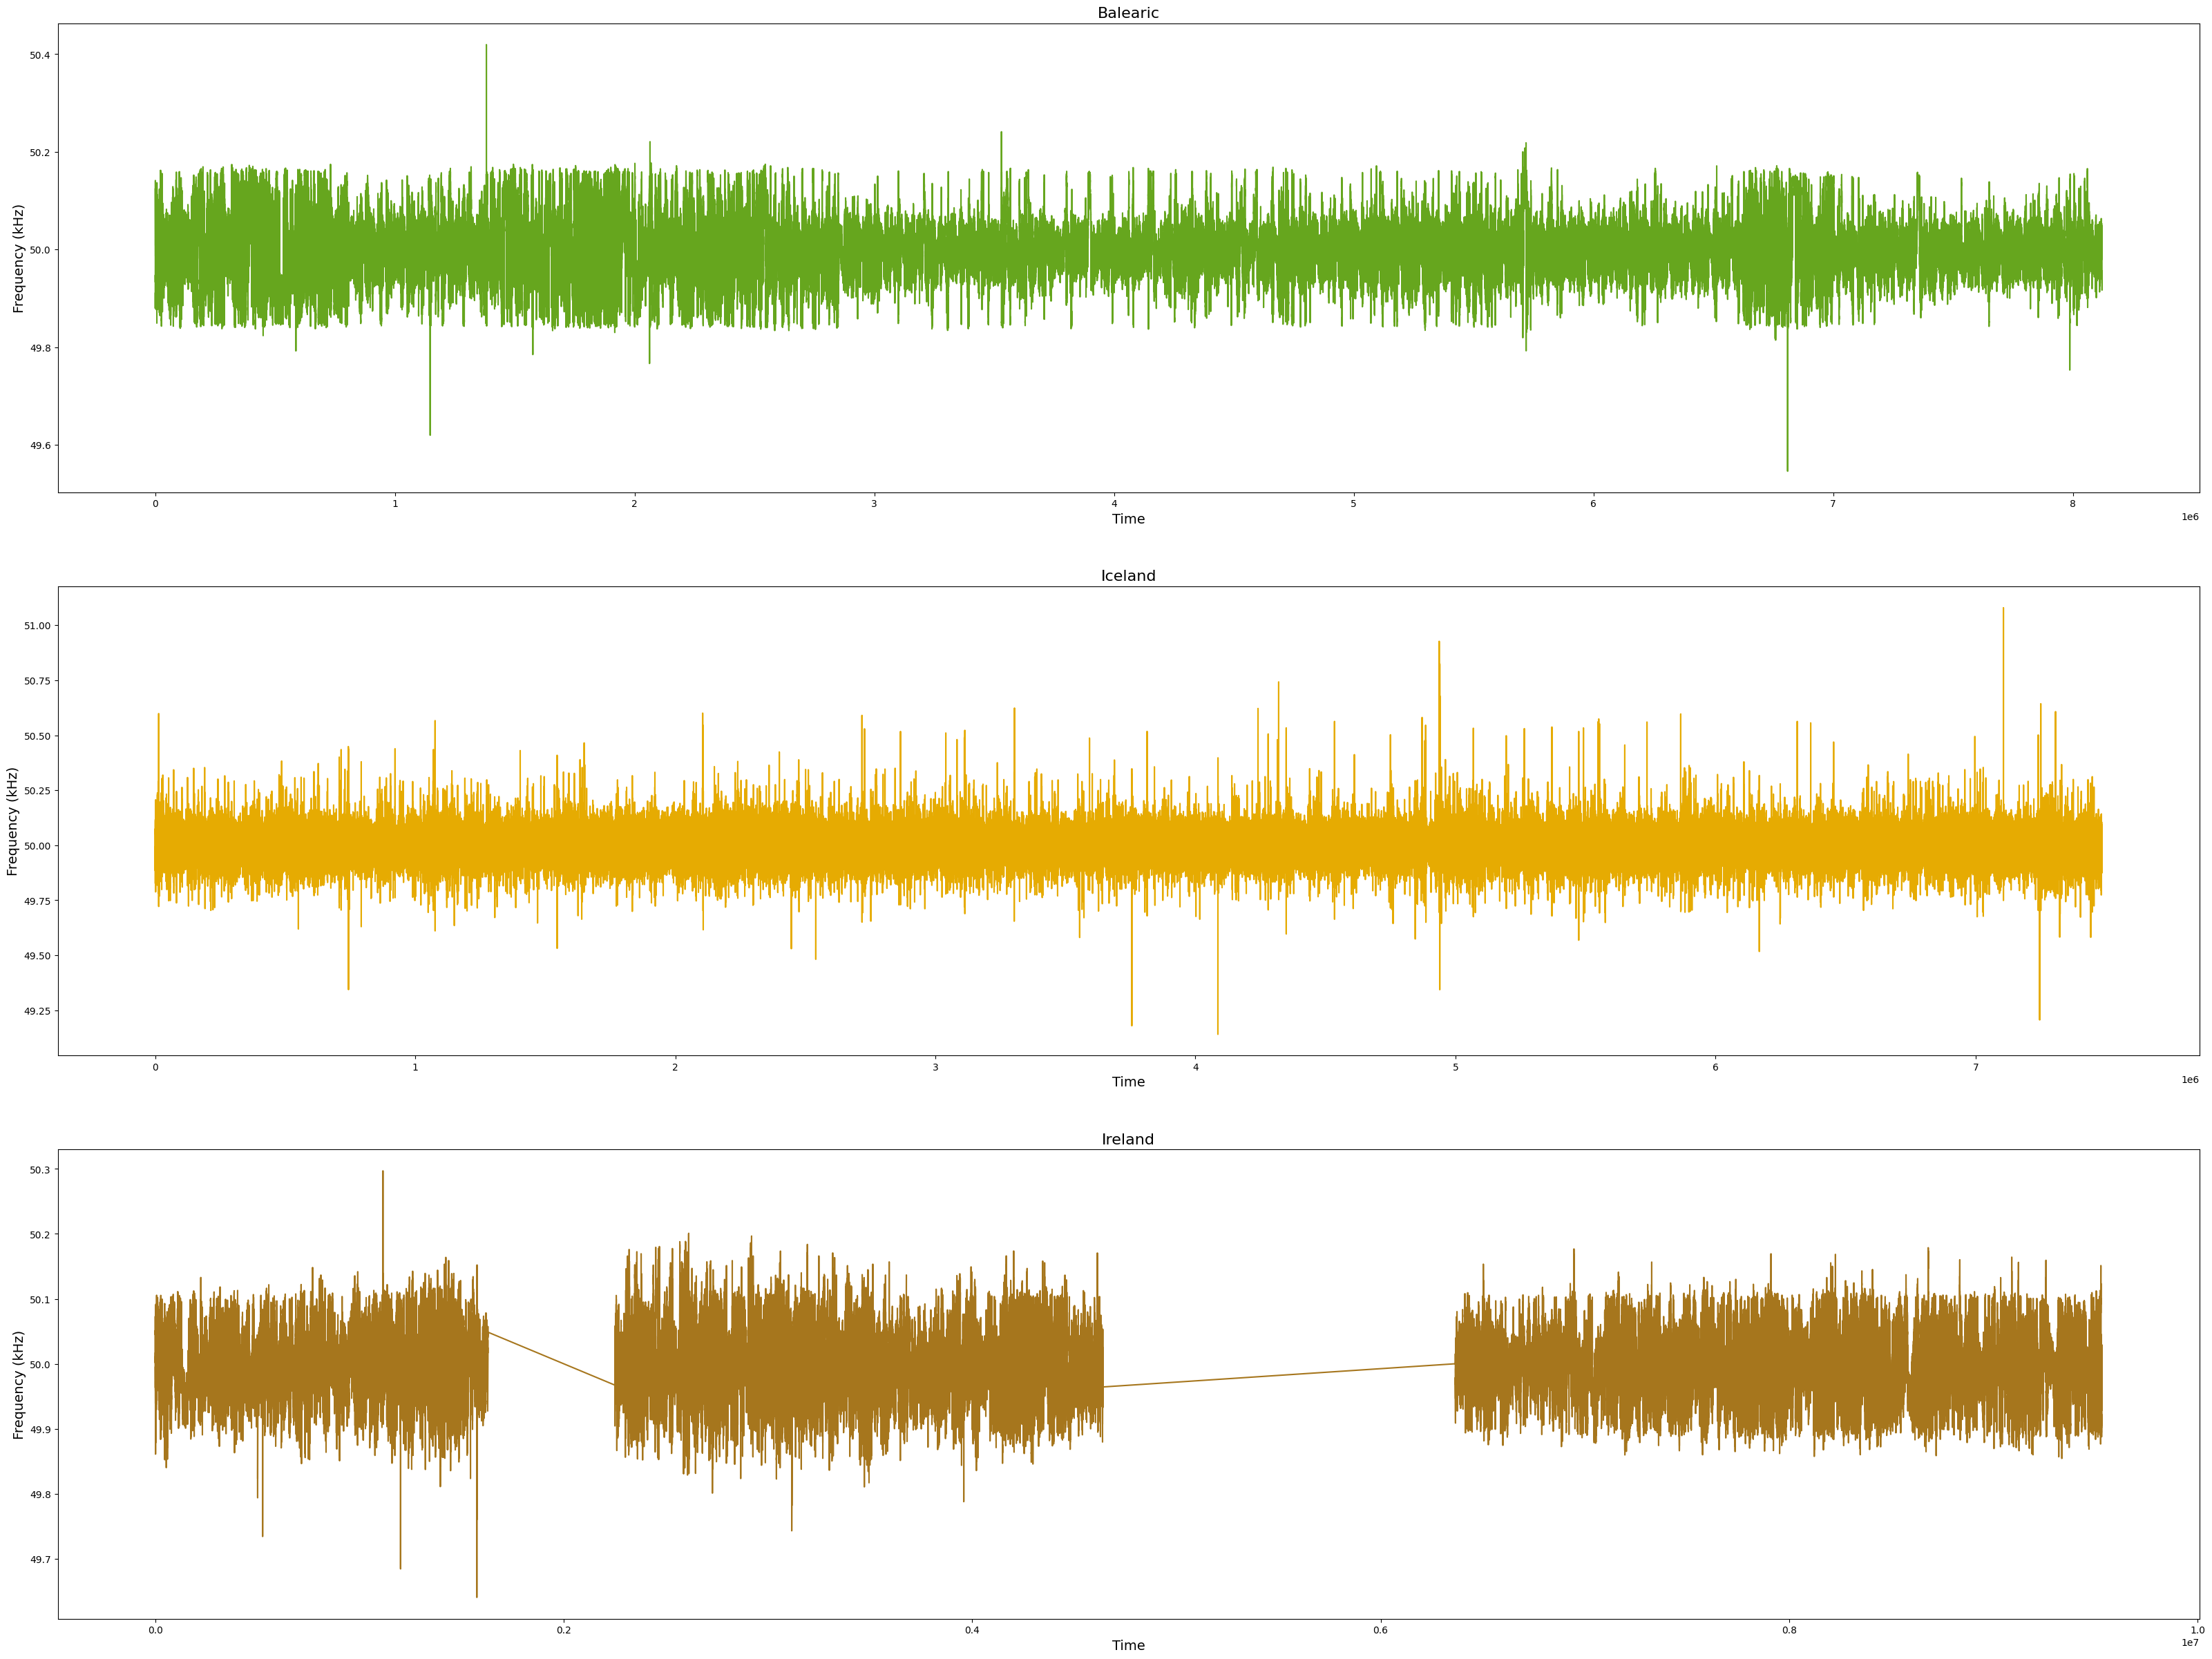

In [6]:
fig, axs = plt.subplots(nrows=len(flt_dataframes), figsize=(40,30))

for i, df in enumerate(flt_dataframes):
    axs[i].plot(df['f50'],color=colors[i])
    axs[i].set_title(region_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)',fontsize=14)

#plt.tight_layout()
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

In [7]:
# Find the longest continuous part for each region
filter_data = []
for df in flt_dataframes:
    # Convert the 'Time' column to datetime type
    df['Time'] = pd.to_datetime(df['Time'])
    time_diff = df['Time'].diff()

    # Find the longest continuous part by grouping consecutive timestamps with the same difference
    groups = (time_diff != pd.Timedelta(seconds=1)).cumsum()
    max_group = groups.value_counts().idxmax()

    # Filter the DataFrame to retain only the longest continuous part
    longest_continuous_df = df[groups == max_group]
    filter_data.append(longest_continuous_df)
    
filter_dict = {0: 'Balearic', 1: 'Iceland', 2: 'Ireland'}

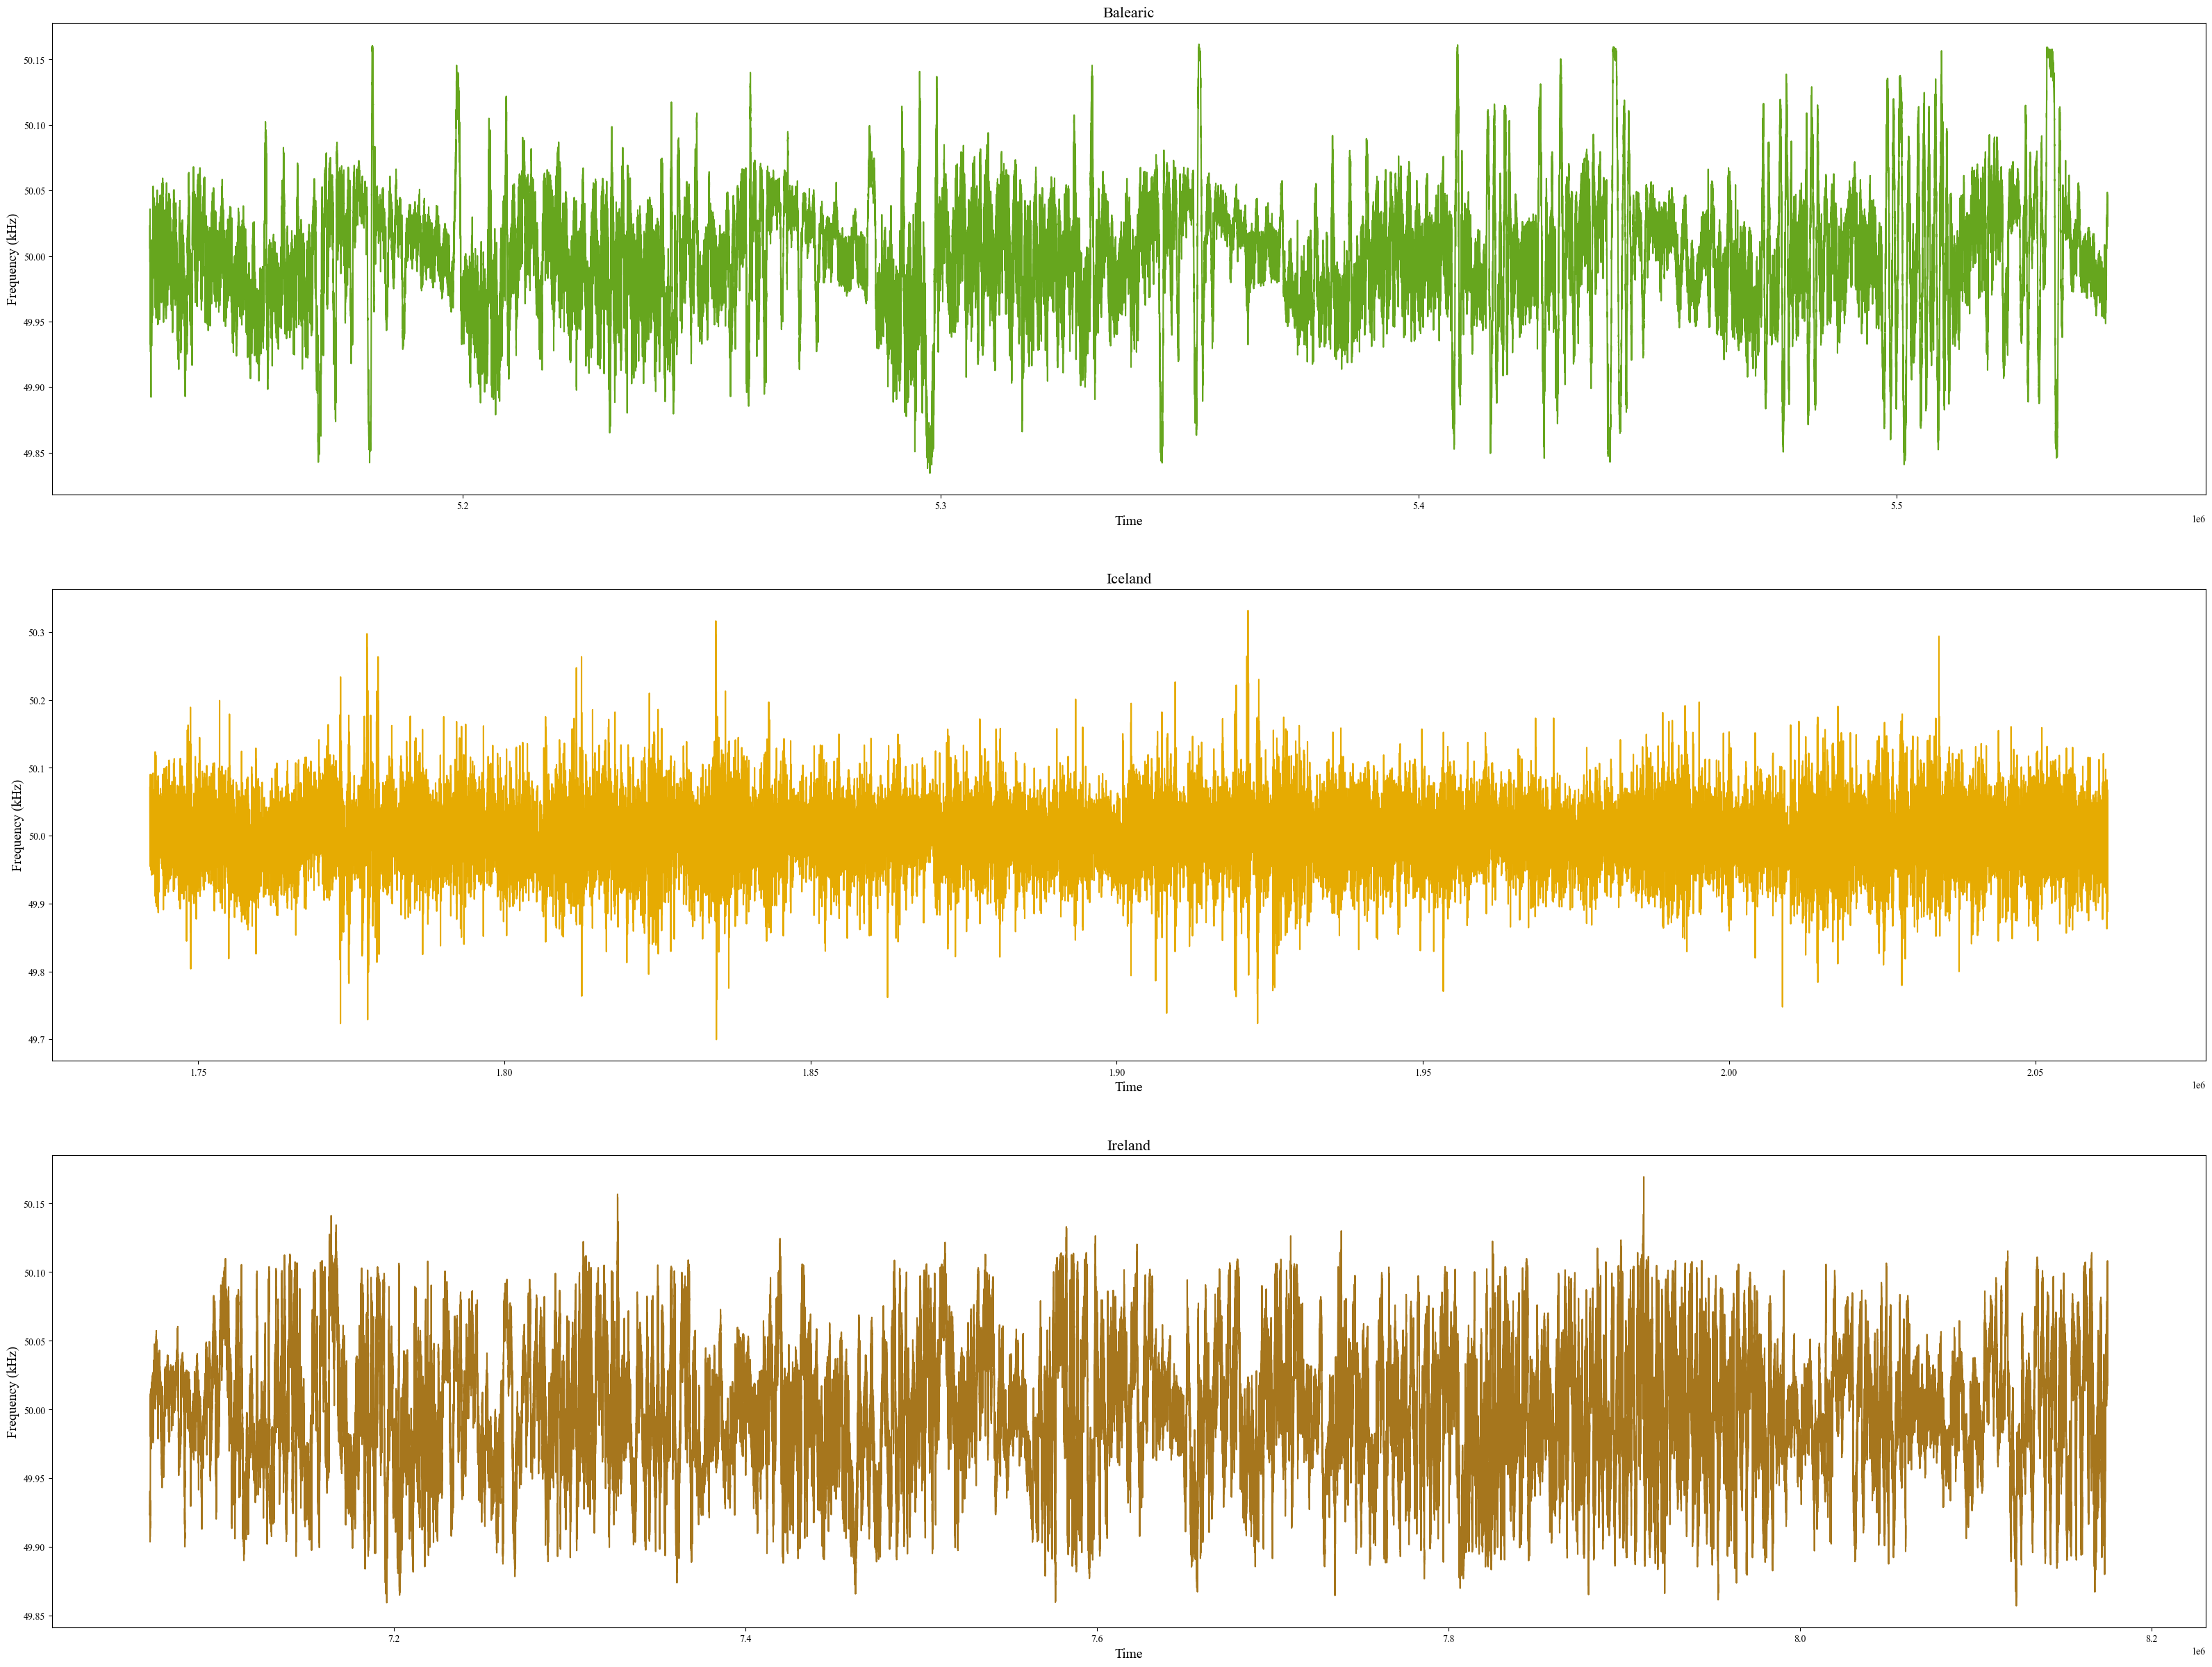

In [8]:
fig, axs = plt.subplots(nrows=len(filter_data), figsize=(40,30))

for i, df in enumerate(filter_data):
    axs[i].plot(df['f50'],color=colors[i])
    axs[i].set_title(region_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)',fontsize=14)

#plt.tight_layout()
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

In [9]:
# Assuming filter_data is a list of DataFrames
for i, df in enumerate(filter_data):
    # Make sure we're working with a copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Step 1: Delete the 'QI' column if it exists
    if 'QI' in df.columns:
        df.drop('QI', axis=1, inplace=True)
    
    # Step 2: Convert frequency to omega and add 'omega' column
    df['omega'] = 2 * np.pi * (df['f50'] - 50)
    
    # Reset index for each DataFrame
    df.reset_index(drop=True, inplace=True)
    
    # Save the modified DataFrame back to the filter_data list
    filter_data[i] = df



In [10]:
bal = filter_data[0]
ice = filter_data[1]
ire = filter_data[2]

In [99]:
len(bal)/(3600*24)

4.739247685185185

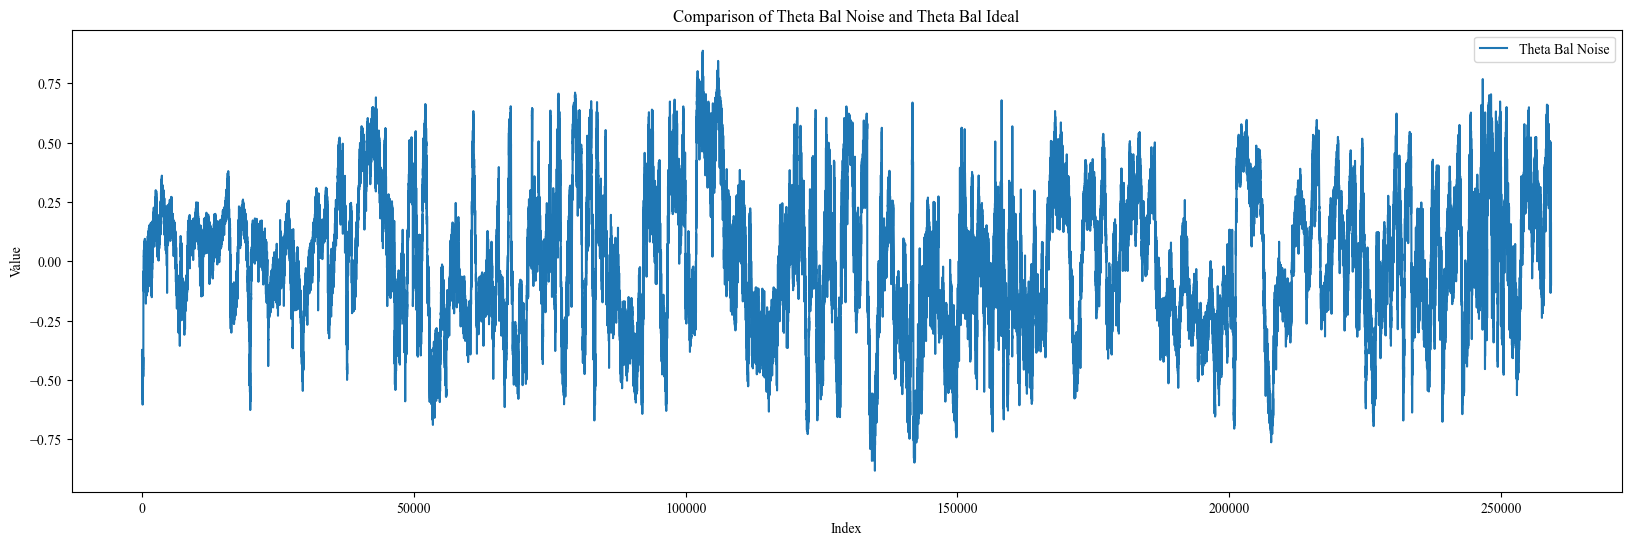

In [11]:
plt.figure(figsize=(20, 6))  # Adjust the size as needed

mean=np.mean(integrate_data(ire.omega[:900*96*3]))
plt.plot(ire.omega[:900*96*3], label='Theta Bal Noise')
#plt.plot(integrate_data(ire.omega[:900*96*3]), label='Theta Bal Ideal')

plt.legend()  # Show legend if multiple lines are plotted
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Theta Bal Noise and Theta Bal Ideal')

plt.show()

In [12]:
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def apply_gaussian_filter(data, region_name, chunk_size=900*4, sigma=60):
    # Create DataFrame
    data_df = pd.DataFrame({'omega': data})

    # Define the list to hold the filtered DataFrames
    filtered_data = []

    # Calculate the number of chunks needed
    num_chunks = len(data_df) // chunk_size

    # Split the DataFrame into chunks and apply the Gaussian filter to each chunk
    for j in range(num_chunks):
        # Extract the chunk
        chunk = data_df.iloc[j*chunk_size:(j+1)*chunk_size].copy()
        
        # Apply Gaussian filter to the 'omega' column
        chunk['omega_filtered'] = gaussian_filter1d(chunk['omega'], sigma=sigma)
        
        # Label the chunk with the specified region name
        chunk['Region'] = region_name
        
        # Append the filtered chunk to the list
        filtered_data.append(chunk)

    # If there are remaining data points
    if len(data_df) % chunk_size != 0:
        remaining_chunk = data_df.iloc[num_chunks*chunk_size:].copy()
        remaining_chunk['omega_filtered'] = gaussian_filter1d(remaining_chunk['omega'], sigma=sigma)
        
        # Label the remaining chunk with the specified region name
        remaining_chunk['Region'] = region_name
        
        # Append the remaining chunk to the list
        filtered_data.append(remaining_chunk)
    
    return filtered_data


In [13]:
def calculate_sindy_models(region_data, region_name, n=2):
    # Initialize an empty list for sindy_models
    sindy_models = []

    # Iterate over each chunk
    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = integrate_data(chunk['omega_filtered'].values)

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])
        #x_train_augmented_chunk = np.hstack([stacked_data_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "time"]
        #feature_names_chunk = ["theta", "omega"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=n)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        model_chunk.print(precision=7)
        print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        print()

    # Initialize empty lists for coefficient matrices
    coefficients_matrices = []

    # Iterate over each SINDy model in sindy_models
    for model in sindy_models:
        # Get the coefficients from the model
        coefficients = model.coefficients()

        # Append the coefficients to the list
        coefficients_matrices.append(coefficients)

    # Convert the list of matrices to a 3D NumPy array
    coefficients_array = np.array(coefficients_matrices)

    # Calculate mean and standard deviation along the first axis (axis=0) which corresponds to chunks
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    # Print or use mean_coefficients and std_coefficients as needed
    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients Coefficients for {region_name}:")
    print(std_coefficients)
    
    return sindy_models

In [14]:
def simulate_sindy_model(model, initial_conditions, time_points, title, omega_original, omega_filtered):
    # Simulate the system using the provided model
    simulated_data = model.simulate(initial_conditions, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plot the simulation results
    plt.figure(figsize=(10, 6))

    # Plot the original Omega with noise
    plt.plot(omega_original, label='Original Omega with noise', alpha=0.7, color='#2b6a99')

    # Plot the Gaussian Filtered Omega
    plt.plot(omega_filtered, label='Gaussian Filtered Omega', linestyle='-', linewidth=2, color='#1b7c3d')

    # Plot the simulated Omega
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3, color='#f16c23')

    plt.title(f'Comparison of Original, Filtered, and Simulated Omega - {title}')
    plt.xlabel('Time')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

In [15]:
def calculate_sindy_models_abs(region_data, region_name, n=2):
    # Initialize an empty list for sindy_models
    sindy_models = []

    # Iterate over each chunk
    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = integrate_data(chunk['omega_filtered'].values)

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "time"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=n)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        #print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        #model_chunk.print(precision=7)
        #print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        #print()

    # Initialize empty lists for coefficient matrices
    coefficients_matrices = []
    
    for model in sindy_models:
        coefficients = model.coefficients()
        feature_names = model.get_feature_names()

        # Handling the presence of specific features
        time_indices = [feature_names.index(f) for f in feature_names if 'time' in f]

        # Take the absolute value of specific coefficients
        for idx in time_indices:
            coefficients[:, idx] = np.abs(coefficients[:, idx])

        coefficients_matrices.append(coefficients)

    # Convert to a 3D NumPy array and calculate mean and standard deviation
    coefficients_array = np.array(coefficients_matrices)
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients for {region_name}:")
    print(std_coefficients)

    return mean_coefficients, std_coefficients


In [35]:
omega_bal_noise_filtered = apply_gaussian_filter(bal.omega, 'Balearic', sigma=60)
balearic_data = [chunk for chunk in omega_bal_noise_filtered if chunk['Region'].iloc[0] == 'Balearic']

In [36]:
balearic_mean, balearic_std = calculate_sindy_models_abs(balearic_data, 'Balearic',n=2)

Mean Coefficients for Balearic:
[[ 8.97030811e-07 -1.28911426e-05  9.99086040e-01  2.62123764e-06
   7.62339467e-09 -3.28690201e-06  9.93852905e-09  8.00605754e-04
   1.72095453e-06  9.51993618e-10]
 [-8.68839033e-06 -2.68121239e-05 -1.55561353e-03  5.45784730e-06
   9.29321279e-09 -6.68916919e-06  2.08246500e-08  1.44294484e-03
   3.49432192e-06  2.06552917e-09]
 [ 1.00000000e+00  4.33457505e-16  3.11123057e-15  7.26334694e-17
  -7.48674043e-20 -4.15847088e-17  7.44824034e-19 -5.58704655e-15
   7.35777915e-17  6.73610500e-20]]
Standard Deviation of Coefficients for Balearic:
[[8.44077962e-04 1.50665626e-05 3.27696163e-03 3.38600799e-06
  8.46883345e-08 2.08695335e-05 1.35758608e-08 5.61472193e-03
  2.27927360e-06 1.29978273e-09]
 [1.66840474e-03 3.09644514e-05 6.51246104e-03 6.87981950e-06
  1.71921908e-07 4.16398560e-05 2.74893946e-08 1.11493855e-02
  4.54397316e-06 2.65374184e-09]
 [4.53056964e-15 1.52940352e-15 1.67758159e-14 1.97792691e-16
  4.22816923e-18 1.65064100e-15 1.5511565

In [37]:
balearic_models = calculate_sindy_models(balearic_data, 'Balearic',n=2)

Model for Balearic - Chunk 1:
(theta)' = -0.0007862 1 + 0.0000073 theta + 1.0001832 omega + -0.0000009 time + 0.0000002 theta^2 + 0.0000188 theta omega + 0.0072540 omega^2 + -0.0000007 omega time
(omega)' = -0.0015624 1 + 0.0000145 theta + 0.0004056 omega + -0.0000018 time + 0.0000003 theta^2 + 0.0000376 theta omega + 0.0144281 omega^2 + -0.0000013 omega time
(time)' = 1.0000000 1
Model Score: 0.4964470355532689

Model for Balearic - Chunk 2:
(theta)' = -0.0002659 1 + -0.0000303 theta + 1.0050995 omega + 0.0000022 time + 0.0000002 theta^2 + -0.0000199 theta omega + -0.0051391 omega^2 + -0.0000034 omega time
(omega)' = -0.0005392 1 + -0.0000607 theta + 0.0102800 omega + 0.0000045 time + 0.0000003 theta^2 + -0.0000406 theta omega + -0.0101618 omega^2 + -0.0000068 omega time
(time)' = 1.0000000 1
Model Score: 0.49667882159642424

Model for Balearic - Chunk 3:
(theta)' = -0.0005058 1 + -0.0000155 theta + 1.0001294 omega + -0.0000045 time + 0.0000018 theta omega + -0.0003674 omega^2
(omega)

Model for Balearic - Chunk 44:
(theta)' = -0.0000778 1 + -0.0000109 theta + 0.9987830 omega + -0.0000032 time + -0.0000108 theta omega + -0.0006585 omega^2 + -0.0000019 omega time
(omega)' = -0.0001276 1 + -0.0000227 theta + -0.0023426 omega + -0.0000067 time + -0.0000216 theta omega + -0.0013246 omega^2 + -0.0000038 omega time
(time)' = 1.0000000 1
Model Score: 0.4822118568939784

Model for Balearic - Chunk 45:
(theta)' = -0.0005489 1 + -0.0000248 theta + 0.9995052 omega + -0.0000052 time + -0.0000162 theta omega + 0.0035027 omega^2 + -0.0000017 omega time
(omega)' = -0.0010885 1 + -0.0000500 theta + -0.0009269 omega + -0.0000105 time + -0.0000324 theta omega + 0.0070278 omega^2 + -0.0000035 omega time
(time)' = 1.0000000 1
Model Score: 0.5461728856061722

Model for Balearic - Chunk 46:
(theta)' = -0.0003093 1 + -0.0000238 theta + 0.9971332 omega + -0.0000238 time + -0.0000092 theta omega + 0.0027693 omega^2 + -0.0000049 omega time
(omega)' = -0.0006209 1 + -0.0000477 theta + -0.00576

Model for Balearic - Chunk 67:
(theta)' = -0.0004471 1 + -0.0000054 theta + 0.9972095 omega + -0.0000002 time + -0.0000123 theta omega + -0.0058268 omega^2 + -0.0000021 omega time
(omega)' = -0.0006243 1 + -0.0000164 theta + -0.0032363 omega + -0.0000017 time + -0.0000209 theta omega + -0.0069527 omega^2 + -0.0000036 omega time
(time)' = 1.0000000 1
Model Score: 0.43827712841084754

Model for Balearic - Chunk 68:
(theta)' = 0.0000664 1 + -0.0000138 theta + 1.0001459 omega + -0.0000033 time + -0.0000036 theta omega + -0.0011147 omega^2 + -0.0000004 omega time
(omega)' = 0.0001406 1 + -0.0000276 theta + 0.0003199 omega + -0.0000065 time + 0.0000001 theta^2 + -0.0000073 theta omega + -0.0022529 omega^2 + -0.0000009 omega time
(time)' = 1.0000000 1
Model Score: 0.5884004884951972

Model for Balearic - Chunk 69:
(theta)' = -0.0000459 1 + -0.0000281 theta + 1.0004752 omega + -0.0000053 time + 0.0000001 theta^2 + -0.0000182 theta omega + 0.0019393 omega^2 + -0.0000025 omega time
(omega)' = -0

Model Score: 0.44578427874464116

Model for Balearic - Chunk 89:
(theta)' = 0.0002814 1 + -0.0000362 theta + 0.9987097 omega + 0.0000037 time + 0.0000001 theta^2 + 0.0000194 theta omega + 0.0034313 omega^2 + -0.0000007 omega time
(omega)' = 0.0005617 1 + -0.0000726 theta + -0.0025463 omega + 0.0000073 time + 0.0000001 theta^2 + 0.0000391 theta omega + 0.0068071 omega^2 + -0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.5094076740538184

Model for Balearic - Chunk 90:
(theta)' = 0.0002235 1 + 0.0000074 theta + 0.9965231 omega + 0.0000014 time + -0.0000004 theta omega + -0.0028995 omega^2 + 0.0000011 omega time
(omega)' = 0.0004427 1 + 0.0000145 theta + -0.0068971 omega + 0.0000027 time + -0.0000001 theta^2 + -0.0000008 theta omega + -0.0057401 omega^2 + 0.0000023 omega time
(time)' = 1.0000000 1
Model Score: 0.5757010842292828

Model for Balearic - Chunk 91:
(theta)' = 0.0002986 1 + 0.0000037 theta + 1.0013288 omega + -0.0000006 time + 0.0000001 theta^2 + 0.0000136 theta omega

Model for Balearic - Chunk 110:
(theta)' = -0.0018083 1 + -0.0000070 theta + 1.0004283 omega + 0.0000020 time + 0.0000127 theta omega + 0.0017038 omega^2 + -0.0000009 omega time
(omega)' = -0.0036169 1 + -0.0000139 theta + 0.0008859 omega + 0.0000039 time + 0.0000001 theta^2 + 0.0000255 theta omega + 0.0034323 omega^2 + -0.0000019 omega time
(time)' = 1.0000000 1
Model Score: 0.6082833920185858

Model for Balearic - Chunk 111:
(theta)' = -0.0006363 1 + 0.0000025 theta + 0.9951153 omega + 0.0000016 time + 0.0000025 theta omega + 0.0034161 omega^2 + -0.0000003 omega time
(omega)' = -0.0012734 1 + 0.0000050 theta + -0.0097653 omega + 0.0000032 time + 0.0000051 theta omega + -0.0000001 theta time + 0.0068434 omega^2 + -0.0000006 omega time
(time)' = 1.0000000 1
Model Score: 0.6208720946142684

Model for Balearic - Chunk 112:
(theta)' = -0.0008285 1 + -0.0000287 theta + 1.0019394 omega + 0.0000020 time + -0.0000001 theta^2 + 0.0000366 theta omega + -0.0067741 omega^2 + -0.0000022 omega time

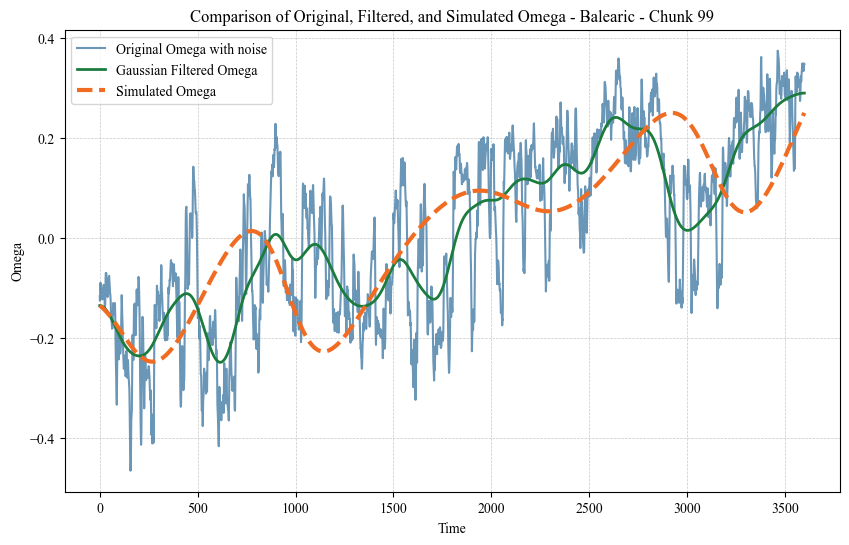

In [41]:
n=98
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(balearic_data[n]['omega_filtered'].values)[0], 
                      balearic_data[n]['omega_filtered'].iloc[0],0]

# Define time points for simulation
total_time = len(balearic_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = balearic_data[n]['omega'].values  
omega_filtered = balearic_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 2)
simulate_sindy_model(balearic_models[n], initial_conditions, time_points, f'Balearic - Chunk {n+1}', omega_original, omega_filtered)


In [20]:
omega_ice_noise_filtered = apply_gaussian_filter(ice.omega, 'Iceland', sigma=60)
iceland_data = [chunk for chunk in omega_ice_noise_filtered if chunk['Region'].iloc[0] == 'Iceland']

In [21]:
iceland_mean, iceland_std = calculate_sindy_models_abs(iceland_data, 'Iceland',n=2)

Mean Coefficients for Iceland:
[[ 5.28548111e-05 -2.93090033e-05  9.97461410e-01  1.68700299e-06
   1.11706549e-07  1.14606819e-05  2.72935531e-08 -1.42598024e-05
   2.98318936e-06  8.20274894e-10]
 [ 1.09452394e-04 -6.12691704e-05 -4.92898030e-03  3.54245824e-06
   2.35431227e-07  2.30265415e-05  5.52019137e-08  2.75756824e-04
   5.92645561e-06  1.67700810e-09]
 [ 1.00000000e+00  4.75323008e-18  5.06120475e-15  1.77719482e-17
  -2.56445345e-18  1.47469674e-16  2.29894058e-18 -1.99857147e-14
   1.01954431e-16  6.44442392e-20]]
Standard Deviation of Coefficients for Iceland:
[[5.85601787e-04 3.51561597e-05 3.49195120e-03 2.06091826e-06
  7.56336703e-07 1.20801081e-04 5.86427319e-08 1.95447855e-02
  3.48780371e-06 1.65095318e-09]
 [1.17077457e-03 7.16095453e-05 6.95617791e-03 4.29315699e-06
  1.53141737e-06 2.41493411e-04 1.16868393e-07 3.85823237e-02
  6.89203731e-06 3.30055367e-09]
 [2.35925144e-15 2.86511612e-16 2.37504037e-14 3.97708631e-17
  1.01651311e-16 1.16391785e-15 6.45698643e

In [22]:
iceland_models = calculate_sindy_models(iceland_data, 'Iceland',n=2)

Model for Iceland - Chunk 1:
(theta)' = 0.0001963 1 + -0.0000175 theta + 0.9991274 omega + 0.0000005 time + 0.0000002 theta^2 + 0.0000328 theta omega + 0.0060873 omega^2 + -0.0000010 omega time
(omega)' = 0.0003897 1 + -0.0000351 theta + -0.0017240 omega + 0.0000010 time + 0.0000005 theta^2 + 0.0000651 theta omega + 0.0126750 omega^2 + -0.0000020 omega time
(time)' = 1.0000000 1
Model Score: 0.4215425868542801

Model for Iceland - Chunk 2:
(theta)' = 0.0000992 1 + -0.0000034 theta + 0.9973473 omega + -0.0000002 time + -0.0000001 theta^2 + -0.0000396 theta omega + 0.0113166 omega^2 + 0.0000013 omega time
(omega)' = 0.0001940 1 + -0.0000074 theta + -0.0051042 omega + -0.0000004 time + -0.0000002 theta^2 + -0.0000790 theta omega + 0.0229119 omega^2 + 0.0000025 omega time
(time)' = 1.0000000 1
Model Score: 0.46161612911880073

Model for Iceland - Chunk 3:
(theta)' = -0.0000677 1 + -0.0000124 theta + 0.9999446 omega + -0.0000011 time + 0.0000432 theta omega + 0.0082784 omega^2 + -0.0000017 

Model for Iceland - Chunk 23:
(theta)' = -0.0003478 1 + -0.0000878 theta + 0.9999714 omega + -0.0000031 time + -0.0000006 theta^2 + -0.0001135 theta omega + 0.0138341 omega^2 + -0.0000031 omega time
(omega)' = -0.0006821 1 + -0.0001753 theta + 0.0002080 omega + -0.0000062 time + -0.0000012 theta^2 + -0.0002258 theta omega + 0.0278101 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.499133769998124

Model for Iceland - Chunk 24:
(theta)' = -0.0000149 1 + -0.0000133 theta + 1.0018090 omega + -0.0000004 time + 0.0000001 theta^2 + 0.0001272 theta omega + 0.0284016 omega^2 + -0.0000031 omega time
(omega)' = -0.0000303 1 + -0.0000269 theta + 0.0037386 omega + -0.0000007 time + 0.0000001 theta^2 + 0.0002539 theta omega + 0.0567609 omega^2 + -0.0000062 omega time
(time)' = 1.0000000 1
Model Score: 0.43411540697832557

Model for Iceland - Chunk 25:
(theta)' = 0.0003589 1 + -0.0000476 theta + 0.9957408 omega + 0.0000038 time + 0.0000001 theta^2 + -0.0000260 theta omega + 0.01

Model for Iceland - Chunk 47:
(theta)' = 0.0002369 1 + 0.0000590 theta + 1.0024512 omega + -0.0000019 time + 0.0000011 theta^2 + 0.0001486 theta omega + -0.0000001 theta time + -0.0172952 omega^2 + -0.0000045 omega time
(omega)' = 0.0004774 1 + 0.0001185 theta + 0.0047935 omega + -0.0000038 time + 0.0000023 theta^2 + 0.0002940 theta omega + -0.0000002 theta time + -0.0346137 omega^2 + -0.0000087 omega time
(time)' = 1.0000000 1
Model Score: 0.5416152388220782

Model for Iceland - Chunk 48:
(theta)' = 0.0000519 1 + -0.0000183 theta + 0.9953472 omega + -0.0000003 time + -0.0000002 theta^2 + -0.0000038 theta omega + 0.0181670 omega^2 + 0.0000014 omega time
(omega)' = 0.0001064 1 + -0.0000374 theta + -0.0091796 omega + -0.0000006 time + -0.0000003 theta^2 + -0.0000088 theta omega + 0.0362233 omega^2 + 0.0000029 omega time
(time)' = 1.0000000 1
Model Score: 0.40524257550949433

Model for Iceland - Chunk 49:
(theta)' = 0.0002623 1 + 0.0000105 theta + 0.9945504 omega + -0.0000009 time + -0.00

Model for Iceland - Chunk 70:
(theta)' = 0.0001303 1 + -0.0000056 theta + 1.0003259 omega + -0.0000001 time + -0.0000977 theta omega + -0.0059713 omega^2 + 0.0000007 omega time
(omega)' = 0.0002585 1 + -0.0000116 theta + 0.0007239 omega + -0.0000002 time + -0.0001969 theta omega + -0.0121559 omega^2 + 0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.4869815827672954

Model for Iceland - Chunk 71:
(theta)' = -0.0000519 1 + 0.0000236 theta + 0.9961179 omega + -0.0000008 time + 0.0000037 theta^2 + -0.0003129 theta omega + -0.0000003 theta time + -0.0343761 omega^2 + 0.0000132 omega time
(omega)' = -0.0001017 1 + 0.0000477 theta + -0.0076983 omega + -0.0000016 time + 0.0000074 theta^2 + -0.0006301 theta omega + -0.0000005 theta time + -0.0686565 omega^2 + 0.0000265 omega time
(time)' = 1.0000000 1
Model Score: 0.5174846417901303

Model for Iceland - Chunk 72:
(theta)' = -0.0006446 1 + 0.0000269 theta + 1.0033256 omega + 0.0000011 time + -0.0000003 theta^2 + -0.0000619 theta omega 

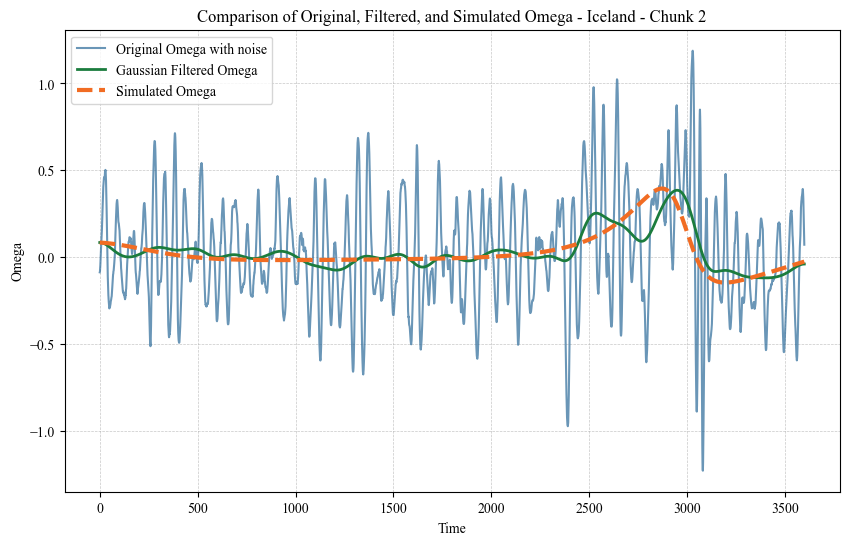

In [23]:
n=1
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(iceland_data[n]['omega_filtered'].values)[0], 
                      iceland_data[n]['omega_filtered'].iloc[0],0]

# Define time points for simulation
total_time = len(iceland_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = iceland_data[n]['omega'].values  # Replace 'omega' with the actual column name
omega_filtered = iceland_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 2)
simulate_sindy_model(iceland_models[n], initial_conditions, time_points, f'Iceland - Chunk {n+1}', omega_original, omega_filtered)


In [24]:
omega_ire_noise_filtered = apply_gaussian_filter(ire.omega, 'Ireland', sigma=60)
ireland_data = [chunk for chunk in omega_ire_noise_filtered if chunk['Region'].iloc[0] == 'Ireland']

In [25]:
ireland_mean,ireland_std = calculate_sindy_models_abs(ireland_data, 'Ireland',n=2)

Mean Coefficients for Ireland:
[[ 8.96668790e-05 -1.23869609e-05  9.98194076e-01  3.21865003e-06
   5.69968740e-09  1.59421895e-06  1.15990721e-08  5.66259975e-04
   2.97254692e-06  1.61002897e-09]
 [ 1.80738350e-04 -2.53528851e-05 -3.48467853e-03  6.55593354e-06
   1.08115822e-08  3.02446444e-06  2.33722608e-08  1.15227153e-03
   5.89836445e-06  3.26880630e-09]
 [ 1.00000000e+00  2.34916910e-17  6.17686529e-16  1.02983753e-16
  -3.46054923e-19 -7.17600311e-17  6.80656609e-19 -4.17444561e-15
   1.37637904e-16  8.43224167e-20]]
Standard Deviation of Coefficients for Ireland:
[[1.65054565e-03 1.63249623e-05 5.47067118e-03 4.84938625e-06
  6.18956593e-08 2.10020646e-05 1.89087934e-08 7.69914509e-03
  4.53114023e-06 3.14346434e-09]
 [3.27763143e-03 3.27716413e-05 1.08596330e-02 9.72554093e-06
  1.24004075e-07 4.15968756e-05 3.77637927e-08 1.53429582e-02
  9.01074665e-06 6.27657273e-09]
 [8.36690167e-15 1.36075334e-15 2.16085667e-14 2.97479940e-16
  3.94371113e-18 2.00062709e-15 1.39250759e

In [26]:
ireland_models = calculate_sindy_models(ireland_data, 'Ireland',n=2)

Model for Ireland - Chunk 1:
(theta)' = -0.0019533 1 + -0.0000262 theta + 0.9907796 omega + -0.0000013 time + -0.0000073 theta omega + -0.0128068 omega^2 + 0.0000051 omega time
(omega)' = -0.0038914 1 + -0.0000524 theta + -0.0185058 omega + -0.0000026 time + -0.0000001 theta^2 + -0.0000149 theta omega + -0.0257891 omega^2 + 0.0000104 omega time
(time)' = 1.0000000 1
Model Score: 0.5489232370393279

Model for Ireland - Chunk 2:
(theta)' = -0.0005105 1 + -0.0000161 theta + 1.0072834 omega + 0.0000035 time + 0.0000185 theta omega + -0.0182547 omega^2 + -0.0000052 omega time
(omega)' = -0.0010094 1 + -0.0000323 theta + 0.0145339 omega + 0.0000070 time + 0.0000372 theta omega + -0.0365272 omega^2 + -0.0000104 omega time
(time)' = 1.0000000 1
Model Score: 0.5943959430125633

Model for Ireland - Chunk 3:
(theta)' = -0.0004016 1 + -0.0000186 theta + 0.9951203 omega + -0.0000015 time + -0.0000062 theta omega + -0.0147171 omega^2 + 0.0000037 omega time
(omega)' = -0.0007963 1 + -0.0000377 theta 

Model Score: 0.5188031468613405

Model for Ireland - Chunk 24:
(theta)' = -0.0008692 1 + 0.0000023 theta + 1.0004359 omega + 0.0000008 time + 0.0000001 theta^2 + 0.0000061 theta omega + -0.0020481 omega^2 + -0.0000008 omega time
(omega)' = -0.0017335 1 + 0.0000046 theta + 0.0008835 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000121 theta omega + -0.0040826 omega^2 + -0.0000016 omega time
(time)' = 1.0000000 1
Model Score: 0.571180665745287

Model for Ireland - Chunk 25:
(theta)' = -0.0003404 1 + -0.0000116 theta + 1.0003005 omega + -0.0000003 time + -0.0000050 theta omega + 0.0039316 omega^2
(omega)' = -0.0006707 1 + -0.0000235 theta + 0.0006639 omega + -0.0000006 time + 0.0000001 theta^2 + -0.0000101 theta omega + 0.0078954 omega^2 + 0.0000001 omega time
(time)' = 1.0000000 1
Model Score: 0.5020308239394992

Model for Ireland - Chunk 26:
(theta)' = -0.0026733 1 + -0.0000021 theta + 0.9871015 omega + -0.0000009 time + 0.0000107 theta omega + -0.0100804 omega^2 + 0.0000083 omega tim

Model for Ireland - Chunk 46:
(theta)' = 0.0001101 1 + -0.0000254 theta + 0.9999035 omega + -0.0000068 time + 0.0000002 theta^2 + -0.0000349 theta omega + 0.0000001 theta time + 0.0010441 omega^2 + -0.0000079 omega time
(omega)' = 0.0002348 1 + -0.0000511 theta + -0.0001293 omega + -0.0000137 time + 0.0000003 theta^2 + -0.0000700 theta omega + 0.0000002 theta time + 0.0021086 omega^2 + -0.0000159 omega time
(time)' = 1.0000000 1
Model Score: 0.5570924073298772

Model for Ireland - Chunk 47:
(theta)' = -0.0002868 1 + -0.0000190 theta + 1.0005749 omega + -0.0000017 time + 0.0000051 theta omega + -0.0034233 omega^2 + -0.0000002 omega time
(omega)' = -0.0005643 1 + -0.0000383 theta + 0.0012374 omega + -0.0000034 time + -0.0000001 theta^2 + 0.0000102 theta omega + -0.0068218 omega^2 + -0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.5106074992661924

Model for Ireland - Chunk 48:
(theta)' = 0.0007973 1 + -0.0000202 theta + 0.9955899 omega + 0.0000062 time + -0.0000036 theta omega 

Model for Ireland - Chunk 70:
(theta)' = -0.0005917 1 + -0.0000431 theta + 1.0004490 omega + 0.0000071 time + -0.0000006 theta omega + 0.0043223 omega^2 + -0.0000008 omega time
(omega)' = -0.0011941 1 + -0.0000860 theta + 0.0009730 omega + 0.0000142 time + 0.0000001 theta^2 + -0.0000010 theta omega + 0.0085758 omega^2 + -0.0000016 omega time
(time)' = 1.0000000 1
Model Score: 0.5742520891219968

Model for Ireland - Chunk 71:
(theta)' = -0.0005369 1 + -0.0000462 theta + 0.9960585 omega + -0.0000070 time + -0.0000021 theta omega + -0.0076443 omega^2 + 0.0000033 omega time
(omega)' = -0.0010774 1 + -0.0000926 theta + -0.0078846 omega + -0.0000139 time + -0.0000001 theta^2 + -0.0000041 theta omega + -0.0153029 omega^2 + 0.0000066 omega time
(time)' = 1.0000000 1
Model Score: 0.5169106477119237

Model for Ireland - Chunk 72:
(theta)' = -0.0001681 1 + -0.0000135 theta + 0.9991835 omega + 0.0000031 time + 0.0000001 theta^2 + -0.0000055 theta omega + 0.0027179 omega^2 + 0.0000014 omega time
(o

Model for Ireland - Chunk 92:
(theta)' = -0.0003687 1 + -0.0000129 theta + 0.9940727 omega + -0.0000018 time + 0.0000001 theta^2 + -0.0000082 theta omega + -0.0212633 omega^2 + -0.0000016 omega time
(omega)' = -0.0007269 1 + -0.0000261 theta + -0.0117593 omega + -0.0000037 time + 0.0000002 theta^2 + -0.0000170 theta omega + 0.0000001 theta time + -0.0423948 omega^2 + -0.0000033 omega time
(time)' = 1.0000000 1
Model Score: 0.6063019192696725

Model for Ireland - Chunk 93:
(theta)' = 0.0004353 1 + -0.0000226 theta + 0.9949169 omega + -0.0000030 time + 0.0000127 theta omega + -0.0156213 omega^2 + 0.0000038 omega time
(omega)' = 0.0008713 1 + -0.0000455 theta + -0.0101314 omega + -0.0000059 time + 0.0000253 theta omega + -0.0312684 omega^2 + 0.0000076 omega time
(time)' = 1.0000000 1
Model Score: 0.5162228201227012

Model for Ireland - Chunk 94:
(theta)' = -0.0004406 1 + -0.0000020 theta + 1.0081723 omega + 0.0000013 time + -0.0000001 theta^2 + -0.0000080 theta omega + -0.0239881 omega^2 

Model for Ireland - Chunk 115:
(theta)' = 0.0001932 1 + -0.0000245 theta + 0.9972483 omega + 0.0000088 time + -0.0000044 theta omega + 0.0055916 omega^2 + 0.0000025 omega time
(omega)' = 0.0003895 1 + -0.0000490 theta + -0.0055354 omega + 0.0000176 time + -0.0000087 theta omega + 0.0112404 omega^2 + 0.0000051 omega time
(time)' = 1.0000000 1
Model Score: 0.626824577446181

Model for Ireland - Chunk 116:
(theta)' = 0.0010285 1 + -0.0000514 theta + 1.0034564 omega + -0.0000242 time + -0.0000051 theta omega + 0.0036834 omega^2 + -0.0000025 omega time
(omega)' = 0.0020857 1 + -0.0001028 theta + 0.0070069 omega + -0.0000484 time + -0.0000102 theta omega + 0.0074302 omega^2 + -0.0000050 omega time
(time)' = 1.0000000 1
Model Score: 0.5665156203191558

Model for Ireland - Chunk 117:
(theta)' = -0.0015911 1 + -0.0000150 theta + 1.0087911 omega + 0.0000052 time + -0.0000068 theta omega + -0.0085833 omega^2 + -0.0000044 omega time
(omega)' = -0.0031886 1 + -0.0000299 theta + 0.0176054 omega + 0.

Model Score: 0.4791723684702278

Model for Ireland - Chunk 138:
(theta)' = 0.0001053 1 + -0.0000070 theta + 0.9973680 omega + 0.0000010 time + -0.0000043 theta omega + 0.0051111 omega^2 + 0.0000019 omega time
(omega)' = 0.0002075 1 + -0.0000143 theta + -0.0052776 omega + 0.0000021 time + -0.0000084 theta omega + 0.0103005 omega^2 + 0.0000038 omega time
(time)' = 1.0000000 1
Model Score: 0.512654206031004

Model for Ireland - Chunk 139:
(theta)' = 0.0005778 1 + -0.0000199 theta + 0.9986070 omega + 0.0000016 time + -0.0000084 theta omega + 0.0014283 omega^2 + 0.0000008 omega time
(omega)' = 0.0011160 1 + -0.0000394 theta + -0.0026678 omega + 0.0000033 time + -0.0000172 theta omega + 0.0028892 omega^2 + 0.0000017 omega time
(time)' = 1.0000000 1
Model Score: 0.48204561262117646

Model for Ireland - Chunk 140:
(theta)' = -0.0018907 1 + -0.0000081 theta + 0.9881435 omega + -0.0000025 time + -0.0000065 theta omega + -0.0138094 omega^2
(omega)' = -0.0037620 1 + -0.0000163 theta + -0.0236112 o

Model for Ireland - Chunk 159:
(theta)' = 0.0039771 1 + -0.0000140 theta + 0.9839434 omega + 0.0000046 time + 0.0000036 theta omega + 0.0157975 omega^2 + 0.0000034 omega time
(omega)' = 0.0078881 1 + -0.0000278 theta + -0.0319227 omega + 0.0000092 time + 0.0000072 theta omega + 0.0314658 omega^2 + 0.0000067 omega time
(time)' = 1.0000000 1
Model Score: 0.5757671670527563

Model for Ireland - Chunk 160:
(theta)' = -0.0008831 1 + -0.0000124 theta + 0.9950370 omega + 0.0000012 time + 0.0000180 theta omega + 0.0278901 omega^2 + 0.0000003 omega time
(omega)' = -0.0017708 1 + -0.0000249 theta + -0.0099201 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000371 theta omega + 0.0558626 omega^2 + 0.0000004 omega time
(time)' = 1.0000000 1
Model Score: 0.6355846934360737

Model for Ireland - Chunk 161:
(theta)' = 0.0005834 1 + -0.0000195 theta + 0.9895654 omega + 0.0000018 time + -0.0000001 theta^2 + 0.0000177 theta omega + 0.0362931 omega^2 + -0.0000002 omega time
(omega)' = 0.0011705 1 + -0.000

Model Score: 0.48805310900191423

Model for Ireland - Chunk 184:
(theta)' = 0.0003598 1 + -0.0000193 theta + 1.0021015 omega + -0.0000017 time + -0.0000002 theta omega + 0.0035239 omega^2 + -0.0000009 omega time
(omega)' = 0.0007209 1 + -0.0000386 theta + 0.0042545 omega + -0.0000034 time + -0.0000001 theta^2 + -0.0000003 theta omega + 0.0071991 omega^2 + -0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.5472843402533464

Model for Ireland - Chunk 185:
(theta)' = 0.0003034 1 + -0.0000052 theta + 0.9973234 omega + 0.0000003 time + 0.0000136 theta omega + -0.0040334 omega^2 + 0.0000014 omega time
(omega)' = 0.0005984 1 + -0.0000107 theta + -0.0052630 omega + 0.0000006 time + -0.0000001 theta^2 + 0.0000268 theta omega + -0.0080942 omega^2 + 0.0000027 omega time
(time)' = 1.0000000 1
Model Score: 0.5084823932712752

Model for Ireland - Chunk 186:
(theta)' = -0.0057403 1 + 0.0000038 theta + 1.0136296 omega + 0.0000063 time + -0.0000159 theta omega + -0.0014533 omega^2 + -0.0000087 

Model for Ireland - Chunk 226:
(theta)' = -0.0009735 1 + 0.0000083 theta + 1.0042220 omega + 0.0000015 time + -0.0000141 theta omega + -0.0023511 omega^2 + -0.0000018 omega time
(omega)' = -0.0019557 1 + 0.0000164 theta + 0.0085193 omega + 0.0000030 time + -0.0000281 theta omega + -0.0047380 omega^2 + -0.0000037 omega time
(time)' = 1.0000000 1
Model Score: 0.4775952510044636

Model for Ireland - Chunk 227:
(theta)' = 0.0001995 1 + -0.0000210 theta + 1.0003700 omega + -0.0000018 time + 0.0000005 theta omega + -0.0038814 omega^2 + -0.0000002 omega time
(omega)' = 0.0004013 1 + -0.0000421 theta + 0.0007671 omega + -0.0000035 time + 0.0000008 theta omega + -0.0077185 omega^2 + -0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.5473197326628984

Model for Ireland - Chunk 228:
(theta)' = 0.0010855 1 + -0.0000020 theta + 0.9978150 omega + -0.0000020 time + 0.0000037 theta omega + 0.0000633 omega^2 + 0.0000009 omega time
(omega)' = 0.0021294 1 + -0.0000044 theta + -0.0042395 omega + -

Model for Ireland - Chunk 250:
(theta)' = 0.0004447 1 + -0.0000240 theta + 0.9994940 omega + -0.0000037 time + 0.0000335 theta omega + 0.0000292 omega^2 + 0.0000045 omega time
(omega)' = 0.0008938 1 + -0.0000478 theta + -0.0009665 omega + -0.0000074 time + 0.0000669 theta omega + 0.0000904 omega^2 + 0.0000090 omega time
(time)' = 1.0000000 1
Model Score: 0.5316920771906043

Model for Ireland - Chunk 251:
(theta)' = 0.0003076 1 + -0.0000046 theta + 1.0003722 omega + -0.0000001 time + -0.0000005 theta omega + 0.0008060 omega^2
(omega)' = 0.0006066 1 + -0.0000095 theta + 0.0007814 omega + -0.0000001 time + -0.0000010 theta omega + 0.0016045 omega^2
(time)' = 1.0000000 1
Model Score: 0.41044000630329797

Model for Ireland - Chunk 252:
(theta)' = 0.0006490 1 + -0.0000068 theta + 1.0002787 omega + 0.0000006 time + -0.0000026 theta omega + -0.0003132 omega^2
(omega)' = 0.0012820 1 + -0.0000137 theta + 0.0005935 omega + 0.0000012 time + -0.0000051 theta omega + -0.0006430 omega^2
(time)' = 1.0

Model for Ireland - Chunk 274:
(theta)' = 0.0010042 1 + -0.0000083 theta + 0.9979162 omega + -0.0000023 time + 0.0000012 theta omega + -0.0014795 omega^2 + 0.0000011 omega time
(omega)' = 0.0019922 1 + -0.0000167 theta + -0.0040956 omega + -0.0000045 time + 0.0000022 theta omega + -0.0029187 omega^2 + 0.0000023 omega time
(time)' = 1.0000000 1
Model Score: 0.4871238435392429

Model for Ireland - Chunk 275:
(theta)' = 0.0001196 1 + -0.0000075 theta + 1.0013144 omega + -0.0000010 time + -0.0000038 theta omega + 0.0011046 omega^2 + -0.0000007 omega time
(omega)' = 0.0002449 1 + -0.0000152 theta + 0.0026553 omega + -0.0000021 time + -0.0000075 theta omega + 0.0021797 omega^2 + -0.0000013 omega time
(time)' = 1.0000000 1
Model Score: 0.47118162460109425

Model for Ireland - Chunk 276:
(theta)' = 0.0022791 1 + -0.0000175 theta + 0.9895976 omega + 0.0000014 time + 0.0000071 theta omega + 0.0091634 omega^2 + 0.0000085 omega time
(omega)' = 0.0045660 1 + -0.0000352 theta + -0.0208446 omega + 0.

Model Score: 0.5425204118066437

Model for Ireland - Chunk 296:
(theta)' = -0.0052929 1 + -0.0000011 theta + 0.9937999 omega + 0.0000036 time + 0.0000002 theta^2 + -0.0000053 theta omega + 0.0000001 theta time + 0.0000323 omega^2 + 0.0000007 omega time
(omega)' = -0.0106149 1 + -0.0000022 theta + -0.0123702 omega + 0.0000072 time + 0.0000003 theta^2 + -0.0000110 theta omega + 0.0000002 theta time + 0.0001473 omega^2 + 0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.6331790232177475

Model for Ireland - Chunk 297:
(theta)' = 0.0005516 1 + 0.0000007 theta + 0.9963240 omega + -0.0000009 time + 0.0000101 theta omega + 0.0005250 omega^2 + 0.0000016 omega time
(omega)' = 0.0010904 1 + 0.0000012 theta + -0.0072861 omega + -0.0000019 time + 0.0000202 theta omega + 0.0010874 omega^2 + 0.0000032 omega time
(time)' = 1.0000000 1
Model Score: 0.4852443976890724

Model for Ireland - Chunk 298:
(theta)' = 0.0000834 1 + -0.0000064 theta + 0.9986928 omega + 0.0000003 time + 0.0000018 theta o

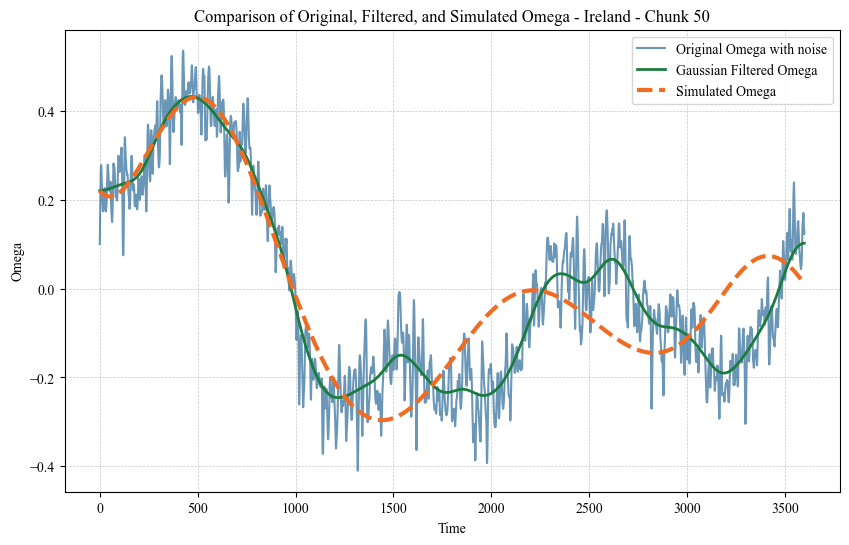

In [27]:
n=49
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(ireland_data[n]['omega_filtered'].values)[0], 
                      ireland_data[n]['omega_filtered'].iloc[0],0]

# Define time points for simulation
total_time = len(ireland_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = ireland_data[n]['omega'].values  # Replace 'omega' with the actual column name
omega_filtered = ireland_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 2)
simulate_sindy_model(ireland_models[n], initial_conditions, time_points, f'Ireland - Chunk {n+1}', omega_original, omega_filtered)


In [50]:
n=98
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(balearic_data[n]['omega_filtered'].values)[0], 
                      balearic_data[n]['omega_filtered'].iloc[0],0]

# Define time points for simulation
total_time = len(balearic_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
balearic_original = balearic_data[n]['omega'].values  

simulated_data = balearic_models[n].simulate(initial_conditions, time_points)
simulated_balearic = simulated_data[:, 1]

In [76]:
#n=9
n=2
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(iceland_data[n]['omega_filtered'].values)[0], 
                      iceland_data[n]['omega_filtered'].iloc[0],0]

# Define time points for simulation
total_time = len(iceland_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
iceland_original = iceland_data[n]['omega'].values 

simulated_data = iceland_models[n].simulate(initial_conditions, time_points)
simulated_iceland = simulated_data[:, 1]

In [77]:
n=49
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(ireland_data[n]['omega_filtered'].values)[0], 
                      ireland_data[n]['omega_filtered'].iloc[0],0]

# Define time points for simulation
total_time = len(ireland_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
ireland_original = ireland_data[n]['omega'].values  # Replace 'omega' with the actual column name
simulated_data = ireland_models[98].simulate(initial_conditions, time_points)
simulated_ireland = simulated_data[:, 1]

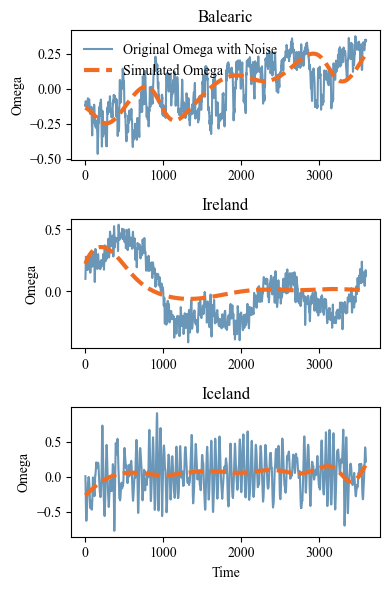

In [83]:
# Now, we can create subplots for each region
plt.figure(figsize=(4, 6))  # Total figure size

# Balearic subplot
plt.subplot(3, 1, 1)
plt.plot(time_points, balearic_original, label='Original Omega with Noise',color='#2b6a99', alpha=0.7)
plt.plot(time_points, simulated_balearic, label='Simulated Omega', color='#f16c23', linewidth=3, linestyle='--')
plt.title('Balearic')
plt.ylabel('Omega')
plt.legend(loc='upper left', frameon=False)

# Iceland subplot
plt.subplot(3, 1, 2)
plt.plot(time_points, ireland_original, label='Original Omega with Noise', color='#2b6a99', alpha=0.7)
plt.plot(time_points, simulated_ireland, label='Simulated Omega',color='#f16c23', linewidth=3, linestyle='--')
plt.title('Ireland')
plt.ylabel('Omega')
#plt.legend()

# Ireland subplot
plt.subplot(3, 1, 3)
plt.plot(time_points, iceland_original, label='Original Omega with Noise', color='#2b6a99', alpha=0.7)
plt.plot(time_points, simulated_iceland, label='Simulated Omega', color='#f16c23',linewidth=3, linestyle='--')
plt.title('Iceland')
plt.xlabel('Time')
plt.ylabel('Omega')
#plt.legend()

plt.tight_layout()
plt.show()


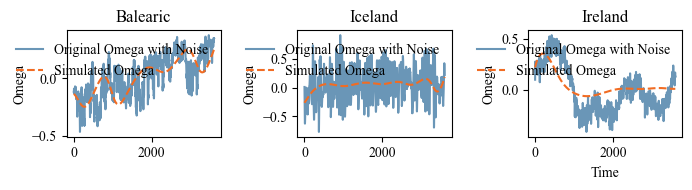

In [91]:
plt.figure(figsize=(7, 2))
# Balearic subplot
plt.subplot(1, 3, 1)
plt.plot(time_points, balearic_original, label='Original Omega with Noise', color='#2b6a99', alpha=0.7)
plt.plot(time_points, simulated_balearic, label='Simulated Omega', color='#f16c23', linestyle='--')
plt.title('Balearic')
plt.ylabel('Omega')
plt.legend(loc='upper right', frameon=False)

# Iceland subplot
plt.subplot(1, 3, 2)
plt.plot(time_points, iceland_original, label='Original Omega with Noise', color='#2b6a99', alpha=0.7)
plt.plot(time_points, simulated_iceland, label='Simulated Omega', color='#f16c23', linestyle='--')
plt.title('Iceland')
plt.ylabel('Omega')
plt.legend(loc='upper right', frameon=False)

# Ireland subplot
plt.subplot(1, 3, 3)
plt.plot(time_points, ireland_original, label='Original Omega with Noise', color='#2b6a99', alpha=0.7)
plt.plot(time_points, simulated_ireland, label='Simulated Omega', color='#f16c23', linestyle='--')
plt.title('Ireland')
plt.xlabel('Time')
plt.ylabel('Omega')
plt.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

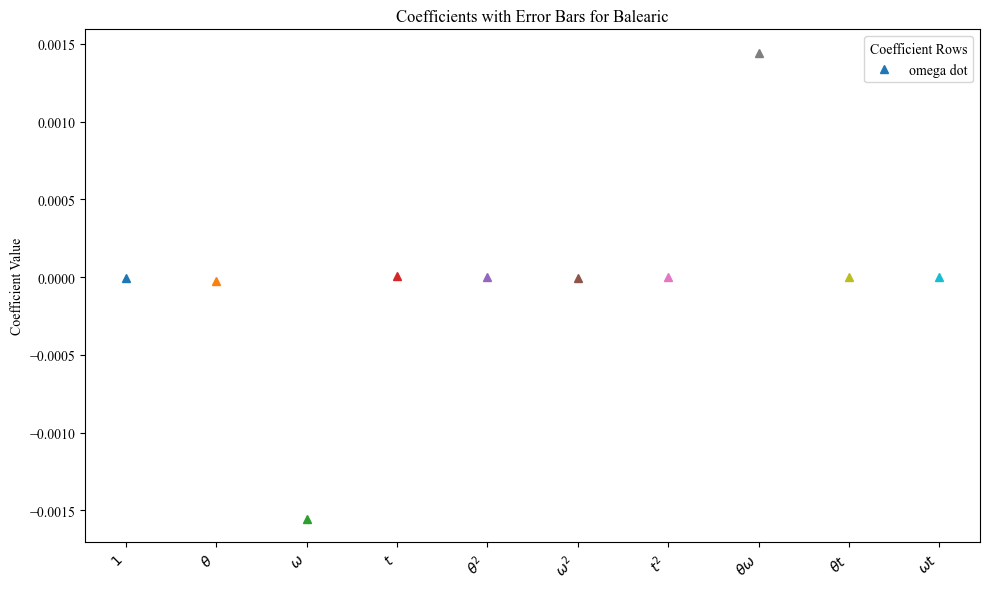

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_coefficients_with_error(means, stds, feature_names, region_name):
    # Number of features
    n_features = means.shape[1]

    # Create figure and axis
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Plotting
    for i in range(n_features):
        # Plot each feature's mean as a point and standard deviation as an error bar
        #ax.errorbar(i, means[0, i], yerr=stds[0, i], fmt='o', label='Row 1' if i == 0 else "")
        #ax.errorbar(i, means[1, i], yerr=stds[1, i], fmt='^', label='omega dot' if i == 0 else "")
        ax.errorbar(i, means[1, i], fmt='^', label='omega dot' if i == 0 else "")
        #ax.errorbar(i, means[2, i], yerr=stds[2, i], fmt='s', label='Row 3' if i == 0 else "")

    # Add legend, labels, title
    ax.legend(title="Coefficient Rows")
    ax.set_xticks(range(n_features))
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
    ax.set_ylabel("Coefficient Value")
    ax.set_title(f"Coefficients with Error Bars for {region_name}")

    plt.tight_layout()
    plt.show()

#feature_names = ["1", "theta", "omega", "time", "theta^2", "omega^2", "time^2", "theta omega", "theta time", "omega time"]
feature_names = ['$1$', r'$\theta$', r'$\omega$', r'$t$', 
                          r'$\theta^2$', r'$\omega^2$', r'$t^2$', 
                          r'$\theta\omega$', r'$\theta t$', r'$\omega t$']
# feature_names =['1',
#  'theta',
#  'omega',
#  'linear_time',
#  'theta^2',
#  'theta omega',
#  'theta linear_time',
#  'omega^2',
#  'omega linear_time',
#  'linear_time^2',
#  'theta^3',
#  'theta^2 omega',
#  'theta^2 linear_time',
#  'theta omega^2',
#  'theta omega linear_time',
#  'theta linear_time^2',
#  'omega^3',
#  'omega^2 linear_time',
#  'omega linear_time^2',
#  'linear_time^3']
plot_coefficients_with_error(np.array(balearic_mean), np.array(balearic_std), feature_names, "Balearic")


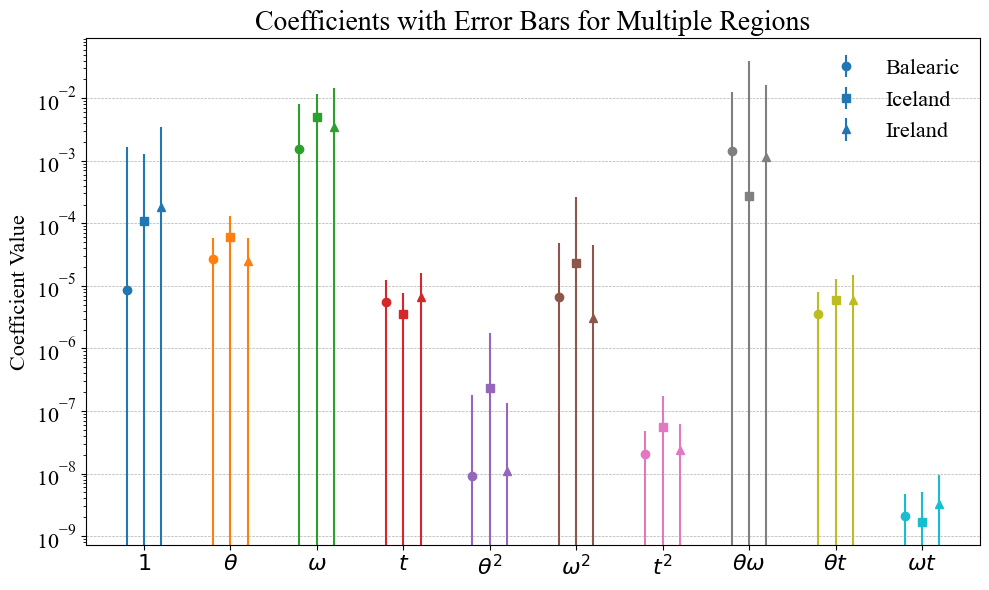

In [95]:
def plot_coefficients_for_regions(region_data, feature_names):
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    markers = ['o', 's', '^']
    region_names = list(region_data.keys())
    n_regions = len(region_names)
    bar_width = 0.2  # Width of space to allocate to each region's marker

    # Calculate the total width occupied by all the regions' markers
    total_width = bar_width * n_regions

    # Calculate the offset to center the feature names
    center_offset = total_width / 2 - bar_width / 2

    for region_name, data in region_data.items():
        means, stds = data['means'], data['stds']
        n_features = means.shape[1]
        
        # Select the marker for the region
        marker = markers[region_names.index(region_name) % len(markers)]
        region_offset = bar_width * region_names.index(region_name)

        for i in range(n_features):
            # Apply offset for each region to center the markers
            ax.errorbar(i + region_offset, np.abs(means[1, i]), yerr=stds[1, i], fmt=marker, label=region_name if i == 0 else "")

    ax.legend(fontsize=16, title_fontsize=16, frameon=False)
    ax.set_xticks(np.arange(n_features) + center_offset)
    ax.set_xticklabels(feature_names, fontsize=16)
    ax.set_ylabel("Coefficient Value", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title("Coefficients with Error Bars for Multiple Regions", fontsize=20)
    
    ax.set_yscale('log')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()


region_data = {
    "Balearic": {"means": np.array(balearic_mean), "stds": np.array(balearic_std)},
    "Iceland": {"means": np.array(iceland_mean), "stds": np.array(iceland_std)},
    "Ireland": {"means": np.array(ireland_mean), "stds": np.array(ireland_std)}
}

feature_names = ['$1$', r'$\theta$', r'$\omega$', r'$t$', 
                          r'$\theta^2$', r'$\omega^2$', r'$t^2$', 
                          r'$\theta\omega$', r'$\theta t$', r'$\omega t$']
plot_coefficients_for_regions(region_data, feature_names)


In [204]:
region_data

{'Balearic': {'means': array([[ 8.97030811e-07, -1.28911426e-05,  9.99086040e-01,
           2.62123764e-06,  7.62339467e-09, -3.28690201e-06,
           9.93852905e-09,  8.00605754e-04,  1.72095453e-06,
           9.51993618e-10],
         [-8.68839033e-06, -2.68121239e-05, -1.55561353e-03,
           5.45784730e-06,  9.29321279e-09, -6.68916919e-06,
           2.08246500e-08,  1.44294484e-03,  3.49432192e-06,
           2.06552917e-09],
         [ 1.00000000e+00,  4.33457505e-16,  3.11123057e-15,
           7.26334694e-17, -7.48674043e-20, -4.15847088e-17,
           7.44824034e-19, -5.58704655e-15,  7.35777915e-17,
           6.73610500e-20]]),
  'stds': array([[8.44077962e-04, 1.50665626e-05, 3.27696163e-03, 3.38600799e-06,
          8.46883345e-08, 2.08695335e-05, 1.35758608e-08, 5.61472193e-03,
          2.27927360e-06, 1.29978273e-09],
         [1.66840474e-03, 3.09644514e-05, 6.51246104e-03, 6.87981950e-06,
          1.71921908e-07, 4.16398560e-05, 2.74893946e-08, 1.11493855e-0

In [15]:
balearic_data = [chunk for chunk in gaussian_filtered_data if chunk['Region'].iloc[0] == 'Balearic']

# Initialize an empty list for sindy_models
sindy_models = []

# Iterate over each chunk
for chunk in balearic_data:
    # Integrate omega_filtered to get theta
    theta_chunk = integrate_data(chunk['omega_filtered'].values)

    # Stack normalized theta and omega_filtered
    stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))

    # Generate time values
    t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

    # Add time as a linear feature
    linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
    x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])

    # Feature names for SINDy (including a linear term for time)
    feature_names_chunk = ["theta", "omega", "time"]

    # Use Polynomial Library 
    polynomial_library_chunk = ps.PolynomialLibrary(degree=2)

    # Sparse regression optimizer
    sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

    # Create a SINDy model with the polynomial library
    model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                           feature_library=polynomial_library_chunk,
                           optimizer=sparse_regression_optimizer_chunk)

    # Fit the SINDy model using the chunk data
    model_chunk.fit(x_train_augmented_chunk, t=1)

    # Append the SINDy model to the list
    sindy_models.append(model_chunk)

    # Print the learned model for the current chunk
    print(f"Model for Chunk {len(sindy_models)}:")
    model_chunk.print(precision=7)
    print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
    print()


Model for Chunk 1:
(theta)' = 0.0003765 1 + -0.0000748 theta + 1.0009264 omega + -0.0000143 time + -0.0000009 theta^2 + -0.0000564 theta omega + -0.0000001 theta time + -0.0161738 omega^2 + -0.0000251 omega time
(omega)' = 0.0007690 1 + -0.0001515 theta + 0.0019350 omega + -0.0000289 time + -0.0000018 theta^2 + -0.0001132 theta omega + -0.0000002 theta time + -0.0325477 omega^2 + -0.0000502 omega time
(time)' = 1.0000000 1
Model Score: 0.6666635413142217

Model for Chunk 2:
(theta)' = -0.0001184 1 + 0.0000453 theta + 1.0077089 omega + -0.0000001 time + -0.0000009 theta^2 + 0.0014620 theta omega + -0.0000001 theta time + 0.0256000 omega^2 + -0.0000731 omega time
(omega)' = -0.0002401 1 + 0.0000885 theta + 0.0156312 omega + -0.0000001 time + -0.0000017 theta^2 + 0.0029187 theta omega + -0.0000003 theta time + 0.0527337 omega^2 + -0.0001462 omega time
(time)' = 1.0000000 1
Model Score: 0.6664448320780895

Model for Chunk 3:
(theta)' = -0.0002180 1 + -0.0001806 theta + 1.0082765 omega + 0.

Model Score: 0.6666664527860379

Model for Chunk 41:
(theta)' = 0.0000600 1 + -0.0001929 theta + 1.0026657 omega + -0.0000068 time + -0.0000006 theta^2 + 0.0000159 theta omega + 0.0000002 theta time + -0.0090125 omega^2 + 0.0000141 omega time
(omega)' = 0.0001258 1 + -0.0003897 theta + 0.0054728 omega + -0.0000137 time + -0.0000012 theta^2 + 0.0000313 theta omega + 0.0000005 theta time + -0.0182002 omega^2 + 0.0000285 omega time
(time)' = 1.0000000 1
Model Score: 0.6666649416148472

Model for Chunk 42:
(theta)' = -0.0005063 1 + -0.0002435 theta + 1.0086011 omega + 0.0000154 time + -0.0000019 theta^2 + -0.0000605 theta omega + 0.0000007 theta time + -0.0249622 omega^2 + 0.0000158 omega time
(omega)' = -0.0010217 1 + -0.0004884 theta + 0.0173521 omega + 0.0000309 time + -0.0000038 theta^2 + -0.0001209 theta omega + 0.0000014 theta time + -0.0499741 omega^2 + 0.0000316 omega time + -0.0000001 time^2
(time)' = 1.0000000 1
Model Score: 0.6666623412087649

Model for Chunk 43:
(theta)' = -0.0

Model Score: 0.6657533023408096

Model for Chunk 78:
(theta)' = -0.0578453 1 + -0.0010270 theta + 0.6298226 omega + -0.0003615 time + -0.0000625 theta^2 + -0.0026979 theta omega + -0.0000413 theta time + -0.5920616 omega^2 + -0.0009651 omega time + -0.0000068 time^2
(omega)' = -0.1162409 1 + -0.0020687 theta + -0.7441161 omega + -0.0007281 time + -0.0001258 theta^2 + -0.0054372 theta omega + -0.0000831 theta time + -1.1904972 omega^2 + -0.0019449 omega time + -0.0000137 time^2
(time)' = 1.0000000 1
Model Score: 0.66601380735835

Model for Chunk 79:
(theta)' = 0.0013856 1 + 0.0002896 theta + 1.0089377 omega + 0.0001019 time + 0.0000009 theta^2 + -0.0000321 theta omega + 0.0000001 theta time + 0.0140640 omega^2 + -0.0000243 omega time + -0.0000001 time^2
(omega)' = 0.0027320 1 + 0.0005801 theta + 0.0177850 omega + 0.0002042 time + 0.0000018 theta^2 + -0.0000644 theta omega + 0.0000003 theta time + 0.0281713 omega^2 + -0.0000484 omega time + -0.0000001 time^2
(time)' = 1.0000000 1
Model S

Model Score: 0.6666652681376061

Model for Chunk 116:
(theta)' = -0.0080413 1 + -0.0001440 theta + 0.9403207 omega + -0.0000107 time + 0.0000002 theta^2 + 0.0000106 theta omega + -0.0000001 theta time + -0.0851466 omega^2 + 0.0000821 omega time
(omega)' = -0.0161826 1 + -0.0003000 theta + -0.1201789 omega + -0.0000230 time + 0.0000003 theta^2 + 0.0000185 theta omega + -0.0000002 theta time + -0.1717997 omega^2 + 0.0001668 omega time
(time)' = 1.0000000 1
Model Score: 0.6666641232033764

Model for Chunk 117:
(theta)' = -0.0001644 1 + -0.0001136 theta + 1.0033271 omega + 0.0000041 time + 0.0000028 theta^2 + -0.0000683 theta omega + 0.0000001 theta time + 0.0409832 omega^2 + -0.0000042 omega time
(omega)' = -0.0003303 1 + -0.0002281 theta + 0.0066761 omega + 0.0000083 time + 0.0000056 theta^2 + -0.0001348 theta omega + 0.0000001 theta time + 0.0826941 omega^2 + -0.0000081 omega time
(time)' = 1.0000000 1
Model Score: 0.6666514153394479

Model for Chunk 118:
(theta)' = -0.0004813 1 + 0.000

Model for Chunk 154:
(theta)' = 0.0005404 1 + -0.0000890 theta + 0.9916391 omega + 0.0000148 time + 0.0000034 theta^2 + 0.0000130 theta omega + -0.0000010 theta time + 0.0316321 omega^2 + -0.0000041 omega time + 0.0000001 time^2
(omega)' = 0.0009974 1 + -0.0001763 theta + -0.0157112 omega + 0.0000293 time + 0.0000066 theta^2 + 0.0000201 theta omega + -0.0000019 theta time + 0.0601878 omega^2 + -0.0000072 omega time + 0.0000001 time^2
(time)' = 1.0000000 1
Model Score: 0.6666660965556052

Model for Chunk 155:
(theta)' = -0.0018300 1 + 0.0000994 theta + 1.0097392 omega + -0.0000174 time + -0.0000001 theta^2 + 0.0000003 theta omega + -0.0080485 omega^2 + -0.0000255 omega time
(omega)' = -0.0037238 1 + 0.0002042 theta + 0.0203449 omega + -0.0000363 time + -0.0000003 theta^2 + 0.0000048 theta omega + -0.0000001 theta time + -0.0186385 omega^2 + -0.0000511 omega time
(time)' = 1.0000000 1
Model Score: 0.6666662747488327

Model for Chunk 156:
(theta)' = -0.0119742 1 + -0.0002939 theta + 0.948

Model for Chunk 192:
(theta)' = -0.0007666 1 + -0.0001644 theta + 1.0063610 omega + 0.0000198 time + -0.0000005 theta^2 + -0.0001302 theta omega + 0.0000004 theta time + -0.0025075 omega^2 + 0.0000216 omega time
(omega)' = -0.0015370 1 + -0.0003275 theta + 0.0127339 omega + 0.0000394 time + -0.0000010 theta^2 + -0.0002587 theta omega + 0.0000007 theta time + -0.0048368 omega^2 + 0.0000429 omega time + -0.0000001 time^2
(time)' = 1.0000000 1
Model Score: 0.6666611750393444

Model for Chunk 193:
(theta)' = -0.0001939 1 + -0.0000339 theta + 1.0019978 omega + 0.0000007 time + 0.0000001 theta^2 + 0.0000285 theta omega + 0.0015565 omega^2 + -0.0000013 omega time
(omega)' = -0.0003874 1 + -0.0000695 theta + 0.0040069 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000574 theta omega + 0.0031814 omega^2 + -0.0000021 omega time
(time)' = 1.0000000 1
Model Score: 0.6666658599164648

Model for Chunk 194:
(theta)' = 0.0007202 1 + -0.0000020 theta + 0.9957299 omega + -0.0000037 time + -0.0000002 th

Model for Chunk 231:
(theta)' = 0.0004012 1 + -0.0001081 theta + 0.9867308 omega + 0.0000298 time + 0.0000028 theta^2 + 0.0000879 theta omega + -0.0000011 theta time + 0.0430287 omega^2 + -0.0000281 omega time + 0.0000001 time^2
(omega)' = 0.0006982 1 + -0.0002165 theta + -0.0262559 omega + 0.0000599 time + 0.0000056 theta^2 + 0.0001746 theta omega + -0.0000022 theta time + 0.0864255 omega^2 + -0.0000565 omega time + 0.0000002 time^2
(time)' = 1.0000000 1
Model Score: 0.6666610996703152

Model for Chunk 232:
(theta)' = 0.0005413 1 + 0.0000143 theta + 0.9916424 omega + -0.0000019 time + 0.0000038 theta^2 + -0.0000110 theta omega + -0.0000014 theta time + 0.0308495 omega^2 + -0.0000038 omega time + 0.0000001 time^2
(omega)' = 0.0010478 1 + 0.0000269 theta + -0.0164243 omega + -0.0000035 time + 0.0000075 theta^2 + -0.0000243 theta omega + -0.0000028 theta time + 0.0612352 omega^2 + -0.0000072 omega time + 0.0000003 time^2
(time)' = 1.0000000 1
Model Score: 0.6666661509430406

Model for Ch

Model for Chunk 270:
(theta)' = 0.0013286 1 + 0.0000138 theta + 1.0191721 omega + 0.0000014 time + 0.0000074 theta^2 + 0.0003642 theta omega + 0.0000018 theta time + 0.0676086 omega^2 + 0.0000412 omega time + 0.0000001 time^2
(omega)' = 0.0026685 1 + 0.0000275 theta + 0.0385172 omega + 0.0000028 time + 0.0000150 theta^2 + 0.0007306 theta omega + 0.0000037 theta time + 0.1358828 omega^2 + 0.0000828 omega time + 0.0000002 time^2
(time)' = 1.0000000 1
Model Score: 0.666608495091631

Model for Chunk 271:
(theta)' = -0.0000961 1 + -0.0001923 theta + 0.9966069 omega + -0.0000512 time + -0.0000003 theta^2 + 0.0000199 theta omega + -0.0105285 omega^2 + 0.0000257 omega time
(omega)' = -0.0001767 1 + -0.0003873 theta + -0.0067374 omega + -0.0001031 time + -0.0000007 theta^2 + 0.0000402 theta omega + 0.0000001 theta time + -0.0210614 omega^2 + 0.0000519 omega time + 0.0000001 time^2
(time)' = 1.0000000 1
Model Score: 0.6666666441118397

Model for Chunk 272:
(theta)' = -0.0003880 1 + -0.0000468 th

Model for Chunk 311:
(theta)' = 0.0004802 1 + -0.0000758 theta + 1.0035679 omega + -0.0000100 time + 0.0000118 theta omega + -0.0015507 omega^2 + 0.0000055 omega time
(omega)' = 0.0009494 1 + -0.0001539 theta + 0.0070658 omega + -0.0000201 time + 0.0000237 theta omega + 0.0000001 theta time + -0.0029317 omega^2 + 0.0000118 omega time
(time)' = 1.0000000 1
Model Score: 0.6666665808619352

Model for Chunk 312:
(theta)' = -0.0010436 1 + -0.0000276 theta + 1.0025568 omega + 0.0000007 time + 0.0000001 theta^2 + 0.0000059 theta omega + 0.0000001 theta time + 0.0022061 omega^2 + -0.0000014 omega time
(omega)' = -0.0023502 1 + -0.0000557 theta + 0.0059008 omega + 0.0000018 time + 0.0000002 theta^2 + 0.0000122 theta omega + 0.0000001 theta time + 0.0046040 omega^2 + -0.0000035 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666383443745

Model for Chunk 313:
(theta)' = -0.0000541 1 + -0.0000503 theta + 1.0008474 omega + 0.0000090 time + -0.0000048 theta omega + 0.0015606 omega^2 + 0.0000024

Model Score: 0.6666499039244805

Model for Chunk 350:
(theta)' = -0.0002969 1 + -0.0000836 theta + 0.9888230 omega + 0.0000188 time + 0.0000046 theta^2 + -0.0003628 theta omega + -0.0000014 theta time + 0.0692373 omega^2 + 0.0000489 omega time + 0.0000001 time^2
(omega)' = -0.0002716 1 + -0.0001664 theta + -0.0254126 omega + 0.0000371 time + 0.0000092 theta^2 + -0.0007331 theta omega + -0.0000029 theta time + 0.1455862 omega^2 + 0.0001009 omega time + 0.0000002 time^2
(time)' = 1.0000000 1
Model Score: 0.6666654170019607

Model for Chunk 351:
(theta)' = -0.0001184 1 + -0.0000633 theta + 1.0106785 omega + 0.0000038 time + -0.0000113 theta^2 + 0.0002871 theta omega + 0.0000019 theta time + -0.0957697 omega^2 + -0.0000085 omega time + -0.0000001 time^2
(omega)' = -0.0002312 1 + -0.0001257 theta + 0.0210609 omega + 0.0000074 time + -0.0000224 theta^2 + 0.0005605 theta omega + 0.0000038 theta time + -0.1890831 omega^2 + -0.0000159 omega time + -0.0000002 time^2
(time)' = 1.0000000 1
Model S

Model Score: 0.6666666492533566

Model for Chunk 389:
(theta)' = -0.0024622 1 + -0.0000826 theta + 0.9653586 omega + -0.0000066 time + -0.0000152 theta^2 + 0.0005256 theta omega + -0.0000039 theta time + -0.1111222 omega^2 + 0.0000901 omega time + -0.0000003 time^2
(omega)' = -0.0048719 1 + -0.0001657 theta + -0.0686247 omega + -0.0000133 time + -0.0000302 theta^2 + 0.0010442 theta omega + -0.0000077 theta time + -0.2205383 omega^2 + 0.0001789 omega time + -0.0000005 time^2
(time)' = 1.0000000 1
Model Score: 0.6664922790677711

Model for Chunk 390:
(theta)' = 0.0001208 1 + -0.0000931 theta + 0.9968614 omega + 0.0000100 time + 0.0000005 theta^2 + -0.0000108 theta omega + 0.0200070 omega^2 + 0.0000080 omega time
(omega)' = 0.0002206 1 + -0.0001946 theta + -0.0059969 omega + 0.0000206 time + 0.0000008 theta^2 + -0.0000234 theta omega + 0.0393479 omega^2 + 0.0000179 omega time
(time)' = 1.0000000 1
Model Score: 0.6666568878456366

Model for Chunk 391:
(theta)' = -0.0001212 1 + -0.0001582 t

Model for Chunk 428:
(theta)' = -0.0011930 1 + -0.0000164 theta + 0.9908461 omega + 0.0000049 time + 0.0000004 theta^2 + 0.0000239 theta omega + -0.0000003 theta time + 0.0042847 omega^2 + -0.0000013 omega time
(omega)' = -0.0024305 1 + -0.0000319 theta + -0.0185423 omega + 0.0000097 time + 0.0000008 theta^2 + 0.0000503 theta omega + -0.0000005 theta time + 0.0091927 omega^2 + -0.0000028 omega time + 0.0000001 time^2
(time)' = 1.0000000 1
Model Score: 0.6666665593322793

Model for Chunk 429:
(theta)' = 0.0003584 1 + -0.0000083 theta + 0.9929072 omega + 0.0000010 time + 0.0000001 theta^2 + -0.0000676 theta omega + -0.0000001 theta time + 0.0022086 omega^2 + 0.0000180 omega time
(omega)' = 0.0006976 1 + -0.0000168 theta + -0.0138323 omega + 0.0000020 time + 0.0000002 theta^2 + -0.0001345 theta omega + -0.0000001 theta time + 0.0044303 omega^2 + 0.0000354 omega time
(time)' = 1.0000000 1
Model Score: 0.6666657787549713

Model for Chunk 430:
(theta)' = 0.0025809 1 + -0.0003303 theta + 0.97

In [16]:
# Initialize empty lists for coefficient matrices
coefficients_matrices = []

# Iterate over each SINDy model in sindy_models
for model in sindy_models:
    # Get the coefficients from the model
    coefficients = model.coefficients()

    # Append the coefficients to the list
    coefficients_matrices.append(coefficients)

# Convert the list of matrices to a 3D NumPy array
coefficients_array = np.array(coefficients_matrices)

# Calculate mean and standard deviation along the first axis (axis=0) which corresponds to chunks
mean_coefficients = np.mean(coefficients_array, axis=0)
std_coefficients = np.std(coefficients_array, axis=0)

# Print or use mean_coefficients and std_coefficients as needed
print("Mean Coefficients:")
print(mean_coefficients)
print("\nStandard Deviation of Coefficients:")
print(std_coefficients)


Mean Coefficients:
[[-4.22080230e-04 -5.39314721e-05  1.00134438e+00  7.89742140e-07
  -1.76857151e-07  7.32361750e-08 -1.96543032e-07 -2.25521513e-03
  -5.49869177e-06 -3.25414456e-08]
 [-8.41850769e-04 -1.08868569e-04  2.94364665e-03  1.49136394e-06
  -3.57389018e-07 -1.06564794e-08 -3.92397330e-07 -4.50005216e-03
  -1.11725204e-05 -6.50346065e-08]
 [ 1.00000000e+00  1.01667199e-15 -7.31251906e-14 -1.41010794e-16
   1.64666339e-17 -2.45596116e-15  2.42512517e-18  1.09483435e-13
   1.75483013e-16  3.33714836e-18]]

Standard Deviation of Coefficients:
[[7.15944866e-03 1.94162729e-04 3.45078866e-02 4.60281947e-05
  6.47439849e-06 3.31886899e-04 3.04336425e-06 7.21536671e-02
  1.01260485e-04 5.11530788e-07]
 [1.42105949e-02 3.86035218e-04 6.90734100e-02 9.18277220e-05
  1.29636410e-05 6.64116751e-04 6.09625083e-06 1.44532278e-01
  2.02558364e-04 1.02280434e-06]
 [5.11102318e-13 1.09218897e-14 1.63653251e-12 4.19845600e-15
  6.00937995e-16 9.60725080e-15 2.22903605e-16 2.40698681e-12
  5.

In [49]:
len(coefficients_array)

455

In [22]:
def calculate_sindy_models(region_data, region_name):
    # Initialize an empty list for sindy_models
    sindy_models = []

    # Iterate over each chunk
    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = integrate_data(chunk['omega_filtered'].values)

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "linear_time"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=2)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        model_chunk.print(precision=7)
        print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        print()

    # Initialize empty lists for coefficient matrices
    coefficients_matrices = []

    # Iterate over each SINDy model in sindy_models
    for model in sindy_models:
        # Get the coefficients from the model
        coefficients = model.coefficients()

        # Append the coefficients to the list
        coefficients_matrices.append(coefficients)

    # Convert the list of matrices to a 3D NumPy array
    coefficients_array = np.array(coefficients_matrices)

    # Calculate mean and standard deviation along the first axis (axis=0) which corresponds to chunks
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    # Print or use mean_coefficients and std_coefficients as needed
    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients Coefficients for {region_name}:")
    print(std_coefficients)
    
    return sindy_models


In [31]:
def simulate_sindy_model(model, initial_conditions, time_points, title, omega_original, omega_filtered):
    # Simulate the system using the provided model
    simulated_data = model.simulate(initial_conditions, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plot the simulation results
    plt.figure(figsize=(10, 6))

    # Plot the original Omega with noise
    plt.plot(omega_original, label='Original Omega with noise', alpha=0.7, color='#2b6a99')

    # Plot the Gaussian Filtered Omega
    plt.plot(omega_filtered, label='Gaussian Filtered Omega', linestyle='-', linewidth=2, color='#1b7c3d')

    # Plot the simulated Omega
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3, color='#f16c23')

    plt.title(f'Comparison of Original, Filtered, and Simulated Omega - {title}')
    plt.xlabel('Time')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()


In [26]:
# for 'Balearic' region
balearic_data = [chunk for chunk in gaussian_filtered_data if chunk['Region'].iloc[0] == 'Balearic']
balearic_models = calculate_sindy_models(balearic_data, 'Balearic')

Model for Balearic - Chunk 1:
(theta)' = 0.0003765 1 + -0.0000748 theta + 1.0009264 omega + -0.0000143 linear_time + -0.0000009 theta^2 + -0.0000564 theta omega + -0.0000001 theta linear_time + -0.0161738 omega^2 + -0.0000251 omega linear_time
(omega)' = 0.0007690 1 + -0.0001515 theta + 0.0019350 omega + -0.0000289 linear_time + -0.0000018 theta^2 + -0.0001132 theta omega + -0.0000002 theta linear_time + -0.0325477 omega^2 + -0.0000502 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666635413142217

Model for Balearic - Chunk 2:
(theta)' = -0.0001184 1 + 0.0000453 theta + 1.0077089 omega + -0.0000001 linear_time + -0.0000009 theta^2 + 0.0014620 theta omega + -0.0000001 theta linear_time + 0.0256000 omega^2 + -0.0000731 omega linear_time
(omega)' = -0.0002401 1 + 0.0000885 theta + 0.0156312 omega + -0.0000001 linear_time + -0.0000017 theta^2 + 0.0029187 theta omega + -0.0000003 theta linear_time + 0.0527337 omega^2 + -0.0001462 omega linear_time
(linear_time)' = 1.0000000

Model Score: 0.6666642288639301

Model for Balearic - Chunk 40:
(theta)' = -0.0026939 1 + -0.0000639 theta + 0.9896061 omega + -0.0000532 linear_time + -0.0000006 theta^2 + 0.0000215 theta omega + -0.0000007 theta linear_time + -0.0092048 omega^2 + 0.0000096 omega linear_time + -0.0000002 linear_time^2
(omega)' = -0.0054177 1 + -0.0001281 theta + -0.0209307 omega + -0.0001064 linear_time + -0.0000012 theta^2 + 0.0000440 theta omega + -0.0000014 theta linear_time + -0.0185458 omega^2 + 0.0000201 omega linear_time + -0.0000004 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666664527860379

Model for Balearic - Chunk 41:
(theta)' = 0.0000600 1 + -0.0001929 theta + 1.0026657 omega + -0.0000068 linear_time + -0.0000006 theta^2 + 0.0000159 theta omega + 0.0000002 theta linear_time + -0.0090125 omega^2 + 0.0000141 omega linear_time
(omega)' = 0.0001258 1 + -0.0003897 theta + 0.0054728 omega + -0.0000137 linear_time + -0.0000012 theta^2 + 0.0000313 theta omega + 0.0000005 theta lin

Model for Balearic - Chunk 76:
(theta)' = -0.0006179 1 + -0.0000754 theta + 0.9968118 omega + -0.0000134 linear_time + -0.0000006 theta^2 + -0.0000017 theta omega + -0.0000003 theta linear_time + 0.0010447 omega^2 + 0.0000082 omega linear_time
(omega)' = -0.0011955 1 + -0.0001521 theta + -0.0061237 omega + -0.0000270 linear_time + -0.0000013 theta^2 + -0.0000106 theta omega + -0.0000006 theta linear_time + 0.0022925 omega^2 + 0.0000146 omega linear_time + -0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.666661707581416

Model for Balearic - Chunk 77:
(theta)' = -0.0355982 1 + 0.0014191 theta + 0.8114709 omega + 0.0004721 linear_time + -0.0000340 theta^2 + 0.0049222 theta omega + -0.0000217 theta linear_time + -0.2345327 omega^2 + 0.0016330 omega linear_time + -0.0000035 linear_time^2
(omega)' = -0.0708596 1 + 0.0028332 theta + -0.3751700 omega + 0.0009427 linear_time + -0.0000677 theta^2 + 0.0098295 theta omega + -0.0000432 theta linear_time + -0.4664981 omega^2 + 0

Model Score: 0.6666652681376061

Model for Balearic - Chunk 116:
(theta)' = -0.0080413 1 + -0.0001440 theta + 0.9403207 omega + -0.0000107 linear_time + 0.0000002 theta^2 + 0.0000106 theta omega + -0.0000001 theta linear_time + -0.0851466 omega^2 + 0.0000821 omega linear_time
(omega)' = -0.0161826 1 + -0.0003000 theta + -0.1201789 omega + -0.0000230 linear_time + 0.0000003 theta^2 + 0.0000185 theta omega + -0.0000002 theta linear_time + -0.1717997 omega^2 + 0.0001668 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666641232033764

Model for Balearic - Chunk 117:
(theta)' = -0.0001644 1 + -0.0001136 theta + 1.0033271 omega + 0.0000041 linear_time + 0.0000028 theta^2 + -0.0000683 theta omega + 0.0000001 theta linear_time + 0.0409832 omega^2 + -0.0000042 omega linear_time
(omega)' = -0.0003303 1 + -0.0002281 theta + 0.0066761 omega + 0.0000083 linear_time + 0.0000056 theta^2 + -0.0001348 theta omega + 0.0000001 theta linear_time + 0.0826941 omega^2 + -0.0000081 omega linear

Model for Balearic - Chunk 155:
(theta)' = -0.0018300 1 + 0.0000994 theta + 1.0097392 omega + -0.0000174 linear_time + -0.0000001 theta^2 + 0.0000003 theta omega + -0.0080485 omega^2 + -0.0000255 omega linear_time
(omega)' = -0.0037238 1 + 0.0002042 theta + 0.0203449 omega + -0.0000363 linear_time + -0.0000003 theta^2 + 0.0000048 theta omega + -0.0000001 theta linear_time + -0.0186385 omega^2 + -0.0000511 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666662747488327

Model for Balearic - Chunk 156:
(theta)' = -0.0119742 1 + -0.0002939 theta + 0.9489654 omega + -0.0000568 linear_time + -0.0000004 theta^2 + -0.0000450 theta omega + -0.0000001 theta linear_time + -0.0394031 omega^2 + 0.0000909 omega linear_time
(omega)' = -0.0217713 1 + -0.0005512 theta + -0.0936141 omega + -0.0001074 linear_time + -0.0000007 theta^2 + -0.0000807 theta omega + -0.0000002 theta linear_time + -0.0743227 omega^2 + 0.0001683 omega linear_time + 0.0000001 linear_time^2
(linear_time)' = 1.00000

Model for Balearic - Chunk 194:
(theta)' = 0.0007202 1 + -0.0000020 theta + 0.9957299 omega + -0.0000037 linear_time + -0.0000002 theta^2 + -0.0000276 theta omega + -0.0000001 theta linear_time + -0.0003090 omega^2 + 0.0000010 omega linear_time
(omega)' = 0.0013541 1 + -0.0000065 theta + -0.0079222 omega + -0.0000069 linear_time + -0.0000003 theta^2 + -0.0000555 theta omega + -0.0000002 theta linear_time + -0.0011003 omega^2 + 0.0000016 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666661051671577

Model for Balearic - Chunk 195:
(theta)' = -0.0022395 1 + -0.0000104 theta + 1.0225687 omega + 0.0000047 linear_time + -0.0000067 theta^2 + 0.0000096 theta omega + 0.0000028 theta linear_time + -0.0567335 omega^2 + -0.0000134 omega linear_time + -0.0000003 linear_time^2
(omega)' = -0.0044888 1 + -0.0000209 theta + 0.0453235 omega + 0.0000093 linear_time + -0.0000134 theta^2 + 0.0000199 theta omega + 0.0000056 theta linear_time + -0.1141839 omega^2 + -0.0000266 omega linear_t

Model for Balearic - Chunk 236:
(theta)' = 0.0140714 1 + 0.0000424 theta + 1.0170895 omega + 0.0000147 linear_time + 0.0000001 theta^2 + 0.0000028 theta omega + 0.0000001 theta linear_time + 0.0016460 omega^2 + -0.0000255 omega linear_time
(omega)' = 0.0281467 1 + 0.0000844 theta + 0.0341871 omega + 0.0000291 linear_time + 0.0000002 theta^2 + 0.0000055 theta omega + 0.0000002 theta linear_time + 0.0032940 omega^2 + -0.0000510 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666661029795057

Model for Balearic - Chunk 237:
(theta)' = 0.0207963 1 + -0.0001540 theta + 0.8349421 omega + 0.0000356 linear_time + 0.0000258 theta^2 + 0.0009284 theta omega + -0.0000128 theta linear_time + 0.3017738 omega^2 + -0.0002030 omega linear_time + 0.0000016 linear_time^2
(omega)' = 0.0417168 1 + -0.0003101 theta + -0.3312321 omega + 0.0000717 linear_time + 0.0000519 theta^2 + 0.0018684 theta omega + -0.0000257 theta linear_time + 0.6059827 omega^2 + -0.0004088 omega linear_time + 0.0000032

Model Score: 0.6666657344682757

Model for Balearic - Chunk 277:
(theta)' = 0.0071693 1 + -0.0000376 theta + 1.0459338 omega + -0.0000102 linear_time + 0.0000058 theta^2 + 0.0006125 theta omega + 0.0000034 theta linear_time + 0.0719594 omega^2 + 0.0001673 omega linear_time + 0.0000005 linear_time^2
(omega)' = 0.0142369 1 + -0.0000771 theta + 0.0910609 omega + -0.0000209 linear_time + 0.0000116 theta^2 + 0.0012132 theta omega + 0.0000068 theta linear_time + 0.1423312 omega^2 + 0.0003314 omega linear_time + 0.0000010 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666367558466416

Model for Balearic - Chunk 278:
(theta)' = 0.0027948 1 + 0.0000181 theta + 1.0229378 omega + 0.0000020 linear_time + 0.0000054 theta^2 + -0.0000578 theta omega + 0.0000024 theta linear_time + 0.0470481 omega^2 + -0.0000217 omega linear_time + 0.0000003 linear_time^2
(omega)' = 0.0055646 1 + 0.0000341 theta + 0.0454471 omega + 0.0000033 linear_time + 0.0000105 theta^2 + -0.0001189 theta omega + 0.0000

Model for Balearic - Chunk 315:
(theta)' = 0.0001157 1 + -0.0000301 theta + 0.9993576 omega + -0.0000072 linear_time + -0.0000001 theta^2 + 0.0000041 theta omega + -0.0050540 omega^2 + 0.0000032 omega linear_time
(omega)' = 0.0002153 1 + -0.0000649 theta + -0.0013501 omega + -0.0000153 linear_time + -0.0000001 theta^2 + 0.0000088 theta omega + -0.0100688 omega^2 + 0.0000076 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666657904568737

Model for Balearic - Chunk 316:
(theta)' = -0.0002367 1 + -0.0000538 theta + 1.0006381 omega + 0.0000057 linear_time + 0.0000046 theta omega + 0.0004887 omega^2 + 0.0000027 omega linear_time
(omega)' = -0.0005125 1 + -0.0001086 theta + 0.0014579 omega + 0.0000119 linear_time + 0.0000089 theta omega + 0.0000001 theta linear_time + 0.0008993 omega^2 + 0.0000054 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666666626396618

Model for Balearic - Chunk 317:
(theta)' = -0.0010738 1 + -0.0000492 theta + 1.0039278 omega + 0.0000

Model for Balearic - Chunk 355:
(theta)' = -0.0010859 1 + -0.0000313 theta + 1.0060312 omega + 0.0000066 linear_time + 0.0000011 theta^2 + -0.0001242 theta omega + -0.0000001 theta linear_time + 0.0219913 omega^2 + -0.0000076 omega linear_time
(omega)' = -0.0021220 1 + -0.0000648 theta + 0.0114459 omega + 0.0000133 linear_time + 0.0000021 theta^2 + -0.0002484 theta omega + -0.0000002 theta linear_time + 0.0457317 omega^2 + -0.0000139 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.666664677222961

Model for Balearic - Chunk 356:
(theta)' = -0.0001039 1 + -0.0000502 theta + 0.9969412 omega + -0.0000063 linear_time + -0.0000015 theta^2 + -0.0000117 theta omega + -0.0000003 theta linear_time + -0.0221919 omega^2 + -0.0000056 omega linear_time
(omega)' = -0.0001953 1 + -0.0001019 theta + -0.0060058 omega + -0.0000128 linear_time + -0.0000031 theta^2 + -0.0000257 theta omega + -0.0000006 theta linear_time + -0.0446567 omega^2 + -0.0000114 omega linear_time
(linear_time)' = 1.0

Model for Balearic - Chunk 396:
(theta)' = -0.0003611 1 + -0.0000667 theta + 1.0026318 omega + 0.0000094 linear_time + -0.0000003 theta^2 + 0.0000376 theta omega + 0.0000001 theta linear_time + -0.0034050 omega^2 + -0.0000038 omega linear_time
(omega)' = -0.0007450 1 + -0.0001348 theta + 0.0054301 omega + 0.0000190 linear_time + -0.0000006 theta^2 + 0.0000748 theta omega + 0.0000003 theta linear_time + -0.0069707 omega^2 + -0.0000074 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666661963152603

Model for Balearic - Chunk 397:
(theta)' = -0.0079325 1 + 0.0000224 theta + 1.0226258 omega + 0.0000101 linear_time + 0.0000013 theta^2 + -0.0000878 theta omega + -0.0000003 theta linear_time + 0.0167821 omega^2 + -0.0000355 omega linear_time
(omega)' = -0.0159358 1 + 0.0000450 theta + 0.0455399 omega + 0.0000202 linear_time + 0.0000026 theta^2 + -0.0001753 theta omega + -0.0000006 theta linear_time + 0.0334313 omega^2 + -0.0000714 omega linear_time
(linear_time)' = 1.0000000 1

Model Score: 0.6666660121506435

Model for Balearic - Chunk 436:
(theta)' = 0.0196702 1 + 0.0006047 theta + 1.0854356 omega + 0.0000915 linear_time + -0.0000022 theta^2 + 0.0000051 theta omega + 0.0000004 theta linear_time + -0.0305700 omega^2 + -0.0001915 omega linear_time + -0.0000002 linear_time^2
(omega)' = 0.0391744 1 + 0.0012038 theta + 0.1700958 omega + 0.0001823 linear_time + -0.0000044 theta^2 + 0.0000105 theta omega + 0.0000009 theta linear_time + -0.0612055 omega^2 + -0.0003810 omega linear_time + -0.0000003 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.666657818506362

Model for Balearic - Chunk 437:
(theta)' = -0.0001217 1 + -0.0000418 theta + 1.0009977 omega + -0.0000015 linear_time + -0.0000001 theta^2 + -0.0000007 theta omega + -0.0020083 omega^2 + -0.0000004 omega linear_time
(omega)' = -0.0002638 1 + -0.0000851 theta + 0.0021685 omega + -0.0000027 linear_time + -0.0000002 theta^2 + -0.0000015 theta omega + -0.0040970 omega^2 + -0.0000007 omega linear_time


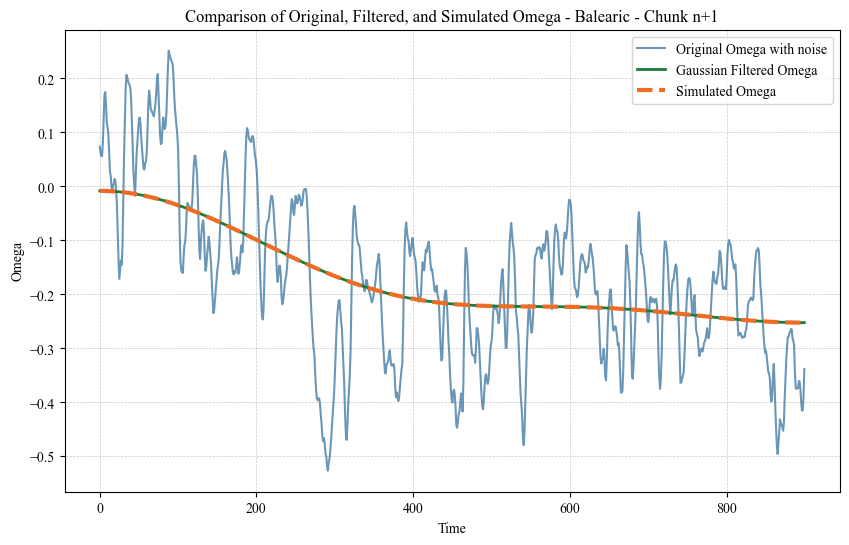

In [37]:
n=101
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(balearic_data[n]['omega_filtered'].values)[0], 
                      balearic_data[n]['omega_filtered'].iloc[0], 0.00]

# Define time points for simulation
total_time = len(balearic_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = balearic_data[n]['omega'].values  # Replace 'omega' with the actual column name
omega_filtered = balearic_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 2)
simulate_sindy_model(balearic_models[n], initial_conditions, time_points, 'Balearic - Chunk n+1', omega_original, omega_filtered)






In [39]:
# for 'Ireland' region
ireland_data = [chunk for chunk in gaussian_filtered_data if chunk['Region'].iloc[0] == 'Ireland']
ireland_models = calculate_sindy_models(ireland_data, 'Ireland')

Model for Ireland - Chunk 1:
(theta)' = -0.0025236 1 + -0.0000240 theta + 0.9914912 omega + -0.0000017 linear_time + 0.0000001 theta^2 + -0.0000180 theta omega + -0.0060810 omega^2 + 0.0000055 omega linear_time
(omega)' = -0.0042344 1 + -0.0000457 theta + -0.0151572 omega + -0.0000039 linear_time + 0.0000002 theta^2 + -0.0000333 theta omega + 0.0000001 theta linear_time + -0.0122699 omega^2 + 0.0000088 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666660752953262

Model for Ireland - Chunk 2:
(theta)' = 0.0000422 1 + -0.0000262 theta + 1.0034475 omega + 0.0000005 linear_time + -0.0000022 theta^2 + 0.0001067 theta omega + 0.0000001 theta linear_time + -0.0281452 omega^2 + -0.0000082 omega linear_time
(omega)' = 0.0000855 1 + -0.0000529 theta + 0.0070664 omega + 0.0000010 linear_time + -0.0000043 theta^2 + 0.0002112 theta omega + 0.0000003 theta linear_time + -0.0565869 omega^2 + -0.0000163 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666662743502297

M

Model for Ireland - Chunk 40:
(theta)' = -0.0003754 1 + 0.0001185 theta + 1.0498605 omega + 0.0000003 linear_time + -0.0000008 theta^2 + 0.0001931 theta omega + 0.0000002 theta linear_time + 0.0532518 omega^2 + -0.0001269 omega linear_time
(omega)' = -0.0007462 1 + 0.0002339 theta + 0.0990658 omega + 0.0000007 linear_time + -0.0000015 theta^2 + 0.0003838 theta omega + 0.0000004 theta linear_time + 0.1050595 omega^2 + -0.0002515 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666615002267338

Model for Ireland - Chunk 41:
(theta)' = -0.0018319 1 + -0.0000157 theta + 1.0074466 omega + 0.0000087 linear_time + -0.0000007 theta^2 + -0.0000099 theta omega + 0.0000005 theta linear_time + -0.0071629 omega^2 + 0.0000002 omega linear_time + -0.0000001 linear_time^2
(omega)' = -0.0037483 1 + -0.0000327 theta + 0.0152149 omega + 0.0000178 linear_time + -0.0000014 theta^2 + -0.0000188 theta omega + 0.0000010 theta linear_time + -0.0146060 omega^2 + -0.0000002 linear_time^2
(linear_ti

Model for Ireland - Chunk 80:
(theta)' = -0.0012567 1 + -0.0000263 theta + 1.0122896 omega + 0.0000049 linear_time + -0.0000027 theta^2 + 0.0000238 theta omega + 0.0000009 theta linear_time + -0.0260143 omega^2 + -0.0000112 omega linear_time + -0.0000001 linear_time^2
(omega)' = -0.0025011 1 + -0.0000552 theta + 0.0243669 omega + 0.0000100 linear_time + -0.0000054 theta^2 + 0.0000420 theta omega + 0.0000018 theta linear_time + -0.0511511 omega^2 + -0.0000212 omega linear_time + -0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666640596642646

Model for Ireland - Chunk 81:
(theta)' = -0.0063754 1 + 0.0008067 theta + 1.1064343 omega + -0.0001188 linear_time + -0.0000483 theta^2 + -0.0024451 theta omega + 0.0000132 theta linear_time + -0.4294184 omega^2 + 0.0003732 omega linear_time + -0.0000009 linear_time^2
(omega)' = -0.0127388 1 + 0.0016063 theta + 0.2123577 omega + -0.0002365 linear_time + -0.0000962 theta^2 + -0.0048736 theta omega + 0.0000264 theta linear_time 

Model for Ireland - Chunk 118:
(theta)' = 0.0079116 1 + -0.0000590 theta + 0.9749404 omega + 0.0000398 linear_time + 0.0000002 theta^2 + 0.0000661 theta omega + -0.0000002 theta linear_time + 0.0195302 omega^2 + -0.0000467 omega linear_time + 0.0000001 linear_time^2
(omega)' = 0.0186638 1 + -0.0001208 theta + -0.0603180 omega + 0.0000832 linear_time + 0.0000005 theta^2 + 0.0001467 theta omega + -0.0000007 theta linear_time + 0.0482109 omega^2 + -0.0001053 omega linear_time + 0.0000002 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666648734007964

Model for Ireland - Chunk 119:
(theta)' = -0.0410564 1 + 0.0005063 theta + 1.0918185 omega + -0.0002161 linear_time + 0.0000008 theta^2 + -0.0001217 theta omega + -0.0000010 theta linear_time + -0.0398707 omega^2 + -0.0000776 omega linear_time + 0.0000003 linear_time^2
(omega)' = -0.0814082 1 + 0.0010058 theta + 0.1818306 omega + -0.0004294 linear_time + 0.0000016 theta^2 + -0.0002434 theta omega + -0.0000019 theta linear_time + -

Model for Ireland - Chunk 156:
(theta)' = 0.0009230 1 + -0.0000193 theta + 1.0028683 omega + -0.0000095 linear_time + 0.0000002 theta^2 + -0.0000289 theta omega + 0.0000001 theta linear_time + 0.0000723 omega^2 + -0.0000162 omega linear_time
(omega)' = 0.0018674 1 + -0.0000398 theta + 0.0057774 omega + -0.0000194 linear_time + 0.0000003 theta^2 + -0.0000585 theta omega + 0.0000002 theta linear_time + 0.0000737 omega^2 + -0.0000326 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666665016919975

Model for Ireland - Chunk 157:
(theta)' = 0.0010565 1 + -0.0000469 theta + 1.0081898 omega + -0.0000096 linear_time + 0.0000004 theta^2 + 0.0000397 theta omega + 0.0000003 theta linear_time + 0.0094660 omega^2 + 0.0000103 omega linear_time + 0.0000001 linear_time^2
(omega)' = 0.0021434 1 + -0.0000924 theta + 0.0164593 omega + -0.0000190 linear_time + 0.0000008 theta^2 + 0.0000791 theta omega + 0.0000007 theta linear_time + 0.0183119 omega^2 + 0.0000194 omega linear_time + 0.000000

Model Score: 0.6666649889650431

Model for Ireland - Chunk 195:
(theta)' = -0.0011983 1 + -0.0000038 theta + 1.0023106 omega + 0.0000048 linear_time + 0.0000006 theta^2 + -0.0000156 theta omega + -0.0000003 theta linear_time + 0.0060534 omega^2 + -0.0000072 omega linear_time
(omega)' = -0.0020467 1 + -0.0000396 theta + 0.0029990 omega + 0.0000172 linear_time + 0.0000011 theta^2 + -0.0000223 theta omega + -0.0000005 theta linear_time + 0.0135682 omega^2 + -0.0000108 omega linear_time + 0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666665648470378

Model for Ireland - Chunk 196:
(theta)' = -0.0016767 1 + -0.0001109 theta + 0.9827459 omega + -0.0000046 linear_time + 0.0000025 theta^2 + -0.0001797 theta omega + 0.0266776 omega^2 + 0.0000288 omega linear_time
(omega)' = -0.0033206 1 + -0.0002212 theta + -0.0341100 omega + -0.0000092 linear_time + 0.0000050 theta^2 + -0.0003566 theta omega + 0.0534309 omega^2 + 0.0000569 omega linear_time
(linear_time)' = 1.0000000 1
M

Model for Ireland - Chunk 233:
(theta)' = -0.0101392 1 + 0.0002553 theta + 1.0050495 omega + 0.0000518 linear_time + 0.0000449 theta^2 + 0.0005817 theta omega + 0.0000083 theta linear_time + 0.5182952 omega^2 + 0.0001770 omega linear_time + 0.0000004 linear_time^2
(omega)' = -0.0202073 1 + 0.0005095 theta + 0.0103251 omega + 0.0001034 linear_time + 0.0000895 theta^2 + 0.0011638 theta omega + 0.0000167 theta linear_time + 1.0347270 omega^2 + 0.0003534 omega linear_time + 0.0000007 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6665061521657986

Model for Ireland - Chunk 234:
(theta)' = 0.0010295 1 + -0.0002171 theta + 1.0157039 omega + -0.0000244 linear_time + 0.0000028 theta^2 + -0.0001161 theta omega + 0.0000009 theta linear_time + 0.0587613 omega^2 + -0.0000057 omega linear_time + 0.0000001 linear_time^2
(omega)' = 0.0020720 1 + -0.0004330 theta + 0.0314754 omega + -0.0000487 linear_time + 0.0000056 theta^2 + -0.0002308 theta omega + 0.0000018 theta linear_time + 0.1171517

Model Score: 0.6666663088194555

Model for Ireland - Chunk 271:
(theta)' = -0.0249611 1 + -0.0002940 theta + 0.9237835 omega + -0.0000716 linear_time + -0.0000004 theta^2 + -0.0003151 theta omega + -0.0000005 theta linear_time + -0.0368899 omega^2 + -0.0000129 omega linear_time + -0.0000001 linear_time^2
(omega)' = -0.0497401 1 + -0.0005892 theta + -0.1521542 omega + -0.0001440 linear_time + -0.0000009 theta^2 + -0.0006287 theta omega + -0.0000010 theta linear_time + -0.0741960 omega^2 + -0.0000260 omega linear_time + -0.0000002 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666606955986496

Model for Ireland - Chunk 272:
(theta)' = 0.0001980 1 + -0.0000453 theta + 1.0062526 omega + 0.0000020 linear_time + -0.0000002 theta^2 + -0.0000309 theta omega + 0.0000002 theta linear_time + 0.0016099 omega^2 + -0.0000022 omega linear_time
(omega)' = 0.0003961 1 + -0.0000907 theta + 0.0126078 omega + 0.0000039 linear_time + -0.0000004 theta^2 + -0.0000611 theta omega + 0.0000003 theta

Model for Ireland - Chunk 305:
(theta)' = -0.0000430 1 + -0.0001368 theta + 1.0003751 omega + -0.0000247 linear_time + 0.0000008 theta^2 + -0.0000782 theta omega + 0.0000004 theta linear_time + 0.0034473 omega^2 + -0.0000126 omega linear_time
(omega)' = -0.0000298 1 + -0.0002739 theta + 0.0011956 omega + -0.0000495 linear_time + 0.0000016 theta^2 + -0.0001598 theta omega + 0.0000008 theta linear_time + 0.0076384 omega^2 + -0.0000261 omega linear_time + 0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666596214235295

Model for Ireland - Chunk 306:
(theta)' = 0.0065254 1 + -0.0002452 theta + 1.0526861 omega + -0.0000674 linear_time + 0.0000019 theta^2 + -0.0000579 theta omega + 0.0000015 theta linear_time + 0.0994854 omega^2 + 0.0000237 omega linear_time + 0.0000003 linear_time^2
(omega)' = 0.0135644 1 + -0.0005230 theta + 0.1097874 omega + -0.0001438 linear_time + 0.0000039 theta^2 + -0.0001386 theta omega + 0.0000031 theta linear_time + 0.2076100 omega^2 + 0.000045

Model for Ireland - Chunk 341:
(theta)' = 0.0419303 1 + -0.0001837 theta + 0.8360717 omega + 0.0000725 linear_time + 0.0000105 theta^2 + 0.0005234 theta omega + -0.0000109 theta linear_time + 0.1195587 omega^2 + -0.0001961 omega linear_time + 0.0000028 linear_time^2
(omega)' = 0.0844120 1 + -0.0003701 theta + -0.3301916 omega + 0.0001462 linear_time + 0.0000211 theta^2 + 0.0010571 theta omega + -0.0000219 theta linear_time + 0.2411908 omega^2 + -0.0003969 omega linear_time + 0.0000057 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666233619569969

Model for Ireland - Chunk 342:
(theta)' = 0.0005925 1 + -0.0001353 theta + 1.0002080 omega + 0.0000299 linear_time + -0.0000001 theta^2 + -0.0000428 theta omega + -0.0113495 omega^2 + 0.0000061 omega linear_time
(omega)' = 0.0011857 1 + -0.0002715 theta + 0.0003922 omega + 0.0000600 linear_time + -0.0000001 theta^2 + -0.0000864 theta omega + -0.0225533 omega^2 + 0.0000125 omega linear_time + -0.0000001 linear_time^2
(linear_time)'

Model for Ireland - Chunk 379:
(theta)' = 0.0002201 1 + -0.0000606 theta + 0.9915149 omega + 0.0000167 linear_time + 0.0000012 theta^2 + -0.0000806 theta omega + -0.0000004 theta linear_time + 0.0328892 omega^2 + 0.0000073 omega linear_time
(omega)' = 0.0004672 1 + -0.0001229 theta + -0.0172337 omega + 0.0000336 linear_time + 0.0000025 theta^2 + -0.0001615 theta omega + -0.0000008 theta linear_time + 0.0664096 omega^2 + 0.0000151 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666655661185278

Model for Ireland - Chunk 380:
(theta)' = 0.0000445 1 + 0.0000045 theta + 0.9984128 omega + 0.0000008 linear_time + 0.0000012 theta^2 + 0.0000181 theta omega + -0.0000003 theta linear_time + 0.0122654 omega^2 + -0.0000077 omega linear_time
(omega)' = 0.0000951 1 + 0.0000040 theta + -0.0034968 omega + 0.0000020 linear_time + 0.0000025 theta^2 + 0.0000306 theta omega + -0.0000006 theta linear_time + 0.0272964 omega^2 + -0.0000143 omega linear_time
(linear_time)' = 1.0000000 1
Model S

Model Score: 0.6666246263741012

Model for Ireland - Chunk 418:
(theta)' = -0.0010598 1 + -0.0000319 theta + 1.0161214 omega + 0.0000044 linear_time + -0.0000014 theta^2 + -0.0000009 theta omega + 0.0000005 theta linear_time + -0.0377484 omega^2 + -0.0000038 omega linear_time
(omega)' = -0.0022503 1 + -0.0000651 theta + 0.0338597 omega + 0.0000090 linear_time + -0.0000028 theta^2 + -0.0000016 theta omega + 0.0000011 theta linear_time + -0.0758252 omega^2 + -0.0000093 omega linear_time + -0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666656778071803

Model for Ireland - Chunk 419:
(theta)' = 0.0003736 1 + -0.0000035 theta + 0.9927341 omega + -0.0000025 linear_time + -0.0000009 theta^2 + -0.0000207 theta omega + -0.0000002 theta linear_time + 0.0019454 omega^2 + 0.0000014 omega linear_time
(omega)' = 0.0007895 1 + -0.0000032 theta + -0.0149735 omega + -0.0000052 linear_time + -0.0000024 theta^2 + -0.0000619 theta omega + -0.0000004 theta linear_time + -0.0025001 om

Model for Ireland - Chunk 455:
(theta)' = 0.0031514 1 + -0.0000358 theta + 1.0256624 omega + -0.0000079 linear_time + 0.0000022 theta^2 + 0.0001247 theta omega + 0.0000012 theta linear_time + 0.0522031 omega^2 + 0.0000358 omega linear_time + 0.0000002 linear_time^2
(omega)' = 0.0061342 1 + -0.0000726 theta + 0.0496469 omega + -0.0000164 linear_time + 0.0000044 theta^2 + 0.0002419 theta omega + 0.0000025 theta linear_time + 0.1003508 omega^2 + 0.0000682 omega linear_time + 0.0000003 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666647838961163

Model for Ireland - Chunk 456:
(theta)' = -0.0054953 1 + -0.0002056 theta + 0.9742075 omega + -0.0000457 linear_time + -0.0000003 theta^2 + -0.0000227 theta omega + -0.0271373 omega^2 + 0.0000517 omega linear_time
(omega)' = -0.0090137 1 + -0.0003726 theta + -0.0444549 omega + -0.0000832 linear_time + -0.0000005 theta^2 + -0.0000430 theta omega + -0.0511751 omega^2 + 0.0000912 omega linear_time + 0.0000001 linear_time^2
(linear_time)

Model for Ireland - Chunk 493:
(theta)' = 0.0033736 1 + -0.0000713 theta + 0.9840659 omega + 0.0000269 linear_time + 0.0000005 theta^2 + 0.0000293 theta omega + -0.0000003 theta linear_time + 0.0187689 omega^2 + -0.0000071 omega linear_time
(omega)' = 0.0066642 1 + -0.0001433 theta + -0.0316195 omega + 0.0000539 linear_time + 0.0000010 theta^2 + 0.0000559 theta omega + -0.0000005 theta linear_time + 0.0374309 omega^2 + -0.0000127 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666570193878734

Model for Ireland - Chunk 494:
(theta)' = 0.0001712 1 + -0.0000183 theta + 1.0108652 omega + 0.0000020 linear_time + -0.0000006 theta^2 + -0.0000678 theta omega + 0.0000003 theta linear_time + -0.0129559 omega^2 + -0.0000065 omega linear_time
(omega)' = 0.0003457 1 + -0.0000355 theta + 0.0220798 omega + 0.0000040 linear_time + -0.0000013 theta^2 + -0.0001355 theta omega + 0.0000006 theta linear_time + -0.0249605 omega^2 + -0.0000144 omega linear_time
(linear_time)' = 1.0000000 1
Mo

Model for Ireland - Chunk 530:
(theta)' = -0.0015011 1 + -0.0001457 theta + 1.0028812 omega + 0.0000432 linear_time + 0.0000001 theta^2 + -0.0000098 theta omega + 0.0000001 theta linear_time + 0.0068265 omega^2 + 0.0000065 omega linear_time
(omega)' = -0.0030442 1 + -0.0002904 theta + 0.0057229 omega + 0.0000862 linear_time + 0.0000003 theta^2 + -0.0000223 theta omega + 0.0000001 theta linear_time + 0.0142373 omega^2 + 0.0000131 omega linear_time + -0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666650370209478

Model for Ireland - Chunk 531:
(theta)' = -0.0001899 1 + -0.0000113 theta + 1.0031038 omega + 0.0000038 linear_time + -0.0000004 theta^2 + -0.0000417 theta omega + 0.0000002 theta linear_time + 0.0042838 omega^2 + -0.0000130 omega linear_time
(omega)' = -0.0003879 1 + -0.0000210 theta + 0.0062562 omega + 0.0000076 linear_time + -0.0000007 theta^2 + -0.0000823 theta omega + 0.0000004 theta linear_time + 0.0095682 omega^2 + -0.0000275 omega linear_time
(line

Model for Ireland - Chunk 568:
(theta)' = 0.0003900 1 + 1.0043388 omega + 0.0000011 linear_time + 0.0000002 theta^2 + -0.0000332 theta omega + 0.0027204 omega^2 + -0.0000140 omega linear_time
(omega)' = 0.0007792 1 + -0.0000006 theta + 0.0086946 omega + 0.0000021 linear_time + 0.0000005 theta^2 + -0.0000667 theta omega + 0.0054877 omega^2 + -0.0000278 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666659121535253

Model for Ireland - Chunk 569:
(theta)' = 0.0001931 1 + -0.0000821 theta + 1.0031565 omega + -0.0000286 linear_time + 0.0000001 theta^2 + 0.0000416 theta omega + 0.0071307 omega^2 + 0.0000117 omega linear_time
(omega)' = 0.0003806 1 + -0.0001642 theta + 0.0062802 omega + -0.0000572 linear_time + 0.0000002 theta^2 + 0.0000843 theta omega + 0.0000001 theta linear_time + 0.0141905 omega^2 + 0.0000238 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666597780100382

Model for Ireland - Chunk 570:
(theta)' = 0.0031789 1 + -0.0002665 theta + 0.9672881 

Model for Ireland - Chunk 606:
(theta)' = 0.0042704 1 + 0.0000032 theta + 1.0123031 omega + -0.0000069 linear_time + 0.0000043 theta omega + 0.0034085 omega^2 + -0.0000202 omega linear_time
(omega)' = 0.0085807 1 + 0.0000083 theta + 0.0247803 omega + -0.0000130 linear_time + 0.0000001 theta^2 + 0.0000085 theta omega + 0.0000001 theta linear_time + 0.0069958 omega^2 + -0.0000406 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666657937439805

Model for Ireland - Chunk 607:
(theta)' = -0.0001906 1 + -0.0004170 theta + 0.9948425 omega + 0.0000698 linear_time + 0.0000033 theta^2 + -0.0000033 theta omega + -0.0000003 theta linear_time + 0.0375516 omega^2 + -0.0000007 omega linear_time
(omega)' = -0.0004134 1 + -0.0008292 theta + -0.0100364 omega + 0.0001389 linear_time + 0.0000065 theta^2 + -0.0000062 theta omega + -0.0000006 theta linear_time + 0.0745999 omega^2 + -0.0000017 omega linear_time + -0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.666658693732

Model Score: 0.666664713646361

Model for Ireland - Chunk 644:
(theta)' = -0.0021872 1 + -0.0001705 theta + 1.0530591 omega + 0.0000095 linear_time + -0.0000037 theta^2 + -0.0004597 theta omega + 0.0000009 theta linear_time + -0.3178338 omega^2 + 0.0001139 omega linear_time + -0.0000001 linear_time^2
(omega)' = -0.0044095 1 + -0.0003398 theta + 0.1065723 omega + 0.0000189 linear_time + -0.0000073 theta^2 + -0.0009185 theta omega + 0.0000019 theta linear_time + -0.6364967 omega^2 + 0.0002275 omega linear_time + -0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666499402320607

Model for Ireland - Chunk 645:
(theta)' = -0.0052365 1 + -0.0003073 theta + 1.0524686 omega + 0.0000511 linear_time + -0.0000107 theta^2 + -0.0000742 theta omega + 0.0000043 theta linear_time + -0.1270492 omega^2 + 0.0000161 omega linear_time + -0.0000004 linear_time^2
(omega)' = -0.0105411 1 + -0.0006183 theta + 0.1055980 omega + 0.0001027 linear_time + -0.0000216 theta^2 + -0.0001502 theta om

Model Score: 0.6666646093163257

Model for Ireland - Chunk 682:
(theta)' = 0.0004132 1 + -0.0000880 theta + 0.9732918 omega + 0.0000033 linear_time + 0.0000005 theta^2 + -0.0000144 theta omega + -0.0000003 theta linear_time + 0.0129949 omega^2 + 0.0000288 omega linear_time + 0.0000001 linear_time^2
(omega)' = 0.0008198 1 + -0.0001766 theta + -0.0531098 omega + 0.0000066 linear_time + 0.0000010 theta^2 + -0.0000286 theta omega + -0.0000007 theta linear_time + 0.0257273 omega^2 + 0.0000574 omega linear_time + 0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666656004439085

Model for Ireland - Chunk 683:
(theta)' = -0.0165884 1 + -0.0000390 theta + 1.0490548 omega + 0.0000351 linear_time + -0.0000017 theta^2 + 0.0000397 theta omega + 0.0000017 theta linear_time + -0.0262287 omega^2 + -0.0000575 omega linear_time + -0.0000004 linear_time^2
(omega)' = -0.0341610 1 + -0.0000933 theta + 0.1037496 omega + 0.0000747 linear_time + -0.0000034 theta^2 + 0.0000872 theta omega +

Model for Ireland - Chunk 721:
(theta)' = -0.0324027 1 + -0.0001024 theta + 1.0832976 omega + 0.0000480 linear_time + 0.0000062 theta^2 + 0.0003320 theta omega + 0.0000003 theta linear_time + 0.0676741 omega^2 + -0.0001675 omega linear_time + -0.0000001 linear_time^2
(omega)' = -0.0653598 1 + -0.0002051 theta + 0.1681782 omega + 0.0000967 linear_time + 0.0000125 theta^2 + 0.0006673 theta omega + 0.0000006 theta linear_time + 0.1360425 omega^2 + -0.0003377 omega linear_time + -0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666444963558994

Model for Ireland - Chunk 722:
(theta)' = 0.0004938 1 + -0.0001093 theta + 0.9963663 omega + 0.0000355 linear_time + 0.0000001 theta^2 + -0.0000004 theta omega + 0.0065290 omega^2 + 0.0000115 omega linear_time
(omega)' = 0.0009554 1 + -0.0002282 theta + -0.0070789 omega + 0.0000733 linear_time + 0.0000002 theta^2 + 0.0000005 theta omega + 0.0000001 theta linear_time + 0.0127524 omega^2 + 0.0000243 omega linear_time
(linear_time)'

Model for Ireland - Chunk 761:
(theta)' = -0.0007483 1 + 0.0001965 theta + 1.0171375 omega + -0.0000066 linear_time + 0.0000008 theta^2 + 0.0000228 theta omega + -0.0000003 theta linear_time + 0.0147957 omega^2 + -0.0000375 omega linear_time
(omega)' = -0.0014834 1 + 0.0003875 theta + 0.0339439 omega + -0.0000130 linear_time + 0.0000016 theta^2 + 0.0000486 theta omega + -0.0000007 theta linear_time + 0.0300186 omega^2 + -0.0000734 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666608133694686

Model for Ireland - Chunk 762:
(theta)' = -0.0053571 1 + -0.0001376 theta + 1.0275560 omega + 0.0000475 linear_time + -0.0000016 theta^2 + 0.0001239 theta omega + 0.0000013 theta linear_time + -0.0339661 omega^2 + -0.0000502 omega linear_time + -0.0000002 linear_time^2
(omega)' = -0.0108270 1 + -0.0002775 theta + 0.0557887 omega + 0.0000956 linear_time + -0.0000033 theta^2 + 0.0002501 theta omega + 0.0000025 theta linear_time + -0.0689437 omega^2 + -0.0001007 omega linear_time + -

Model for Ireland - Chunk 797:
(theta)' = -0.0007422 1 + -0.0000891 theta + 0.9996016 omega + -0.0000234 linear_time + 0.0000005 theta^2 + 0.0000015 theta omega + 0.0000002 theta linear_time + 0.0057246 omega^2 + 0.0000099 omega linear_time
(omega)' = -0.0014746 1 + -0.0001779 theta + -0.0007819 omega + -0.0000468 linear_time + 0.0000010 theta^2 + 0.0000041 theta omega + 0.0000004 theta linear_time + 0.0113810 omega^2 + 0.0000201 omega linear_time + 0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666654613582558

Model for Ireland - Chunk 798:
(theta)' = -0.0012595 1 + 0.0000187 theta + 1.0098478 omega + 0.0000009 linear_time + -0.0000017 theta^2 + 0.0000517 theta omega + 0.0000009 theta linear_time + -0.0191194 omega^2 + -0.0000297 omega linear_time + -0.0000001 linear_time^2
(omega)' = -0.0025548 1 + 0.0000359 theta + 0.0197860 omega + 0.0000022 linear_time + -0.0000033 theta^2 + 0.0001063 theta omega + 0.0000017 theta linear_time + -0.0381191 omega^2 + -0.000060

Model for Ireland - Chunk 834:
(theta)' = -0.0000191 1 + -0.0001969 theta + 1.0016745 omega + 0.0000098 linear_time + -0.0000033 theta^2 + 0.0001558 theta omega + 0.0000004 theta linear_time + -0.0270908 omega^2 + 0.0000051 omega linear_time
(omega)' = -0.0000449 1 + -0.0003927 theta + 0.0034299 omega + 0.0000195 linear_time + -0.0000064 theta^2 + 0.0003046 theta omega + 0.0000009 theta linear_time + -0.0533085 omega^2 + 0.0000105 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666584970152919

Model for Ireland - Chunk 835:
(theta)' = -0.0111594 1 + -0.0001891 theta + 0.9673425 omega + -0.0000676 linear_time + -0.0000008 theta^2 + -0.0000112 theta omega + -0.0000004 theta linear_time + -0.0171512 omega^2 + 0.0000293 omega linear_time
(omega)' = -0.0222304 1 + -0.0003784 theta + -0.0651461 omega + -0.0001354 linear_time + -0.0000016 theta^2 + -0.0000220 theta omega + -0.0000009 theta linear_time + -0.0343737 omega^2 + 0.0000586 omega linear_time
(linear_time)' = 1.000000

Model for Ireland - Chunk 875:
(theta)' = -0.0001933 1 + -0.0000834 theta + 0.9930640 omega + -0.0000144 linear_time + -0.0000032 theta^2 + -0.0001379 theta omega + -0.0000007 theta linear_time + -0.0413487 omega^2 + -0.0000374 omega linear_time
(omega)' = -0.0003676 1 + -0.0001682 theta + -0.0137537 omega + -0.0000290 linear_time + -0.0000063 theta^2 + -0.0002769 theta omega + -0.0000014 theta linear_time + -0.0828501 omega^2 + -0.0000751 omega linear_time + -0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666629554587503

Model for Ireland - Chunk 876:
(theta)' = -0.0003236 1 + -0.0000276 theta + 0.9937286 omega + -0.0000039 linear_time + -0.0000035 theta^2 + 0.0002515 theta omega + -0.0000008 theta linear_time + -0.0302040 omega^2 + 0.0000238 omega linear_time
(omega)' = -0.0006550 1 + -0.0000561 theta + -0.0128239 omega + -0.0000079 linear_time + -0.0000071 theta^2 + 0.0005043 theta omega + -0.0000016 theta linear_time + -0.0622881 omega^2 + 0.0000477 omega lin

Model for Ireland - Chunk 914:
(theta)' = 0.0082300 1 + -0.0000856 theta + 1.0023764 omega + -0.0000375 linear_time + -0.0000017 theta^2 + -0.0000685 theta omega + -0.0000005 theta linear_time + -0.0316345 omega^2 + -0.0000364 omega linear_time
(omega)' = 0.0176274 1 + -0.0001800 theta + 0.0053864 omega + -0.0000794 linear_time + -0.0000036 theta^2 + -0.0001461 theta omega + -0.0000011 theta linear_time + -0.0671546 omega^2 + -0.0000773 omega linear_time + -0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666656114030506

Model for Ireland - Chunk 915:
(theta)' = 0.0021197 1 + -0.0000001 theta + 0.9525106 omega + 0.0000039 linear_time + 0.0000050 theta^2 + 0.0002368 theta omega + -0.0000022 theta linear_time + 0.0534273 omega^2 + -0.0000117 omega linear_time + 0.0000002 linear_time^2
(omega)' = 0.0042459 1 + -0.0000001 theta + -0.0952172 omega + 0.0000078 linear_time + 0.0000101 theta^2 + 0.0004778 theta omega + -0.0000045 theta linear_time + 0.1076586 omega^2 + -0.

Model for Ireland - Chunk 952:
(theta)' = 0.0016537 1 + -0.0000927 theta + 1.0102344 omega + -0.0000215 linear_time + 0.0000008 theta^2 + -0.0000275 theta omega + 0.0000005 theta linear_time + 0.0139347 omega^2 + -0.0000122 omega linear_time + 0.0000001 linear_time^2
(omega)' = 0.0033264 1 + -0.0001861 theta + 0.0205685 omega + -0.0000432 linear_time + 0.0000016 theta^2 + -0.0000553 theta omega + 0.0000010 theta linear_time + 0.0279211 omega^2 + -0.0000244 omega linear_time + 0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666662255758172

Model for Ireland - Chunk 953:
(theta)' = -0.0001039 1 + -0.0000543 theta + 0.9974340 omega + -0.0000088 linear_time + -0.0000002 theta^2 + -0.0000078 theta omega + -0.0066098 omega^2 + 0.0000056 omega linear_time
(omega)' = -0.0002225 1 + -0.0001075 theta + -0.0050363 omega + -0.0000176 linear_time + -0.0000005 theta^2 + -0.0000145 theta omega + 0.0000001 theta linear_time + -0.0128590 omega^2 + 0.0000107 omega linear_time
(line

Model Score: 0.6666647822403702

Model for Ireland - Chunk 991:
(theta)' = 0.0033242 1 + -0.0000798 theta + 0.9896814 omega + 0.0000206 linear_time + -0.0000002 theta^2 + 0.0000699 theta omega + 0.0035847 omega^2 + -0.0000065 omega linear_time
(omega)' = 0.0066665 1 + -0.0001597 theta + -0.0205173 omega + 0.0000410 linear_time + -0.0000004 theta^2 + 0.0001399 theta omega + 0.0000001 theta linear_time + 0.0067250 omega^2 + -0.0000127 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666663081470395

Model for Ireland - Chunk 992:
(theta)' = -0.0004318 1 + 0.0000006 theta + 0.9948788 omega + -0.0000053 linear_time + -0.0000001 theta^2 + -0.0000012 theta omega + -0.0000001 theta linear_time + -0.0046867 omega^2 + -0.0000053 omega linear_time
(omega)' = -0.0008261 1 + 0.0000010 theta + -0.0098539 omega + -0.0000105 linear_time + -0.0000002 theta^2 + -0.0000029 theta omega + -0.0000003 theta linear_time + -0.0091606 omega^2 + -0.0000112 omega linear_time + -0.0000001 linear_tim

Model for Ireland - Chunk 1031:
(theta)' = -0.0013301 1 + -0.0000866 theta + 0.9917581 omega + -0.0000074 linear_time + 0.0000009 theta^2 + -0.0000575 theta omega + 0.0169024 omega^2 + 0.0000115 omega linear_time
(omega)' = -0.0026371 1 + -0.0001730 theta + -0.0162651 omega + -0.0000148 linear_time + 0.0000019 theta^2 + -0.0001132 theta omega + 0.0000001 theta linear_time + 0.0340374 omega^2 + 0.0000230 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666603964074769

Model for Ireland - Chunk 1032:
(theta)' = 0.0003270 1 + -0.0001402 theta + 0.9909878 omega + 0.0000063 linear_time + 0.0000030 theta^2 + 0.0001358 theta omega + -0.0000001 theta linear_time + 0.0593229 omega^2 + 0.0000141 omega linear_time
(omega)' = 0.0006420 1 + -0.0002816 theta + -0.0178560 omega + 0.0000127 linear_time + 0.0000061 theta^2 + 0.0002700 theta omega + -0.0000001 theta linear_time + 0.1193724 omega^2 + 0.0000282 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666631520263501



Model for Ireland - Chunk 1069:
(theta)' = 0.0003983 1 + 0.0000522 theta + 0.9947153 omega + -0.0000084 linear_time + 0.0000019 theta^2 + -0.0001194 theta omega + -0.0000009 theta linear_time + 0.0161878 omega^2 + 0.0000152 omega linear_time + 0.0000001 linear_time^2
(omega)' = 0.0008153 1 + 0.0001028 theta + -0.0108246 omega + -0.0000165 linear_time + 0.0000037 theta^2 + -0.0002396 theta omega + -0.0000017 theta linear_time + 0.0331616 omega^2 + 0.0000308 omega linear_time + 0.0000002 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666665960668451

Model for Ireland - Chunk 1070:
(theta)' = -0.0010795 1 + 0.0000346 theta + 1.0086693 omega + -0.0000017 linear_time + -0.0000002 theta^2 + 0.0000881 theta omega + -0.0128514 omega^2 + -0.0000369 omega linear_time
(omega)' = -0.0021801 1 + 0.0000685 theta + 0.0174724 omega + -0.0000032 linear_time + -0.0000003 theta^2 + 0.0001783 theta omega + -0.0257501 omega^2 + -0.0000744 omega linear_time
(linear_time)' = 1.0000000 1
Model Sc

Model for Ireland - Chunk 1107:
(theta)' = -0.0001787 1 + 0.0000029 theta + 1.0014837 omega + 0.0000038 linear_time + -0.0000001 theta^2 + 0.0000143 theta omega + -0.0000480 omega^2 + -0.0000110 omega linear_time
(omega)' = -0.0003718 1 + 0.0000044 theta + 0.0030543 omega + 0.0000078 linear_time + -0.0000002 theta^2 + 0.0000290 theta omega + -0.0000089 omega^2 + -0.0000220 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666661482262011

Model for Ireland - Chunk 1108:
(theta)' = 0.0020645 1 + -0.0000180 theta + 1.0193565 omega + -0.0000039 linear_time + 0.0000024 theta^2 + 0.0001108 theta omega + 0.0000010 theta linear_time + 0.0352833 omega^2 + 0.0000153 omega linear_time + 0.0000001 linear_time^2
(omega)' = 0.0041542 1 + -0.0000363 theta + 0.0388590 omega + -0.0000078 linear_time + 0.0000048 theta^2 + 0.0002211 theta omega + 0.0000021 theta linear_time + 0.0704237 omega^2 + 0.0000304 omega linear_time + 0.0000002 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 

Model for Ireland - Chunk 1146:
(theta)' = 0.0132653 1 + -0.0002157 theta + 0.8596897 omega + 0.0000363 linear_time + 0.0000104 theta^2 + -0.0008548 theta omega + -0.0000035 theta linear_time + 0.3709494 omega^2 + 0.0001899 omega linear_time + 0.0000003 linear_time^2
(omega)' = 0.0264440 1 + -0.0004292 theta + -0.2798760 omega + 0.0000722 linear_time + 0.0000209 theta^2 + -0.0017128 theta omega + -0.0000070 theta linear_time + 0.7403723 omega^2 + 0.0003802 omega linear_time + 0.0000006 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.666641516872288

Model for Ireland - Chunk 1147:
(theta)' = -0.0001418 1 + 0.0000227 theta + 0.9963848 omega + -0.0000022 linear_time + 0.0000012 theta^2 + -0.0000386 theta omega + -0.0000001 theta linear_time + 0.0504620 omega^2 + -0.0000048 omega linear_time
(omega)' = -0.0001609 1 + 0.0000327 theta + -0.0086430 omega + -0.0000035 linear_time + 0.0000023 theta^2 + -0.0000810 theta omega + -0.0000002 theta linear_time + 0.1028218 omega^2 + -0.000

Model Score: 0.6666608765316396

Model for Ireland - Chunk 1187:
(theta)' = 0.0002427 1 + -0.0000269 theta + 1.0044298 omega + -0.0000006 linear_time + -0.0000001 theta^2 + -0.0000673 theta omega + 0.0000001 theta linear_time + 0.0051383 omega^2 + -0.0000051 omega linear_time
(omega)' = 0.0004943 1 + -0.0000539 theta + 0.0090367 omega + -0.0000013 linear_time + -0.0000001 theta^2 + -0.0001344 theta omega + 0.0000001 theta linear_time + 0.0104687 omega^2 + -0.0000104 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.666666592799097

Model for Ireland - Chunk 1188:
(theta)' = -0.0001337 1 + -0.0000211 theta + 1.0037464 omega + 0.0000009 linear_time + -0.0000014 theta^2 + 0.0000634 theta omega + 0.0000001 theta linear_time + -0.0259983 omega^2 + -0.0000068 omega linear_time
(omega)' = -0.0002729 1 + -0.0000437 theta + 0.0075335 omega + 0.0000019 linear_time + -0.0000028 theta^2 + 0.0001262 theta omega + 0.0000003 theta linear_time + -0.0515518 omega^2 + -0.0000133 omega linear

Model for Ireland - Chunk 1223:
(theta)' = 0.0000986 1 + -0.0002032 theta + 0.9942907 omega + 0.0000036 linear_time + -0.0000009 theta^2 + 0.0000591 theta omega + 0.0000004 theta linear_time + -0.0469863 omega^2 + 0.0000310 omega linear_time
(omega)' = 0.0001880 1 + -0.0003972 theta + -0.0108742 omega + 0.0000070 linear_time + -0.0000017 theta^2 + 0.0001187 theta omega + 0.0000007 theta linear_time + -0.0936837 omega^2 + 0.0000604 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666618164924488

Model for Ireland - Chunk 1224:
(theta)' = 0.0016803 1 + -0.0000026 theta + 0.9922146 omega + 0.0000007 linear_time + 0.0000007 theta^2 + -0.0000115 theta omega + -0.0000006 theta linear_time + 0.0089724 omega^2 + 0.0000003 omega linear_time + 0.0000001 linear_time^2
(omega)' = 0.0032730 1 + -0.0000064 theta + -0.0153133 omega + 0.0000020 linear_time + 0.0000014 theta^2 + -0.0000235 theta omega + -0.0000012 theta linear_time + 0.0178084 omega^2 + 0.0000008 omega linear_time + 0.00

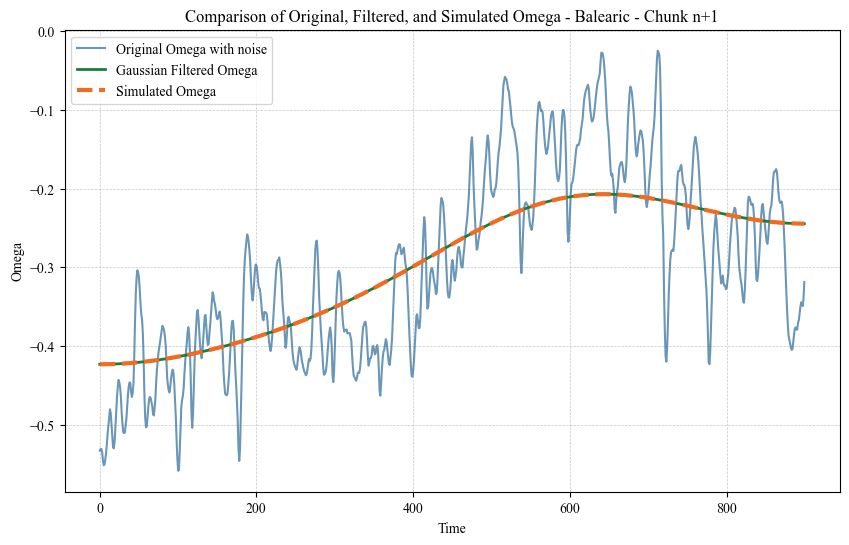

In [40]:
n=101
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(ireland_data[n]['omega_filtered'].values)[0], 
                      ireland_data[n]['omega_filtered'].iloc[0], 0.00]

# Define time points for simulation
total_time = len(ireland_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = ireland_data[n]['omega'].values  # Replace 'omega' with the actual column name
omega_filtered = ireland_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 2)
simulate_sindy_model(ireland_models[n], initial_conditions, time_points, 'Balearic - Chunk n+1', 
                     omega_original, omega_filtered)


In [41]:
# for 'iceland' region
iceland_data = [chunk for chunk in gaussian_filtered_data if chunk['Region'].iloc[0] == 'Iceland']
iceland_models = calculate_sindy_models(iceland_data, 'Iceland')

Model for Iceland - Chunk 1:
(theta)' = -0.0001231 1 + -0.0000715 theta + 0.9955576 omega + 0.0000052 linear_time + 0.0000110 theta^2 + -0.0001978 theta omega + -0.0000013 theta linear_time + 0.0972964 omega^2 + 0.0000032 omega linear_time
(omega)' = -0.0002468 1 + -0.0001416 theta + -0.0088884 omega + 0.0000103 linear_time + 0.0000220 theta^2 + -0.0004021 theta omega + -0.0000026 theta linear_time + 0.1948176 omega^2 + 0.0000068 omega linear_time + 0.0000001 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666628007843748

Model for Iceland - Chunk 2:
(theta)' = 0.0000356 1 + 0.0000312 theta + 0.9990505 omega + -0.0000021 linear_time + -0.0000013 theta^2 + -0.0000442 theta omega + -0.0000001 theta linear_time + -0.0030094 omega^2 + -0.0000109 omega linear_time
(omega)' = 0.0000642 1 + 0.0000584 theta + -0.0016579 omega + -0.0000040 linear_time + -0.0000025 theta^2 + -0.0000916 theta omega + -0.0000001 theta linear_time + -0.0061606 omega^2 + -0.0000213 omega linear_time
(lin

Model for Iceland - Chunk 41:
(theta)' = 0.0009637 1 + -0.0000507 theta + 0.9908234 omega + 0.0000067 linear_time + 0.0000002 theta^2 + 0.0000032 theta omega + 0.0190739 omega^2 + 0.0000212 omega linear_time
(omega)' = 0.0012598 1 + -0.0000863 theta + -0.0162115 omega + 0.0000098 linear_time + 0.0000004 theta^2 + 0.0000058 theta omega + 0.0378775 omega^2 + 0.0000383 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666375044052764

Model for Iceland - Chunk 42:
(theta)' = 0.0001470 1 + -0.0001339 theta + 1.0137170 omega + -0.0000016 linear_time + 0.0000015 theta^2 + -0.0000528 theta omega + 0.0000002 theta linear_time + 0.0146523 omega^2 + -0.0000176 omega linear_time
(omega)' = 0.0002945 1 + -0.0002691 theta + 0.0275104 omega + -0.0000031 linear_time + 0.0000031 theta^2 + -0.0001036 theta omega + 0.0000004 theta linear_time + 0.0298237 omega^2 + -0.0000351 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666496398325994

Model for Iceland - Chunk 43:
(theta)

Model for Iceland - Chunk 82:
(theta)' = 0.0015832 1 + -0.0000369 theta + 0.9194854 omega + 0.0000024 linear_time + 0.0000350 theta^2 + 0.0014194 theta omega + -0.0000053 theta linear_time + 0.2634972 omega^2 + -0.0000318 omega linear_time + 0.0000002 linear_time^2
(omega)' = 0.0031895 1 + -0.0000738 theta + -0.1623134 omega + 0.0000049 linear_time + 0.0000706 theta^2 + 0.0028781 theta omega + -0.0000107 theta linear_time + 0.5335318 omega^2 + -0.0000656 omega linear_time + 0.0000004 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666577057741333

Model for Iceland - Chunk 83:
(theta)' = 0.0005014 1 + -0.0003583 theta + 0.9823650 omega + 0.0000086 linear_time + -0.0000035 theta^2 + -0.0008413 theta omega + 0.0000003 theta linear_time + 0.0044769 omega^2 + 0.0001024 omega linear_time
(omega)' = 0.0009899 1 + -0.0007161 theta + -0.0348442 omega + 0.0000172 linear_time + -0.0000070 theta^2 + -0.0016721 theta omega + 0.0000006 theta linear_time + 0.0094077 omega^2 + 0.0002034 om

Model for Iceland - Chunk 121:
(theta)' = -0.0006667 1 + -0.0001864 theta + 1.0216986 omega + 0.0000070 linear_time + -0.0000051 theta^2 + 0.0003553 theta omega + 0.0000007 theta linear_time + -0.0306397 omega^2 + -0.0000413 omega linear_time
(omega)' = -0.0013276 1 + -0.0003733 theta + 0.0432895 omega + 0.0000139 linear_time + -0.0000102 theta^2 + 0.0007064 theta omega + 0.0000013 theta linear_time + -0.0635226 omega^2 + -0.0000816 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666473340339448

Model for Iceland - Chunk 122:
(theta)' = -0.0002204 1 + -0.0000824 theta + 1.0054298 omega + 0.0000038 linear_time + -0.0000029 theta^2 + -0.0002776 theta omega + 0.0000004 theta linear_time + -0.0282165 omega^2 + 0.0000115 omega linear_time
(omega)' = -0.0004456 1 + -0.0001652 theta + 0.0109230 omega + 0.0000077 linear_time + -0.0000059 theta^2 + -0.0005559 theta omega + 0.0000008 theta linear_time + -0.0557672 omega^2 + 0.0000229 omega linear_time
(linear_time)' = 1.0000000 1

Model Score: 0.666639254110389

Model for Iceland - Chunk 162:
(theta)' = -0.0001686 1 + -0.0000464 theta + 0.9929663 omega + -0.0000017 linear_time + -0.0000019 theta^2 + 0.0001503 theta omega + -0.0000003 theta linear_time + 0.0027664 omega^2 + 0.0000209 omega linear_time
(omega)' = -0.0003422 1 + -0.0000928 theta + -0.0143513 omega + -0.0000034 linear_time + -0.0000040 theta^2 + 0.0002944 theta omega + -0.0000006 theta linear_time + 0.0037803 omega^2 + 0.0000417 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666580616144538

Model for Iceland - Chunk 163:
(theta)' = 0.0003823 1 + -0.0001430 theta + 1.0156235 omega + -0.0000043 linear_time + 0.0000031 theta^2 + -0.0002042 theta omega + 0.0000005 theta linear_time + 0.0338736 omega^2 + -0.0000259 omega linear_time
(omega)' = 0.0007621 1 + -0.0002866 theta + 0.0311793 omega + -0.0000086 linear_time + 0.0000062 theta^2 + -0.0004046 theta omega + 0.0000010 theta linear_time + 0.0690130 omega^2 + -0.0000508 omega linear_ti

Model for Iceland - Chunk 199:
(theta)' = -0.0001091 1 + 0.0000316 theta + 0.9961286 omega + 0.0000008 linear_time + -0.0000003 theta^2 + 0.0000863 theta omega + -0.0000002 theta linear_time + 0.0020088 omega^2 + 0.0000049 omega linear_time
(omega)' = -0.0002198 1 + 0.0000636 theta + -0.0078151 omega + 0.0000015 linear_time + -0.0000006 theta^2 + 0.0001751 theta omega + -0.0000004 theta linear_time + 0.0039452 omega^2 + 0.0000101 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666578065887574

Model for Iceland - Chunk 200:
(theta)' = 0.0030919 1 + -0.0000135 theta + 0.9961499 omega + -0.0000031 linear_time + -0.0000001 theta^2 + 0.0000109 theta omega + 0.0000001 theta linear_time + -0.0005658 omega^2 + -0.0000007 omega linear_time
(omega)' = 0.0051373 1 + -0.0000267 theta + -0.0064569 omega + -0.0000046 linear_time + -0.0000003 theta^2 + 0.0000215 theta omega + 0.0000001 theta linear_time + -0.0008512 omega^2 + -0.0000037 omega linear_time
(linear_time)' = 1.0000000 1
M

Model Score: 0.6663985683011394

Model for Iceland - Chunk 237:
(theta)' = -0.0001701 1 + -0.0001558 theta + 1.0023377 omega + 0.0000094 linear_time + -0.0000006 theta^2 + 0.0000073 theta omega + 0.0000002 theta linear_time + 0.0041084 omega^2 + 0.0000121 omega linear_time
(omega)' = -0.0003527 1 + -0.0003117 theta + 0.0047908 omega + 0.0000187 linear_time + -0.0000011 theta^2 + 0.0000101 theta omega + 0.0000004 theta linear_time + 0.0093683 omega^2 + 0.0000239 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666637680701221

Model for Iceland - Chunk 238:
(theta)' = -0.0001354 1 + -0.0000604 theta + 1.0124651 omega + 0.0000011 linear_time + -0.0000294 theta^2 + 0.0032259 theta omega + 0.0000008 theta linear_time + -0.1007724 omega^2 + -0.0000758 omega linear_time
(omega)' = -0.0002713 1 + -0.0001222 theta + 0.0249587 omega + 0.0000022 linear_time + -0.0000586 theta^2 + 0.0064121 theta omega + 0.0000016 theta linear_time + -0.1993436 omega^2 + -0.0001507 omega linear_time

Model for Iceland - Chunk 274:
(theta)' = -0.0000137 1 + -0.0000077 theta + 0.9830753 omega + -0.0000007 linear_time + -0.0000057 theta^2 + 0.0011025 theta omega + -0.0000002 theta linear_time + -0.1403785 omega^2 + 0.0000368 omega linear_time
(omega)' = -0.0000174 1 + -0.0000686 theta + -0.0231016 omega + -0.0000014 linear_time + 0.0000020 theta^2 + 0.0020408 theta omega + -0.0044097 omega^2 + 0.0000785 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6663279040812519

Model for Iceland - Chunk 275:
(theta)' = 0.0005348 1 + -0.0001361 theta + 1.0100167 omega + -0.0000074 linear_time + -0.0000036 theta^2 + 0.0001348 theta omega + -0.0000001 theta linear_time + -0.0301984 omega^2 + -0.0000163 omega linear_time
(omega)' = 0.0010728 1 + -0.0002722 theta + 0.0200675 omega + -0.0000149 linear_time + -0.0000072 theta^2 + 0.0002637 theta omega + -0.0000001 theta linear_time + -0.0611088 omega^2 + -0.0000326 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.66659704179

Model for Iceland - Chunk 313:
(theta)' = -0.0000936 1 + -0.0000512 theta + 1.0003813 omega + -0.0000025 linear_time + 0.0000021 theta^2 + 0.0001578 theta omega + 0.0000001 theta linear_time + 0.0299481 omega^2 + 0.0000014 omega linear_time
(omega)' = -0.0001913 1 + -0.0001013 theta + 0.0008253 omega + -0.0000049 linear_time + 0.0000044 theta^2 + 0.0003304 theta omega + 0.0000001 theta linear_time + 0.0616300 omega^2 + 0.0000035 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666184749417025

Model for Iceland - Chunk 314:
(theta)' = 0.0003675 1 + -0.0003465 theta + 1.0069228 omega + 0.0000082 linear_time + -0.0000693 theta^2 + 0.0054604 theta omega + 0.0000036 theta linear_time + -0.5407269 omega^2 + -0.0000938 omega linear_time
(omega)' = 0.0007271 1 + -0.0006907 theta + 0.0138705 omega + 0.0000163 linear_time + -0.0001378 theta^2 + 0.0108655 theta omega + 0.0000072 theta linear_time + -1.0749072 omega^2 + -0.0001866 omega linear_time + -0.0000001 linear_time^2
(linear

Model Score: 0.666596440495863

Model for Iceland - Chunk 352:
(theta)' = -0.0020274 1 + -0.0000815 theta + 0.8993135 omega + -0.0000037 linear_time + -0.0000630 theta^2 + -0.0030377 theta omega + -0.0000069 theta linear_time + -0.6685504 omega^2 + -0.0001097 omega linear_time + -0.0000002 linear_time^2
(omega)' = -0.0040635 1 + -0.0001637 theta + -0.2019005 omega + -0.0000075 linear_time + -0.0001264 theta^2 + -0.0061136 theta omega + -0.0000138 theta linear_time + -1.3425985 omega^2 + -0.0002212 omega linear_time + -0.0000004 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6647299832598602

Model for Iceland - Chunk 353:
(theta)' = 0.0001635 1 + -0.0000287 theta + 1.0068438 omega + -0.0000021 linear_time + 0.0000094 theta^2 + 0.0002706 theta omega + 0.0000010 theta linear_time + 0.0693239 omega^2 + 0.0000143 omega linear_time
(omega)' = 0.0003081 1 + -0.0000654 theta + 0.0126613 omega + -0.0000048 linear_time + 0.0000168 theta^2 + 0.0005008 theta omega + 0.0000018 theta lin

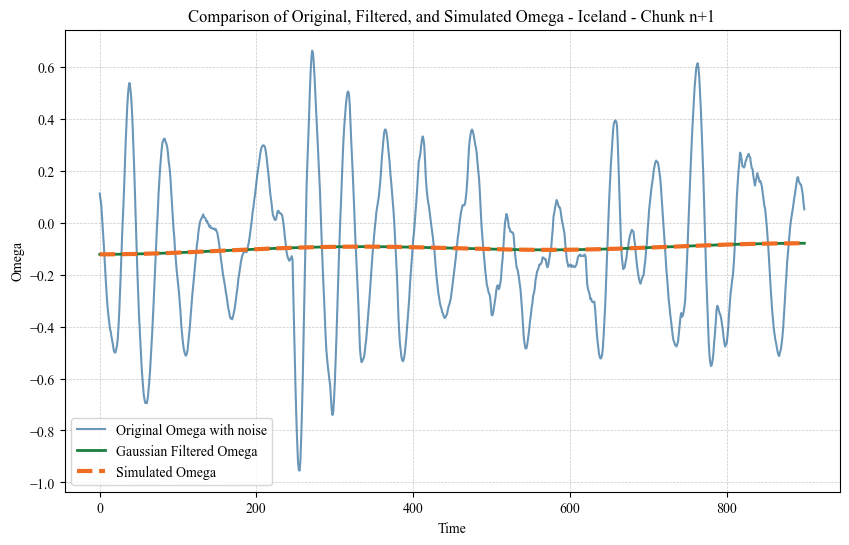

In [43]:
n=100
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(iceland_data[n]['omega_filtered'].values)[0], 
                      iceland_data[n]['omega_filtered'].iloc[0], 0.00]

# Define time points for simulation
total_time = len(iceland_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = iceland_data[n]['omega'].values  # Replace 'omega' with the actual column name
omega_filtered = iceland_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 2)
simulate_sindy_model(iceland_models[n], initial_conditions, time_points, 'Iceland - Chunk n+1', 
                     omega_original, omega_filtered)


### Balearic

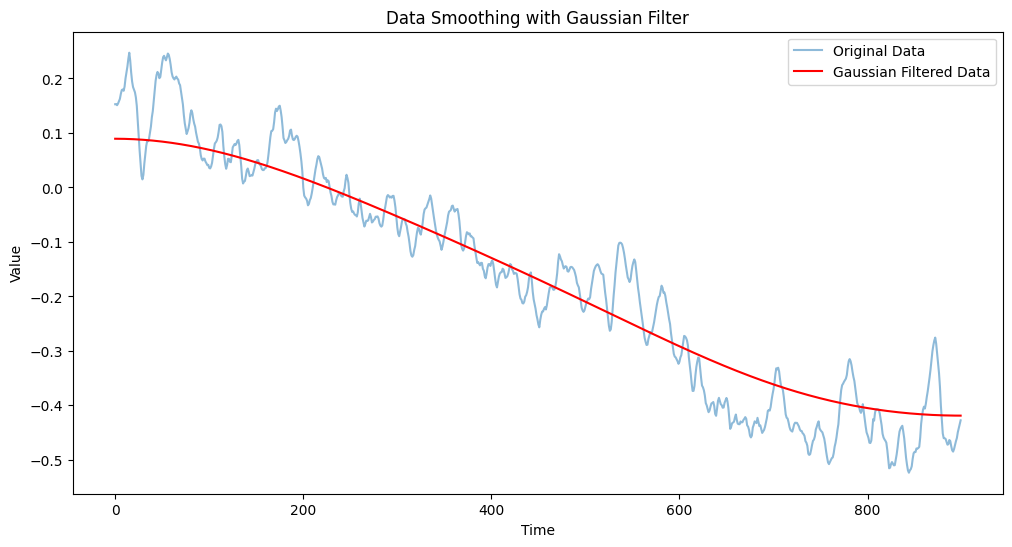

In [9]:
# Reset the index of the DataFrame
bal = flt_dataframes[0].reset_index(drop=True)
omega_Bal=bal['omega']
gaussian_filtered_data = gaussian_filter(omega_Bal, sigma=150)
data = gaussian_filtered_data
theta = integrate_data(data, dt=1)

In [29]:
dt=1
x_train = np.column_stack((theta, data))
t_train = np.arange(0, len(data), 1)
# Add time as a linear feature
linear_time_feature = -t_train.reshape(-1, 1)
x_train_augmented = np.hstack([x_train, linear_time_feature])

# Feature names for SINDy (including a linear term for time)
feature_names = ["theta", "omega", "linear_time"]

# Use Polynomial Library with degree 1
polynomial_library = ps.PolynomialLibrary()

# Sparse regression optimizer
sparse_regression_optimizer = ps.STLSQ(threshold=1e-6)

# Create a SINDy model with the polynomial library
model = ps.SINDy(feature_names=feature_names, 
                 feature_library=polynomial_library,
                 optimizer=sparse_regression_optimizer)

# Fit the model (including the linear feature for time)
model.fit(x_train_augmented, t=dt, library_ensemble=True, quiet=True)
model.print(precision=6)
print("Model Score:", model.score(x_train_augmented, t=dt))

(theta)' = 0.000771 1 + -0.000145 theta + 0.988795 omega + -0.000007 linear_time + 0.028814 omega^2 + -0.000047 omega linear_time
(omega)' = -0.000926 1 + 0.000106 theta + 0.016744 omega + 0.000005 linear_time + 0.000042 theta omega + -0.070587 omega^2 + 0.000102 omega linear_time
(linear_time)' = -1.000000 1
Model Score: 0.6659296631211542


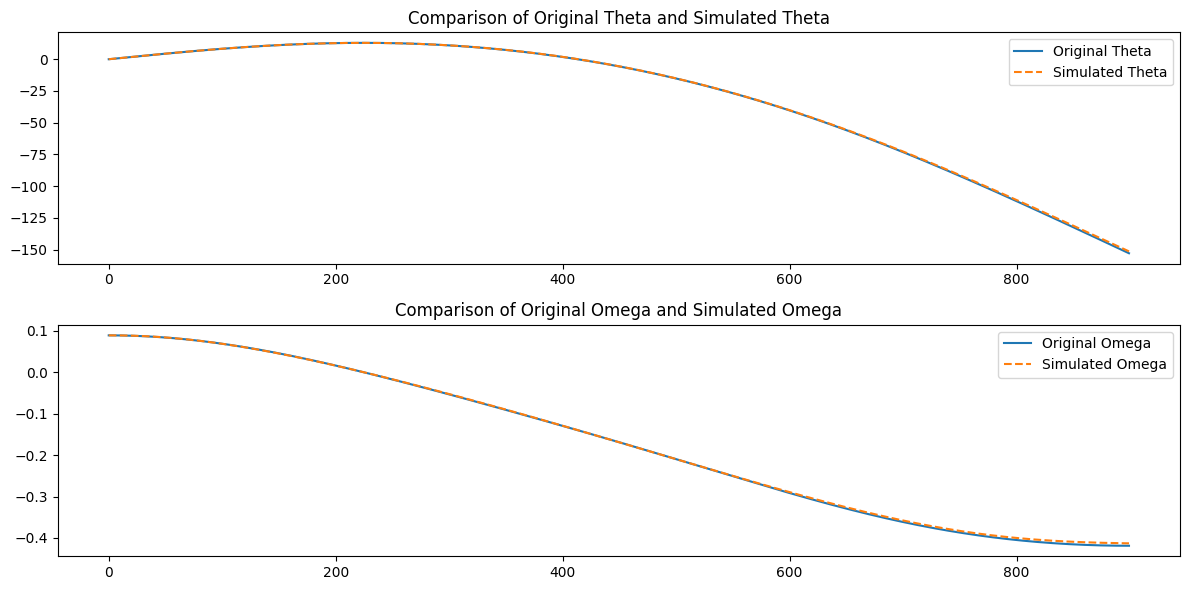

In [30]:
initial_condition = [theta[0], data[0],0.01]
compare_simulated_to_original(model, theta, data, initial_condition)

## Ireland

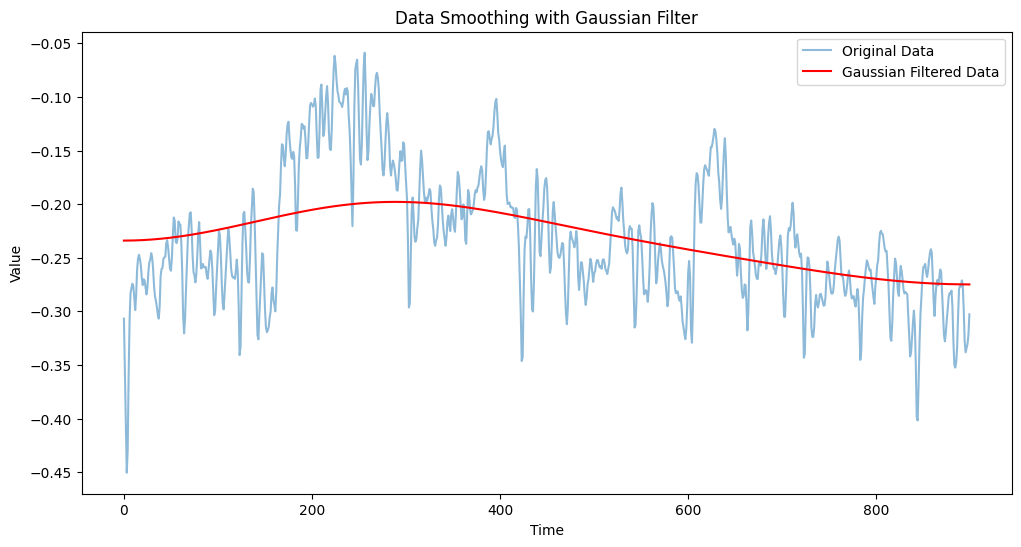

In [34]:
# Reset the index of the DataFrame
ire = flt_dataframes[1].reset_index(drop=True)
omega_Ire=ire['omega']
gaussian_filtered_data = gaussian_filter(omega_Ire, sigma=150)
data = gaussian_filtered_data
theta = integrate_data(data, dt=1)

In [35]:
dt=1
x_train = np.column_stack((theta, data))
t_train = np.arange(0, len(data), 1)
# Add time as a linear feature
linear_time_feature = -t_train.reshape(-1, 1)
x_train_augmented = np.hstack([x_train, linear_time_feature])

# Feature names for SINDy (including a linear term for time)
feature_names = ["theta", "omega", "linear_time"]

# Use Polynomial Library with degree 1
polynomial_library = ps.PolynomialLibrary()

# Sparse regression optimizer
sparse_regression_optimizer = ps.STLSQ(threshold=1e-6)

# Create a SINDy model with the polynomial library
model = ps.SINDy(feature_names=feature_names, 
                 feature_library=polynomial_library,
                 optimizer=sparse_regression_optimizer)

# Fit the model (including the linear feature for time)
model.fit(x_train_augmented, t=dt, library_ensemble=True, quiet=True)
model.print(precision=6)
print("Model Score:", model.score(x_train_augmented, t=dt))

(theta)' = 0.002835 1 + -0.000079 theta + 1.021705 omega + 0.000019 linear_time + 0.000003 theta^2 + 0.000019 theta omega + -0.000002 theta linear_time + 0.041022 omega^2 + 0.000001 omega linear_time
(omega)' = -0.005620 1 + -0.000201 theta + -0.055804 omega + 0.000045 linear_time + -0.000579 theta omega + -0.135203 omega^2 + 0.000130 omega linear_time
(linear_time)' = -1.000000 1
Model Score: 0.6655494050094156


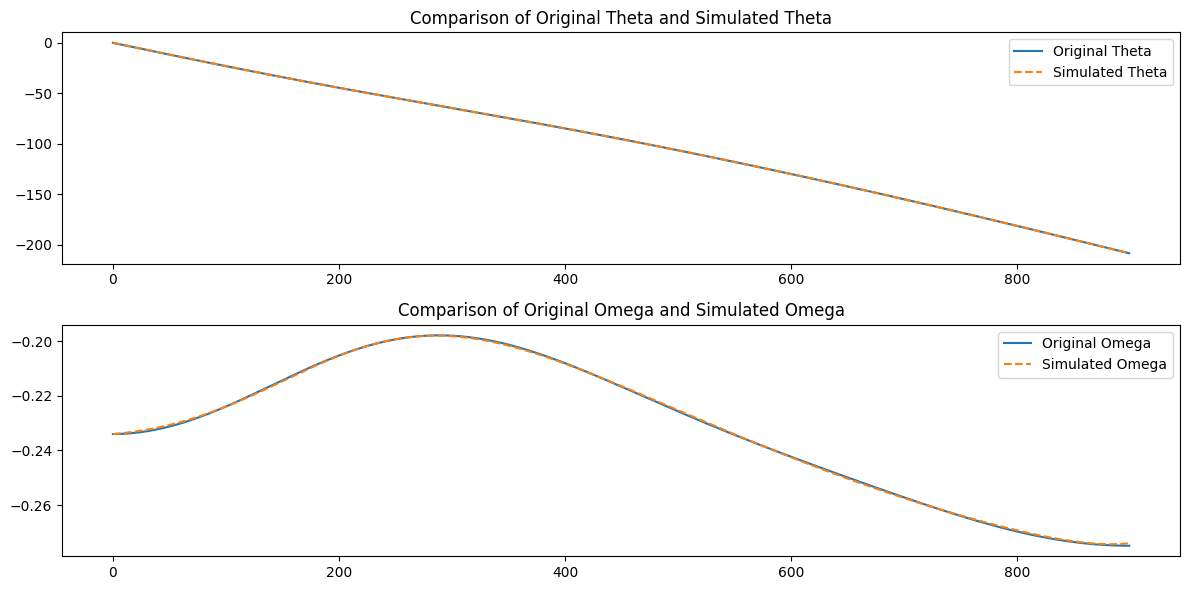

In [36]:
initial_condition = [theta[0], data[0],0.01]
compare_simulated_to_original(model, theta, data, initial_condition)

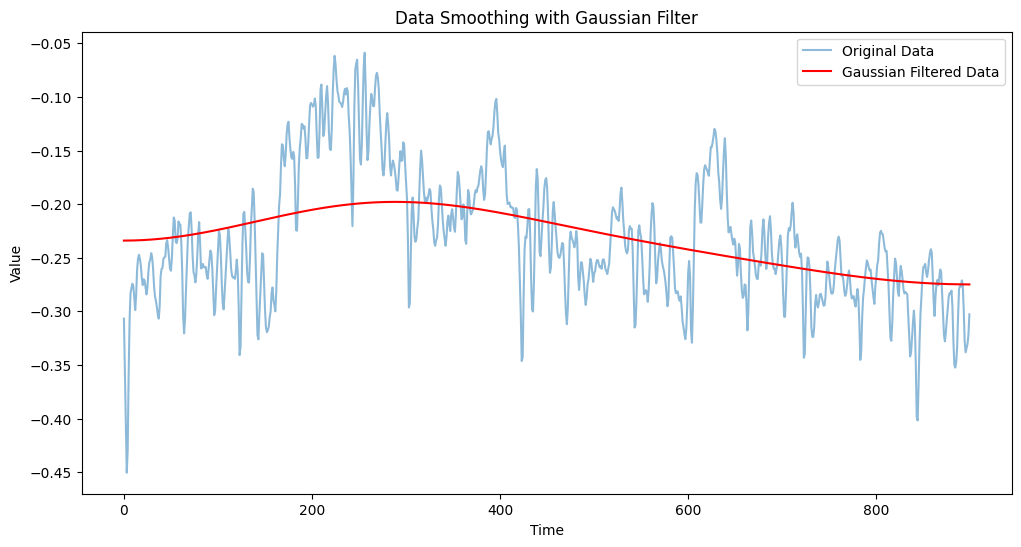

In [37]:
# Reset the index of the DataFrame
ice = flt_dataframes[2].reset_index(drop=True)
omega_Ice=ire['omega']
gaussian_filtered_data = gaussian_filter(omega_Ice, sigma=150)
data = gaussian_filtered_data
theta = integrate_data(data, dt=1)

In [38]:
dt=1
x_train = np.column_stack((theta, data))
t_train = np.arange(0, len(data), 1)
# Add time as a linear feature
linear_time_feature = -t_train.reshape(-1, 1)
x_train_augmented = np.hstack([x_train, linear_time_feature])

# Feature names for SINDy (including a linear term for time)
feature_names = ["theta", "omega", "linear_time"]

# Use Polynomial Library with degree 1
polynomial_library = ps.PolynomialLibrary()

# Sparse regression optimizer
sparse_regression_optimizer = ps.STLSQ(threshold=1e-6)

# Create a SINDy model with the polynomial library
model = ps.SINDy(feature_names=feature_names, 
                 feature_library=polynomial_library,
                 optimizer=sparse_regression_optimizer)

# Fit the model (including the linear feature for time)
model.fit(x_train_augmented, t=dt, library_ensemble=True, quiet=True)
model.print(precision=6)
print("Model Score:", model.score(x_train_augmented, t=dt))

(theta)' = 0.002835 1 + -0.000079 theta + 1.021705 omega + 0.000019 linear_time + 0.000003 theta^2 + 0.000019 theta omega + -0.000002 theta linear_time + 0.041022 omega^2 + 0.000001 omega linear_time
(omega)' = -0.005620 1 + -0.000201 theta + -0.055804 omega + 0.000045 linear_time + -0.000579 theta omega + -0.135203 omega^2 + 0.000130 omega linear_time
(linear_time)' = -1.000000 1
Model Score: 0.6655494050094156


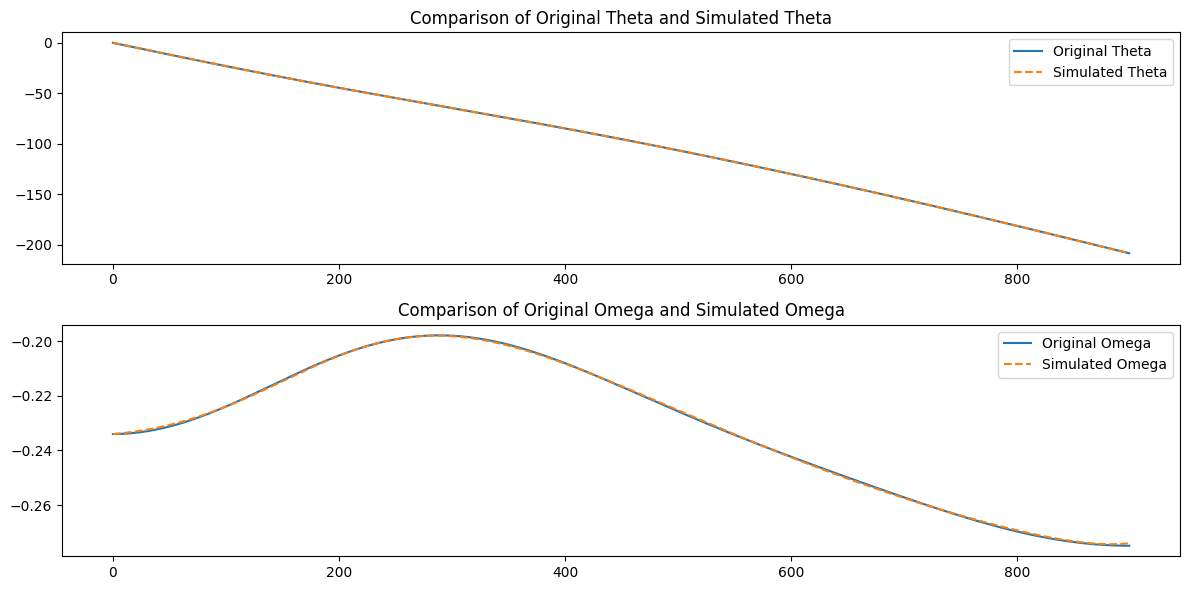

In [39]:
initial_condition = [theta[0], data[0],0.01]
compare_simulated_to_original(model, theta, data, initial_condition)

In [62]:
def piecewise_function(t, dt=1, len_theta=None):
    if len_theta is None:
        raise ValueError("len_theta must be provided")

    # Define the breakpoints based on the length of theta
    one_third_len = len_theta // 3
    two_thirds_len = 2 * len_theta // 3

    # Convert these breakpoints to time
    first_breakpoint = one_third_len * dt
    second_breakpoint = two_thirds_len * dt

    # Vectorized handling of conditions
    return np.where(t < first_breakpoint, 1, np.where(t < second_breakpoint, -1, 1/3))


In [77]:
bal=filter_data[0]
%store bal
omega=bal['omega']
data = gaussian_filter1d(omega, 20)
theta = integrate_data(data, dt=1)

Stored 'bal' (DataFrame)


In [75]:
len(time_feature)

409471

In [76]:
# Add time as a feature
t_train = np.arange(0, len(data), 1)
time_feature = t_train.reshape(-1, 1)  # Make it a column vector
x_train_augmented = np.column_stack((theta, data, time_feature))

# Feature names for SINDy 
feature_names = ["theta", "omega", "time"]

# Create a custom library for -t and a standard polynomial library
custom_library = ps.CustomLibrary(library_functions=[lambda t: piecewise_function(t, dt=1, len_theta=len(data))])
polynomial_library = ps.PolynomialLibrary() 

# Combine the custom library with the polynomial library using the + operator
combined_library = custom_library + polynomial_library

# Sparse regression optimizer
sparse_regression_optimizer = ps.STLSQ(threshold=1e-10)

# Create a SINDy model with the combined library
model = ps.SINDy(feature_names=feature_names, 
                 feature_library=combined_library,
                 optimizer=sparse_regression_optimizer)

# Fit the model
model.fit(x_train_augmented, t=dt, library_ensemble=True, quiet=True)
model.print(precision=6)
print("Model Score:", model.score(x_train_augmented, t=dt))

(theta)' = -0.000027 f0(theta) + -0.000027 f0(omega) + 0.000015 f0(time) + -0.000027 1 + 0.999982 omega + -0.000033 omega^2
(omega)' = -0.000046 f0(theta) + -0.000046 f0(omega) + 0.000023 f0(time) + -0.000046 1 + 0.000036 omega + -0.000044 omega^2
(time)' = 0.333333 f0(theta) + 0.333333 f0(omega) + 0.333333 1
Model Score: 0.33376976766421523


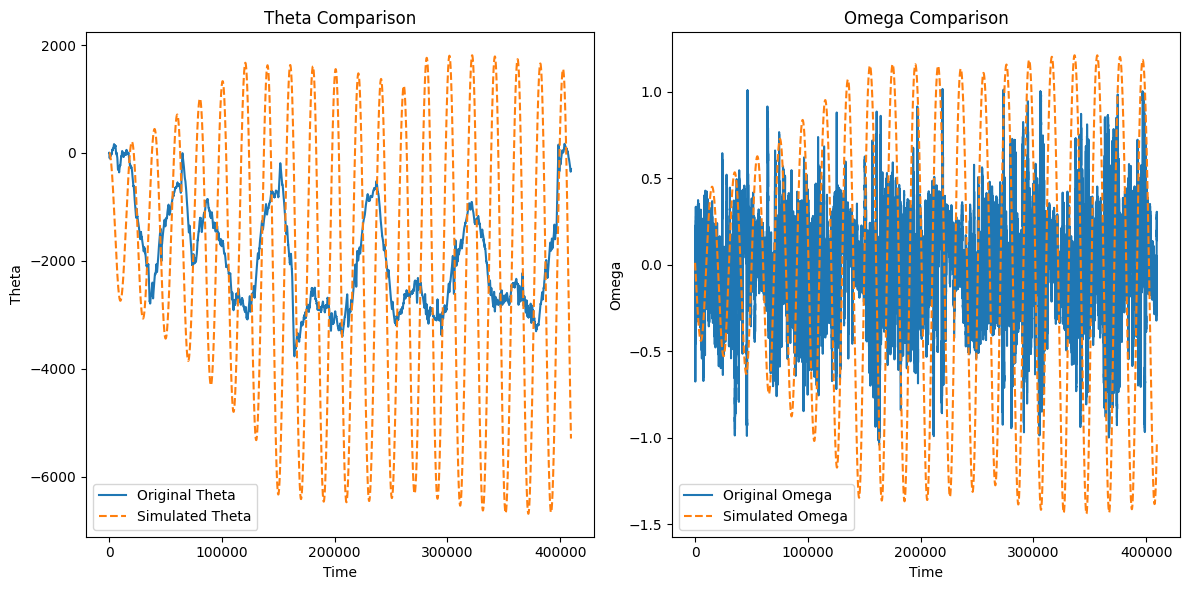

In [73]:
# Augment initial condition with the starting time (0 in this case)
x0_augmented = np.array([-0.1, 0.01 , 0])  # Append 0 for time

# Simulate the dynamics using the SINDy model
x_simulated = model.simulate(x0_augmented, t_train)

# Extract original and simulated theta and omega
simulated_theta = x_simulated[:, 0]
simulated_omega = x_simulated[:, 1]

# Plotting
plt.figure(figsize=(12, 6))

# Plot original and simulated theta
plt.subplot(1, 2, 1)
plt.plot(t_train, theta, label='Original Theta')
plt.plot(t_train, simulated_theta, label='Simulated Theta', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Theta')
plt.title('Theta Comparison')
plt.legend()

# Plot original and simulated omega
plt.subplot(1, 2, 2)
plt.plot(t_train, omega, label='Original Omega')
plt.plot(t_train, simulated_omega, label='Simulated Omega', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Omega')
plt.title('Omega Comparison')
plt.legend()

plt.tight_layout()
plt.show()

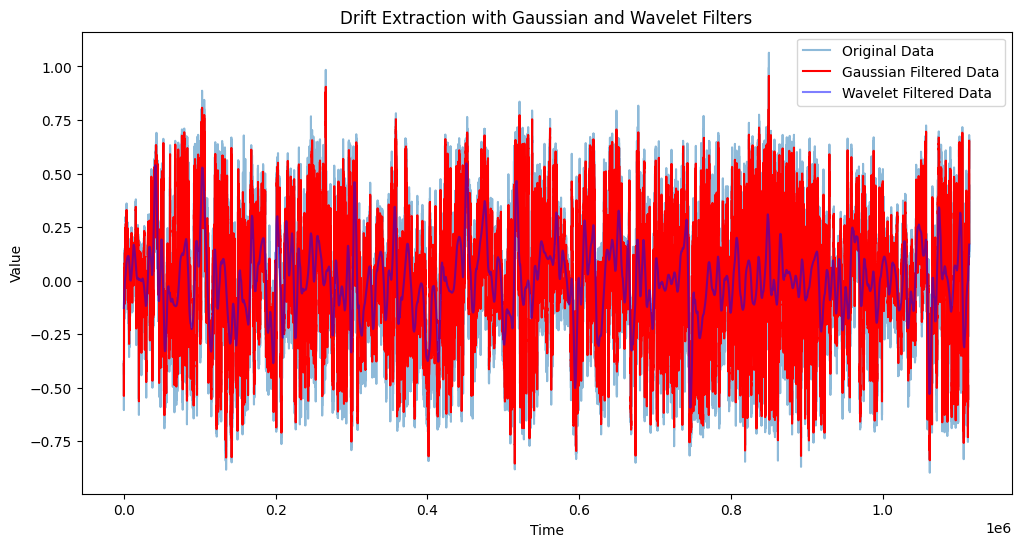

In [119]:
ire=filter_data[1]
omega=ire['omega']
%store ire


import pywt

# Apply Gaussian Filter for Diffusion
sigma = 10  # Standard deviation for Gaussian kernel
gaussian_filtered_data = gaussian_filter1d(omega, sigma)

# Apply Wavelet Filter for External Force
# Choosing a wavelet and level of decomposition
wavelet = 'db4'  # Daubechies wavelet
level = 12  # Decomposition level
coeffs = pywt.wavedec(gaussian_filtered_data, wavelet, level=level)

# Assuming the external force is mostly in the first few levels,
# zero out these coefficients
coeffs[1:] = [np.zeros_like(coeff) for coeff in coeffs[1:]]

# Reconstruct the signal without external force components
wavelet_filtered_data = pywt.waverec(coeffs, wavelet)

# Plot the results with both filters applied
plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data', alpha=0.5)
plt.plot(gaussian_filtered_data, label='Gaussian Filtered Data', color='red')
plt.plot(wavelet_filtered_data, label='Wavelet Filtered Data', color='blue', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Drift Extraction with Gaussian and Wavelet Filters')
plt.legend()
plt.show()


In [120]:
dt = 1       

# Manual integration
theta = np.zeros(len(wavelet_filtered_data))
for i in range(1, len(wavelet_filtered_data)):
    theta[i] = theta[i-1] + wavelet_filtered_data[i] * dt
    
# Prepare the training data
x_train = np.column_stack((theta, wavelet_filtered_data))

In [124]:
x_train = np.column_stack((theta, wavelet_filtered_data))
# Feature names for SINDy 
feature_names = ["theta", "omega"]

sparse_regression_optimizer = ps.STLSQ(threshold=1e-10)
#differentiation_method = ps.SmoothedFiniteDifference()
#differentiation_method = ps.FiniteDifference(order=2)
model = ps.SINDy(feature_names=feature_names, 
                 optimizer=sparse_regression_optimizer
                 #,
                 #differentiation_method=differentiation_method
                )

# Fit the model as usual
model.fit(x_train, t=1, ensemble=True, quiet=True)

model.print(precision=9)
#model.score(x_train, t=1)

(theta)' = 0.000006088 1 + -0.000000003 theta + 1.000000188 omega + 0.000004709 omega^2
(omega)' = 0.000012167 1 + -0.000000006 theta + -0.000000251 omega + 0.000009885 omega^2


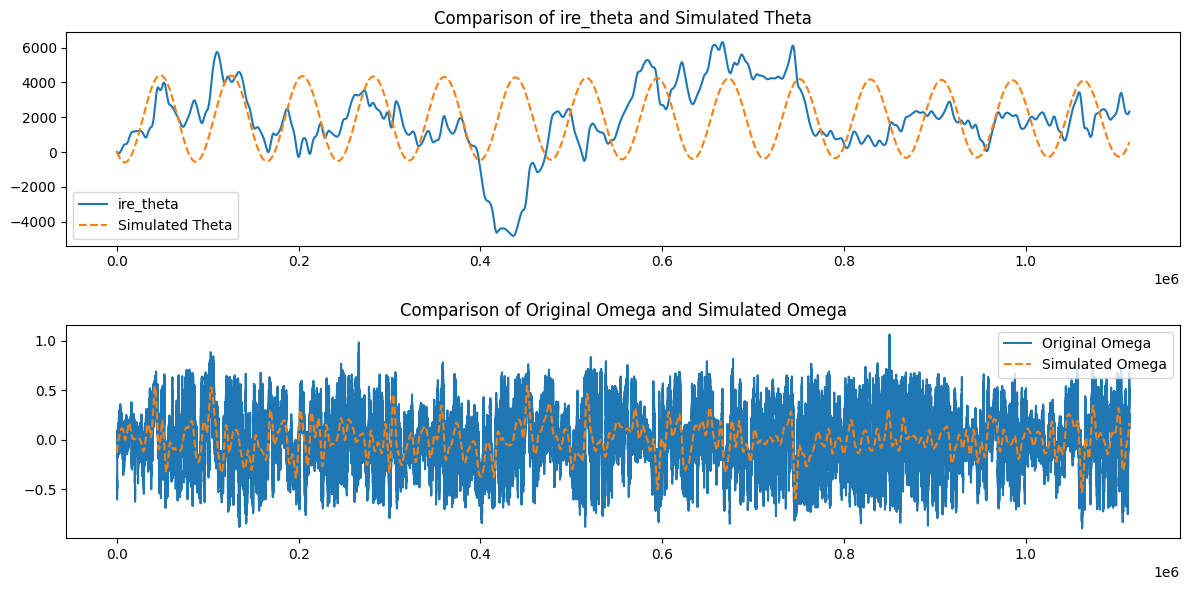

In [125]:
# Assuming the initial condition is known
initial_condition = [theta[0], wavelet_filtered_data[0]]  # for theta and omega

total_time = len(theta)
time_points = np.arange(0, total_time, 1)

# Use the model to simulate the system
simulated_data = model.simulate(initial_condition, time_points)

# Extract the simulated theta and omega
simulated_theta = simulated_data[:, 0]
simulated_omega = simulated_data[:, 1]

# Plot ire_theta and simulated_theta
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(theta, label='ire_theta')
plt.plot(simulated_theta, label='Simulated Theta', linestyle='--')
plt.title('Comparison of ire_theta and Simulated Theta')
plt.legend()

# Plot data and simulated_omega
plt.subplot(2, 1, 2)
plt.plot(wavelet_filtered_data, label='Original Omega')
plt.plot(simulated_omega, label='Simulated Omega', linestyle='--')
plt.title('Comparison of Original Omega and Simulated Omega')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
ensemble_coefs = model.coef_list
# Get average and standard deviation of the ensemble model coefficients
mean_ensemble = np.mean(ensemble_coefs, axis=0)
std_ensemble = np.std(ensemble_coefs, axis=0)

# Fit the model as usual
model.fit(x_train, t=1, library_ensemble=True, quiet=True)
model.print(precision=9)

library_ensemble_coefs = model.coef_list
# Get average and standard deviation of the library ensemble model coefficients
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)


(theta)' = 0.000000171 1 + 1.000002128 omega
(omega)' = 0.000002764 1 + -0.000000002 theta + 0.000004372 omega


In [ ]:
plot_ensemble_results(
    model, 
    mean_ensemble, 
    std_ensemble, 
    mean_library_ensemble, 
    std_library_ensemble
)

In [17]:
import torch
from svise import sde_learning
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

theta = theta  
omega = wavelet_filtered_data  

# Create time points
total_time = len(theta)
time_points = np.arange(0, total_time, 1)

# Create DataFrame
data = pd.DataFrame({
    'train_t': time_points,
    'train_y': list(zip(theta, omega))
})

batch_size = min(len(train_t_tensor), 128)
train_loader = DataLoader(TensorDataset(train_t_tensor, train_y_tensor), batch_size=batch_size, shuffle=True)

# Parameters for SparsePolynomialSDE model
t_span = (data["train_t"].min(), data["train_t"].max())
d = 2  # Latent state dimensions (theta and omega)
degree = 1  # Polynomial degree
n_reparam_samples = 16
std = 0.1
var = (torch.ones(d) * std) ** 2
num_data = len(data["train_t"])
G = torch.eye(d)

# Define SparsePolynomialSDE model
model = sde_learning.SparsePolynomialSDE(
    d, 
    t_span, 
    degree=degree, 
    n_reparam_samples=n_reparam_samples, 
    G=G, 
    num_meas=d, 
    measurement_noise=var, 
    train_t=train_t_tensor, 
    train_x=train_y_tensor,
    input_labels=["theta", "omega"]
)


In [28]:
train_t_tensor = torch.tensor(data["train_t"].to_numpy(), dtype=torch.float32).unsqueeze(1)
train_y_tensor = torch.tensor(np.array(data["train_y"].tolist()), dtype=torch.float32)

train_t_tensor = train_t_tensor.unsqueeze(1) 


# Create the DataLoader
train_loader = DataLoader(TensorDataset(train_t_tensor, train_y_tensor), batch_size=batch_size, shuffle=True)


# sparse learning takes a long time to converge
num_epochs = 40972
warmup_iters = num_epochs // 2
j=0
for epoch in tqdm(range(1,num_epochs+1)):
    j += 1
    beta = min(1.0, j / warmup_iters)
    for tbatch, ybatch in train_loader:
        optimizer.zero_grad()
        loss = -model.elbo(tbatch, ybatch, beta=beta,  N=num_data)
        loss.backward()
        optimizer.step()

  0%|                                                                                        | 0/40972 [00:00<?, ?it/s]


IndexError: index 0 is out of bounds for dimension 0 with size 0

In [14]:
(train_y_tensor).shape

torch.Size([409472, 2])

In [15]:
print(torch.isnan(train_t_tensor).any(), torch.isnan(train_y_tensor).any())
print(torch.isinf(train_t_tensor).any(), torch.isinf(train_y_tensor).any())


tensor(False) tensor(False)
tensor(False) tensor(False)


In [20]:
print("train_t_tensor shape:", train_t_tensor.shape)
print("train_y_tensor shape:", train_y_tensor.shape)
print("Is train_t_tensor empty?", train_t_tensor.nelement() == 0)
print("Is train_y_tensor empty?", train_y_tensor.nelement() == 0)


train_t_tensor shape: torch.Size([409472, 1])
train_y_tensor shape: torch.Size([409472, 2])
Is train_t_tensor empty? False
Is train_y_tensor empty? False


In [22]:
train_t_tensor

tensor([[[0.0000e+00]],

        [[1.0000e+00]],

        [[2.0000e+00]],

        ...,

        [[4.0947e+05]],

        [[4.0947e+05]],

        [[4.0947e+05]]])

In [23]:
train_y_tensor

tensor([[0.0000e+00, 5.4123e-02],
        [5.4118e-02, 5.4118e-02],
        [1.0823e-01, 5.4113e-02],
        ...,
        [6.0071e+02, 1.5620e-01],
        [6.0086e+02, 1.5620e-01],
        [6.0102e+02, 1.5621e-01]])

In [10]:
import sys
sys.path.append('C:/Users/wp7528/3.sindy')  # Path to the directory containing Multistep_NNs

from Multistep_NNs.Multistep_NN import Multistep_NN
import numpy as np



In [32]:
ire

Time        f50     omega
0       2022-01-25 09:33:06  49.936927 -0.396297
1       2022-01-25 09:33:07  49.937673 -0.391615
2       2022-01-25 09:33:08  49.937124 -0.395060
3       2022-01-25 09:33:09  49.937618 -0.391955
4       2022-01-25 09:33:10  49.938048 -0.389259
...                     ...        ...       ...
1114124 2022-02-07 07:01:50  50.018142  0.113990
1114125 2022-02-07 07:01:51  50.017359  0.109069
1114126 2022-02-07 07:01:52  50.017889  0.112399
1114127 2022-02-07 07:01:53  50.019730  0.123968
1114128 2022-02-07 07:01:54  50.022152  0.139187

[1114129 rows x 3 columns]

In [21]:

omega=ire['omega']

dt = 1       

# Manual integration
theta = np.zeros(len(omega))
for i in range(1, len(omega)):
    theta[i] = theta[i-1] + omega[i] * dt

In [29]:
import numpy as np
import tensorflow as tf

# Example: Your omega and theta data
#theta = theta  # Already an array or list
#omega = wavelet_filtered_data  # Already an array or list


# Assuming omega and theta are 1D arrays of the same length
S = 1  # number of trajectories
N = len(omega)  # number of time snapshots
D = 2  # number of dimensions (omega, theta)

# Combine omega and theta into the required shape [S, N, D]
X = np.zeros((S, N, D))
X[0, :, 0] = omega
X[0, :, 1] = theta

# Define Multistep_NN parameters
dt = 1  # example timestep
layers = [D, 50, 50, D]  # example neural network layers
M = 3  # example number of multistep
scheme = 'AM'  # example scheme: Adams-Moulton

# Create and train the Multistep_NN model
model = Multistep_NN(dt, X, layers, M, scheme)
# Adjust the learning rate of the optimizer
model.optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.train(N_Iter=100)

It: 0, Loss: 3.939e+06, Time: 2.94
It: 10, Loss: 3.932e+06, Time: 28.68
It: 20, Loss: 3.925e+06, Time: 28.41
It: 30, Loss: 3.921e+06, Time: 28.36
It: 40, Loss: 3.917e+06, Time: 28.36
It: 50, Loss: 3.915e+06, Time: 28.66
It: 60, Loss: 3.913e+06, Time: 28.35
It: 70, Loss: 3.912e+06, Time: 28.65
It: 80, Loss: 3.910e+06, Time: 28.42
It: 90, Loss: 3.909e+06, Time: 28.30


NameError: name 'predictions' is not defined

In [30]:
# Initialize a list to collect predictions
predictions = []

# Iterate over each time step
for i in range(S, N):
    # Reshape the current step data for prediction
    X_star = X[:, i-S:i, :].reshape(1, S, D)
    # Predict the next step
    F_star = model.predict_f(X_star)
    predictions.append(F_star.numpy())

# Convert list of predictions to an array
predictions = np.array(predictions).squeeze()



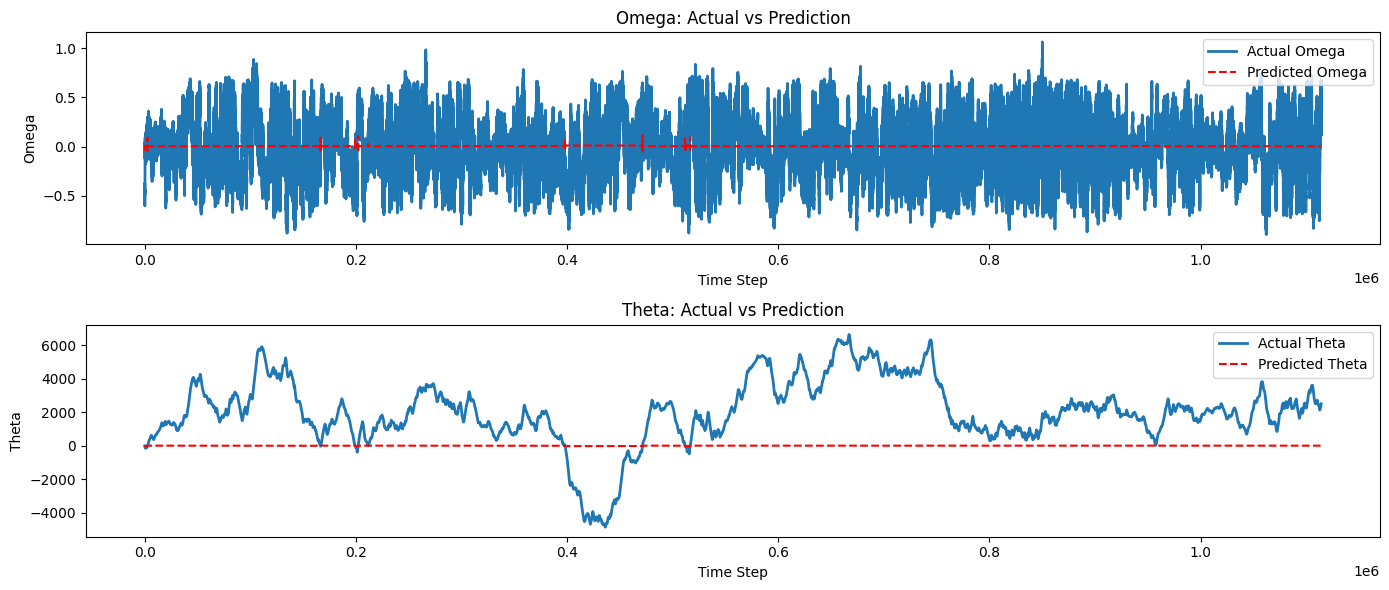

In [31]:
# Assuming 'predictions' is a numpy array with the shape [N-S, D]
# where N is the total number of time steps and S is the sequence length used for predictions

# Plot actual and predicted omega
plt.figure(figsize=(14, 6))

# Actual omega
plt.subplot(2, 1, 1)
plt.plot(omega, label='Actual Omega', linewidth=2)
# Predicted omega (offset by S to align with the actual data)
plt.plot(np.arange(S, N), predictions[:, 0], 'r--', label='Predicted Omega')
plt.title('Omega: Actual vs Prediction')
plt.xlabel('Time Step')
plt.ylabel('Omega')
plt.legend()

# Actual and predicted theta
plt.subplot(2, 1, 2)
plt.plot(theta, label='Actual Theta', linewidth=2)
# Predicted theta (offset by S to align with the actual data)
plt.plot(np.arange(S, N), predictions[:, 1], 'r--', label='Predicted Theta')
plt.title('Theta: Actual vs Prediction')
plt.xlabel('Time Step')
plt.ylabel('Theta')
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
import pandas as pd

# Assuming 'df' is your pandas DataFrame
# Convert 'Time' column to datetime
ire['Time'] = pd.to_datetime(ire['Time'])

# Set the 'Time' column as the index of the DataFrame
ire = ire.set_index('Time')

one_hour_data = ire['2022-01-27 09:00':'2022-01-27 10:00']


In [34]:
one_hour_data

f50     omega
Time                                    
2022-01-27 09:00:00  49.992588 -0.046570
2022-01-27 09:00:01  49.988339 -0.073271
2022-01-27 09:00:02  49.978647 -0.134163
2022-01-27 09:00:03  49.965439 -0.217153
2022-01-27 09:00:04  49.961520 -0.241780
...                        ...       ...
2022-01-27 10:00:55  50.049264  0.309532
2022-01-27 10:00:56  50.050894  0.319776
2022-01-27 10:00:57  50.052694  0.331088
2022-01-27 10:00:58  50.055857  0.350962
2022-01-27 10:00:59  50.058817  0.369560

[3660 rows x 2 columns]